In [1]:
# Load libraries
import pandas as pd 
import numpy as np
from collections import Counter, OrderedDict
import tqdm
from collections import defaultdict
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS

# Libraries for NLP
import re
import fasttext as ft
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
import en_core_web_lg
from spacy.matcher import Matcher
nlp = en_core_web_lg.load()
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import emoji
# Tools for creating ngrams and vectorizing input data
import gensim
from gensim.models import Word2Vec, Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
import tomotopy as tp
import pyLDAvis
import tmplot
stop = set(stopwords.words('english'))

# Plots for visualisations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures,TrigramCollocationFinder,TrigramAssocMeasures

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/georgestavrakis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# Define the function

### Explorational analysis

In [2]:
# Creating a function for preliminary exploration for youtube comment's datasets
def prelim_explor_yt(df, column_name, comment_id):
    # See information of the dataset
    print(df.info())
    print('------------')
    # drop the row with the NaN in text
    df = df.dropna(subset=column_name)
    df.reset_index(drop=True, inplace=True)
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    print(df['word_count'].describe())
    print('------------')
    # Creating a column that separate the main text with it's replies
    df['main'] = df[comment_id].str.contains("\.")
    df['main'].replace({False:1,True:0}, inplace=True)
    # Exploring the dataset
    replies = sum(df[comment_id].str.contains("\.")) 
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Total number of main comments: {}
    Total number of replies: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    --------------------------------------
    '''.format(df.shape[0], df.shape[0]-replies, replies, round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1) ))
    return df

### Language detection

 To detect the language of each comment we used the *fasttext* 
 - You can find further info here: https://towardsdatascience.com/4-nlp-libraries-for-automatic-language-identification-of-text-data-in-python-cbc6bf664774
 - To reproduce the code you need to download the package lid.176.bin from here: https://fasttext.cc/docs/en/language-identification.html
 - You can see the abbreviations: https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes

In [3]:
# Detect the language of the text with fasttext for youtube

# Load the pretrained model
ft_model = ft.load_model("/Users/georgestavrakis/Documents/Master_Business_Analytics/Term_3/SMM694_Applied_Natural_Language_Processing/lid.176.bin")

# Creating the function to detect the language
def lang_detect(text):
    # finding the prediction for the language
    prediction = ft_model.predict(text)
    # pre-process the result to extract the abbreviation of the language
    language = prediction[0][0].split('__')[2]
    return language

# Create a function to detect the function for each comment
def text_lang(df, column_name):
    # iterated through the data
    lang = []
    for text in tqdm.tqdm(df[column_name]):
        try:
            lang.append(lang_detect(text))
        except:
            lang.append('No lang')

    df.loc[:, 'Language'] = lang

    # Find the top 10 languages
    print('---Top 10 Languages---')
    print(df['Language'].value_counts()[:5])

    return df

# Create a function to include only the comments in inglish
def english_text(df):
    # Taking only the english comments
    df = df[df['Language']== 'en']
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    return df

### Most frequent words

In [4]:
# plotting the top stopwords in the data
def plot_top_stopwords_barchart(text):
    
    new=text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    
    
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:20]
    x,y=zip(*top)
    plt.figure(figsize=(20,10))
    plt.xlabel('Top 20 Stopwords').set_fontsize(20)
    plt.ylabel('Frequency').set_fontsize(20)
    plt.bar(x,y)
    plt.title("The Frequency of the Top 20 Stopwords").set_fontsize(40)

In [5]:
def most_freq(df, column_name):
    most_freq = pd.Series(' '.join(df[column_name]).split()).value_counts()[:20] # tocenization except from stopwords
    most_freq = pd.DataFrame(most_freq)
    print('---Most frequent words---')
    print(most_freq)

### Extracting emojis

In [6]:
def extract_emojis(df, column_name):
    # Finding a list of unique emojis in a comment
    emojis = [emoji.distinct_emoji_list(comment) for comment in df[column_name] if len(emoji.distinct_emoji_list(comment))!= 0]
    # Unwind the emojis lists
    emojis = [item for items in emojis for item in items]
    return emojis

### Extracting Links


In [7]:
def extract_links(df,column_name):
    # Finding all the urls apeared in the text
    links = [re.search('(?P<url>https?://[^\s]+)', i).groupdict()['url'].split('">')[0] for i in df[column_name] if re.search('(?P<url>https?://[^\s]+)', i) != None ]
    print(len(links),'mentioned links')
    links= set(links)
    print(len(links), 'unique links')
    return links

### Text cleaning

In [8]:
# For Youtube
# Creating the list of stopwords
stop_words = set(stopwords.words('english'))

# Create a function that findings and drops the duplicates
def drop_duplicate(df, column_name):
    # Finding the duplicates
    print('Number of comments before:', df.shape[0])
    print('-----------------')
    print('Number of dublicated comments:', sum(df[column_name].duplicated()))
    #print('Number of dublicated comments:', sum(df.duplicated()))
    # Removing the dubplicates
    df = df.drop_duplicates(subset=[column_name], keep='first')
    print('-----------------')
    print('Number of comments after:', df.shape[0])
    return df

# Creating the cleaninng function

nlp = en_core_web_lg.load()

def cleaning_text(raw_text):
    
    # Removing the links
    text = re.sub(r'http\S+', '', raw_text)
    # Escaping HTML character
    text = BeautifulSoup(text).get_text()
    # Remove punctuation
    text = re.sub("[\.\,\!\?\:\;\-\=]", " ", text)
    # Remove the hastages and tags
    text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text)
    # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Removing emojis
    remove_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = remove_emoji.sub(r'', text)
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove the extra space in the beginning and the end of the text
    text = text.strip()
    # Take the lemmatisated version of the text
    if len(text)>0:
        text = [token.lemma_ for token in nlp(text) if (not token.is_stop)]
        # Recreate the text with the lemmatised version of the words
        text = " ".join(text)
    return text

# Create fuction for the cleaning of the text for sentiment analysis
def cleaning_text_sentiment(raw_text):
    
    # Removing the links
    text = re.sub(r'http\S+', '', raw_text)
    # Escaping HTML character
    text = BeautifulSoup(text).get_text()
    # Remove punctuation
    text = re.sub("[\.\,\!\?\:\;\-\=]", " ", text)
    # Remove the hastages and tags
    text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text)
    # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Removing emojis  
    remove_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = remove_emoji.sub(r'', text)
    # Changing the multiple spaces to one
    text = re.sub('\s+',' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove the extra space in the beginning and the end of the text
    text = text.strip()
    # Take the lemmatisated version of the text
    if len(text)>0:
        text = [token.lemma_ for token in nlp(text)]                #### Removing the spacy stop words because contain more negative words
        # Recreate the text with the lemmatised version of the words
        text = " ".join(text)
    return text

### Corpus exploration 

#### Wordcloud

In [9]:
# preprocessing define function
def title_token(corpus_list):
    corpus_tkns = []
    for doc in corpus_list:
        tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & (not token.is_punct) & (token.is_alpha)
    ]
        corpus_tkns.append(tmp)
    return corpus_tkns


def trigram_model(corpus_token):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(corpus_token, min_count=1, threshold=5) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    words_bigram = [bigram_mod[doc] for doc in corpus_token]
    trigram = gensim.models.Phrases(words_bigram, min_count=1, threshold=5) # higher threshold fewer phrases.
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    words_trigram = [trigram_mod[doc] for doc in words_bigram]

    return words_trigram

# creating an empty container intended for the BoW transformations
def BoW(words_trigram, vocab):
    vector_space = [] # storing the vectors associated with the individual docs
    for counter, doc in enumerate(words_trigram):
        vector = OrderedDict((token, 0) for token in vocab)
        tkns_count = Counter(doc)
        for k, v in tkns_count.items():
            vector[k] = v
        vector_space.append(vector)
    return vector_space

# Python program to generate WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

def comment_wordcloud(words_trigram,title):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in words_trigram:

        comment_words += " ".join(val)+" "
        
    wordcloud = WordCloud(width = 500, height = 500,
                    background_color ='white',
                    stopwords = stopwords,
                    max_words=50,
                    min_font_size = 5).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

In [10]:
def plot_wordcloud(corpus, title):
    wordcloud = WordCloud(background_color='white',
                          stopwords=STOP_WORDS,
                          max_words=100,
                          max_font_size=50,
                          random_state=42
                         ).generate(str(corpus))

    print(wordcloud)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Most common words, bigrams and trigrams

In [11]:
# Most frequently occuring Bi-grams
def get_top_ngrams_words(corpus, n=None, ngram = 1):
    vec1 = CountVectorizer(ngram_range=(ngram,ngram), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()] # Here we can add stopwords ->  [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items() if word not in stp]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def barplot_freq(df,title, X='Word') :
    # Barplot of most freq words
    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x=X, y="Freq", data=df)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    g.set_title(title)
    plt.show()


def barplot_freq_compare(df, df2 ,title1, title2, X='Word') :
    # Initialise the figure
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    # Barplot 1 of most freq words
    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x=X, y="Freq", data=df, ax=ax1)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    g.set_title(title1)

    # Barplot 2 of most freq words
    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x=X, y="Freq", data=df2, ax=ax2)
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    g.set_title(title2)

    plt.show()

#### Number of co-occurrences between 2 words

In [12]:
def find_co_occurrences(corpus, word, number_words):
    
    sentences = corpus
    window_size = 2
    d = defaultdict(int)

    for text in tqdm.tqdm(sentences):
        # preprocessing (use tokenizer instead)
        text = text.lower().split()
        # iterate over sentences'
        temp = word.split(' ')
        if len(temp)>1:
            if all(terms in text for terms in temp): 
                for i in range(len(text)):
                    token = word
                    next_token = text[i+1 : i+1+window_size]
                    for t in next_token:
                        if t not in temp and t not in Stopwords:
                            key = t
                            d[key] += 1
        else:
            if word in text:
                for i in range(len(text)):
                    token = word
                    next_token = text[i+1 : i+1+window_size]
                    for t in next_token:
                        if t != word and t not in Stopwords:
                            key = t
                            d[key] += 1

    result = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

    df = pd.DataFrame({'Words': result.keys(), 'Appeared': result.values()})
    df_top = df.head(number_words)
    return df_top

# Creating fuction for lollipop graph for co-occurances
def lollipop_feq(df_vis, term):
    # Create figure
    fig = plt.figure(figsize=(13,8))

    # Add subplot
    ax = fig.add_subplot(111)

    sns.scatterplot(y=df_vis['Words'], x=df_vis['Appeared'], ax= ax)
    ax.hlines(y =df_vis['Words'],  xmax=df_vis['Appeared'], xmin=0, color='blue',
            alpha=0.7, linewidth=1)

    ax.set_title('Top 10 words that co occure more frequently with the term'+' '+term)
    plt.show()

### Topic Modelling

In [13]:
# creating a function with relevant preprocessing of comments to choose k topic models using LDA, and finalising
# the one k with the best coherence score
def tm(comments,k, Stopwords):
    
    for item in Stopwords:                      
         nlp.vocab[item].is_stop = True

    # Removing the empty comments
    comments = [item for item in comments if len(item)>0]

    # Tokenising the words in the corpus
    docs_tokens, tmp_tokens = [], []
    for comment in comments:
        tmp_tokens = [
            token.lemma_
            for token in nlp(comment)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []

    bigram = Phrases(                              
        docs_tokens,
        min_count=15,    # Minimum number of appaerences in the corpus (probably 20 for small texts)
        threshold=5,     # Represent a score threshold for forming the phrases (higher means fewer phrases)
        max_vocab_size=50000,
        
    )
    trigram = Phrases(                           
        bigram[docs_tokens],
        min_count=15,
        threshold=5,
        max_vocab_size=50000,
        
    )

    # Creating the new documents with the bigrams and trigrams
    docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
    # Initialising a new corpus
    corpus = tp.utils.Corpus()
    # populate the corpus
    i=0
    index_list = []
    for item in docs_phrased:
        if len(item)==0:
            index_list.append(i)
        corpus.add_doc(words=item)
        i+=1

    cvs = {}                                     # Create the dictionary for the coherence scores per topic
    for topic_number in range(1, k+1, 1):        # Try different topic numbers
        mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed=123)
        for i in range(0, 100, 10):
            mdl.train(10)
            print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
        coh = tp.coherence.Coherence(mdl, coherence="u_mass")
        cvs[topic_number] = coh.get_score()

    fig = plt.figure(figsize=(25, 8))
    ax = fig.add_subplot(111)
    ax.plot(cvs.keys(), cvs.values(), "o-")
    ax.set_xlabel("Number of topics retained")
    ax.set_ylabel("Coherence score")
    ax.set_xticks(range(1,k+1,1))
    plt.show()
    
    topic_size=min(cvs, key=cvs.get) # Topic Size is the best number of topics
    best_mdl = tp.LDAModel(k=topic_size, corpus=corpus, seed=123) # Create the final model with the optimal number of topics
    
    return (cvs, corpus, best_mdl, topic_size, docs_phrased, index_list)

# Function to retrain the best model
def train_tm(model):
    for i in range(0, 100, 4):   # Why not 10?
        model.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, model.ll_per_word))
    return(model)

# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data

def top_n_topics (df_with_topics, df_with_tweets, df_with_words, n):
    for i in range (df_with_topics.shape[1]):
        words =  df_with_words[df_with_words.columns[i]].values.tolist()
        print("TOP", n, "documents for topic", i, ":")
        print(words)
        df_with_topics_sorted = df_with_topics.sort_values(df_with_topics.columns[i], ascending = False)
        ind = []
        for j in range (n):
            ind.append(df_with_topics_sorted.index[j])
        for j in range (n):
            print(j, ': ', df_with_tweets['Comment_text'][ind[j]])
        print ("_\n")

### Sentiment Analysis

In [14]:
# Creating the function for sentiment analysis
def sentiment(df, column_name):
    sid = SentimentIntensityAnalyzer()
    df["sentiments"] = df[column_name].apply(lambda x: sid.polarity_scores(x))
    df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

    # decide sentiment as positive, negative and neutral
    sentiment = []
    for compound in tqdm.tqdm(df['compound']):
        if compound >= 0.05 :
            sentiment.append('pos')
        elif compound <= - 0.05 :
            sentiment.append('neg')
        else :
            sentiment.append('neu')
    df.loc[:,'sentiment'] = sentiment

    return df

# Creating a function for preliminary exploration for general comment's datasets
def sentiment_explor_yt(df, column_name): 
    df.reset_index(drop=True, inplace=True)
    # Calculating the number if words
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split(' ')))
    
    pos_comments = sum(df['compound']>0.05)
    pos_comments_pecentage = round (pos_comments/len(df)*100, 1)
    
    neg_comments = sum(df['compound']<-0.05)
    neg_comments_pecentage = round (neg_comments/len(df)*100, 1)
    
    neu_comments = sum(df[df['compound']>=-0.05]['compound']<=0.05)
    neu_comments_pecentage = round (neu_comments/len(df)*100, 1)
    #print(df['word_count'].describe())
    #print('------------')
    # Exploring the dataset
    print('''
    Data information
    --------------------------------------
    Total number of comments: {}
    Average lenght of each reply: {} characters
    Average words per comment: {} words
    
    Number of positive comments (compound >0.05) is {} ({}%)
    Number of negative comments (compound <-0.05) is {} ({}%)
    Number of neutral comments (compound is between -0.05 and 0.05) is {} ({}%)
    
    --------------------------------------
    '''.format(df.shape[0], round(sum(df[column_name].apply(len))/df.shape[0],2), round(np.mean(df.word_count),1), pos_comments, pos_comments_pecentage,
              neg_comments, neg_comments_pecentage, neu_comments, neu_comments_pecentage))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10), gridspec_kw={'height_ratios': [2.5, 1]})
    
    sns.histplot(data=df, x="compound", color="red", label="Compound", kde=True, alpha = 0.1, ax = ax1).set_title('Sentiment distribution')
    sns.histplot(data=df, x="word_count", color="blue", label="Compound", kde=True, alpha = 0.1, ax = ax2).set_title('Number of words')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    d = {'Negative': [neg_comments_pecentage], 'Neutral': [neu_comments_pecentage], 'Positive': [pos_comments_pecentage] }
    df_sent = pd.DataFrame(data = d)
    
    df_sent.plot(
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar for Sentiment',
    mark_right = True,
    color = ['red', 'grey', 'green' ], alpha = 0.4,
    ax = ax3)
    
    for p in ax3.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax3.annotate(str(round(width,2)), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

    
    ax3.axis('off')
    ax4.axis('off')
    
    return 

def sentiment_explor_percentage(df, column_name):
    df.reset_index(drop=True, inplace=True)

    pos_comments = sum(df['compound']>0.05)
    pos_comments_pecentage = round (pos_comments/len(df)*100, 1)
    
    neg_comments = sum(df['compound']<-0.05)
    neg_comments_pecentage = round (neg_comments/len(df)*100, 1)
    
    neu_comments = sum(df[df['compound']>=-0.05]['compound']<=0.05)
    neu_comments_pecentage = round (neu_comments/len(df)*100, 1)

    d = {'Negative': [neg_comments_pecentage], 'Neutral': [neu_comments_pecentage], 'Positive': [pos_comments_pecentage] }
    df_sent = pd.DataFrame(data = d)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)

    df_sent.plot(
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar for Sentiment',
    mark_right = True,
    color = ['red', 'grey', 'green' ], alpha = 0.4,
    ax = ax1)
    
    for p in ax1.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax1.annotate(str(round(width,2)), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

    
    ax1.axis('off')

    return


def sentiment_stats(df):
    # Inspecting the total sentiments of the df
    print('Count of total sentiments')
    print('=========================')
    print(df['sentiment'].value_counts())
    print('=========================')
    print('Average Compound of the corpus: {}'.format(round(np.mean(df['compound']),3)))

def stats_sentiment_elements(df):
    # Printing the descriptive statistics for the compound
    elements = ['compound', 'neg', 'neu', 'pos']
    for element in elements: 
        print('Descriptive statistics of', element)
        print('=========================')
        print(df[element].describe())
        print('')
        print('Distribution of '+ element)
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        sns.histplot(data= df, x=element, label=element, kde=True, alpha = 0.5, ax= ax1)
        sns.boxplot(df[element], color='orange', ax= ax2)
        
        plt.show()

def best_worst_comment(df,column_name):
    # Find the worst comment
    wost_index = df[df.compound== min(df.compound)].index.values[0]
    print('''
    Worst Comment
    -------------
    {}'''.format(df[column_name][wost_index]))

    # Find the best comment
    best_index = df[df.compound== max(df.compound)].index.values[0]
    print('''
    Best Comment
    -------------
    {}'''.format(df[column_name][best_index]))

### Keyword extraction

In [15]:
def extracting_BEV_youtube(df, column_name):
    BEV_1 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('500|car|model') & df[column_name].str.contains('electric|Electric|new|New|500e|500 e')]
    BEV_2 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('electric|Electric|new|New|500e|500 e')]
    BEV_3 = df[df[column_name].str.contains('fiat500e|Fiat500e|fiat500|Fiat500')]
    BEV = pd.concat([BEV_1, BEV_2, BEV_3], axis=0)
    BEV.drop_duplicates(inplace=True)
    return BEV

def extracting_hybrid_youtube(df, column_name):
    hyb_1 = df[df[column_name].str.contains('fiat|Fiat') & df[column_name].str.contains('500|car|model|hybrid|Hybrid')]
    hyb_2 = df[df[column_name].str.contains('fiat500|Fiat500')]
    hybrid = pd.concat([hyb_1, hyb_2], axis=0)
    hybrid.drop_duplicates(inplace=True)
    return hybrid

def extracting_BEV_speakEV(df, column_name,column_name2):
    BEV_1 = df[df[column_name].str.contains('fiat|fca|car|model') &  df[column_name].str.contains('500e|500 e|e500|e 500')]
    BEV_2 = df[df[column_name].str.contains('fiat|fca|car|model') & df[column_name].str.contains('new|electric') & df[column_name].str.contains('500|500e|500 e')]
    BEV_3 = df[df[column_name].str.contains('fiat500e')]
    BEV_4 = df[df[column_name2].str.contains('fiat|car|model') &  df[column_name2].str.contains('500e|500 e|e500|e 500')]
    BEV_5 = df[df[column_name2].str.contains('fiat|car|model') & df[column_name2].str.contains('new|electric') & df[column_name2].str.contains('500|500e|500 e')]
    BEV_6 = df[df[column_name2].str.contains('fiat500e')]
    BEV = pd.concat([BEV_1, BEV_2, BEV_3,BEV_4,BEV_5,BEV_6], axis=0)
    BEV.drop_duplicates(inplace=True)
    return BEV


## Youtube Channel

In [16]:
# Loading the data
yt_fiat_BEV_full = pd.read_csv('fiat500bev_comments.csv')
yt_fiat_hybrid_full = pd.read_csv('fiatHybrid_comments.csv')

In [17]:
# Creating the datasets 
yt_fiat_BEV = yt_fiat_BEV_full[['Comment_id','Comment_text','time_published','time_updated']]
yt_fiat_hybrid = yt_fiat_hybrid_full[['Comment_id','Comment_text','time_published','time_updated']]

### Explorational Analysis

In [18]:
# Performing explorational analysis to the BEV dataset
yt_fiat_BEV = prelim_explor_yt(yt_fiat_BEV, 'Comment_text', 'Comment_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3956 entries, 0 to 3955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment_id      3956 non-null   object
 1   Comment_text    3955 non-null   object
 2   time_published  3953 non-null   object
 3   time_updated    3951 non-null   object
dtypes: object(4)
memory usage: 123.8+ KB
None
------------
count    3955.000000
mean       25.489001
std        32.776539
min         1.000000
25%         7.000000
50%        15.000000
75%        31.000000
max       502.000000
Name: word_count, dtype: float64
------------

    Data information
    --------------------------------------
    Total number of comments: 3955
    Total number of main comments: 3288
    Total number of replies: 667
    Average lenght of each reply: 139.11 characters
    Average words per comment: 25.5 words
    --------------------------------------
    


In [19]:
# Performing explorational analysis to the hybrid dataset

yt_fiat_hybrid = prelim_explor_yt(yt_fiat_hybrid, 'Comment_text', 'Comment_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment_id      1229 non-null   object
 1   Comment_text    1229 non-null   object
 2   time_published  1228 non-null   object
 3   time_updated    1227 non-null   object
dtypes: object(4)
memory usage: 38.5+ KB
None
------------
count    1229.000000
mean       33.384866
std        44.644898
min         1.000000
25%         9.000000
50%        19.000000
75%        41.000000
max       502.000000
Name: word_count, dtype: float64
------------

    Data information
    --------------------------------------
    Total number of comments: 1229
    Total number of main comments: 1011
    Total number of replies: 218
    Average lenght of each reply: 178.43 characters
    Average words per comment: 33.4 words
    --------------------------------------
    


### Detecting the language of the comments

In [20]:
# Keepig only the english comment for BEV
yt_fiat_BEV = text_lang(yt_fiat_BEV, 'Comment_text')
yt_fiat_BEV = english_text(yt_fiat_BEV)

100%|██████████| 3955/3955 [00:00<00:00, 45839.58it/s]

---Top 10 Languages---
en    3813
it      36
de      21
es      17
ja      11
Name: Language, dtype: int64
(3813, 7)


In [21]:
# Keepig only the english comment for BEV
yt_fiat_hybrid = text_lang(yt_fiat_hybrid, 'Comment_text')
yt_fiat_hybrid = english_text(yt_fiat_hybrid)

100%|██████████| 1229/1229 [00:00<00:00, 46455.96it/s]

---Top 10 Languages---
en    1197
it       6
es       6
ja       4
ru       4
Name: Language, dtype: int64
(1197, 7)


### Extracting and analysing emojis

In [22]:
# Finding a list of unique emojis in comments
emojis = extract_emojis(yt_fiat_BEV, 'Comment_text')
# Finding the top 10 emojis used
emoji_df = pd.DataFrame({'Count': pd.Series(emojis).value_counts()[:10]})
emoji_df

,Count
😂,106
👍,65
🤣,47
😁,17
🤔,15
👌,14
😍,14
😊,13
😄,13
😅,12


In [23]:
# Finding a list of unique emojis in comments
emojis_hybrid = extract_emojis(yt_fiat_hybrid, 'Comment_text')
# Finding the top 10 emojis used
emoji_df_hybrid = pd.DataFrame({'Count': pd.Series(emojis_hybrid).value_counts()[:10]})
emoji_df_hybrid 

,Count
😂,33
👍,32
🤣,19
😁,12
😊,10
😆,9
😍,7
🚗,6
👍🏻,5
😉,5


### Extracting links for comments

In [24]:
# Extracting the links from the comments
print('---For BEV---')
links_BEV = extract_links(yt_fiat_BEV, 'Comment_text')
# Extracting the links from the comments
print('---For hybrid---')
links_hybrid = extract_links(yt_fiat_hybrid, 'Comment_text')

---For BEV---
122 mentioned links
101 unique links
---For hybrid---
22 mentioned links
20 unique links


### Pre-processing the data

In [25]:
# Dropping dubplicates
print('---For BEV---')
yt_fiat_BEV = drop_duplicate(yt_fiat_BEV, 'Comment_text')
print('---For hybrid---')
yt_fiat_hybrid = drop_duplicate(yt_fiat_hybrid, 'Comment_text')

---For BEV---
Number of comments before: 3813
-----------------
Number of dublicated comments: 27
-----------------
Number of comments after: 3786
---For hybrid---
Number of comments before: 1197
-----------------
Number of dublicated comments: 11
-----------------
Number of comments after: 1186


### Cleaning the text

In [26]:
# Create the corpus
corpus_BEV_full = [cleaning_text(comment) for comment in yt_fiat_BEV['Comment_text']]
# Create the corpus
corpus_hybrid_full = [cleaning_text(comment) for comment in yt_fiat_hybrid['Comment_text']]

In [27]:
yt_fiat_BEV.loc[:,'Clean_corpus'] =  corpus_BEV_full
yt_fiat_hybrid.loc[:,'Clean_corpus'] =  corpus_hybrid_full

### Corpus exploration

In [28]:
stp = ['m', 've','I','s','d','y']

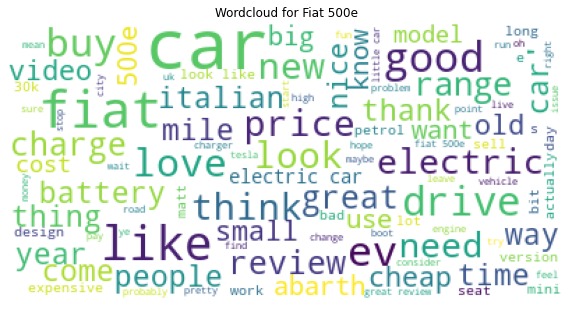

In [29]:
# Creating the wordcloud with the 100 most frequent words
plot_wordcloud(corpus_BEV_full, 'Wordcloud for Fiat 500e')

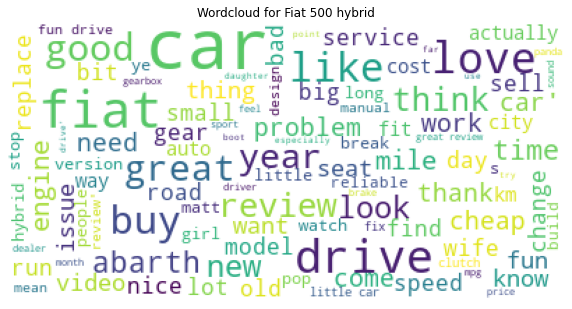

In [30]:
# Creating the wordcloud with the 100 most frequent words
plot_wordcloud(corpus_hybrid_full, 'Wordcloud for Fiat 500 hybrid')

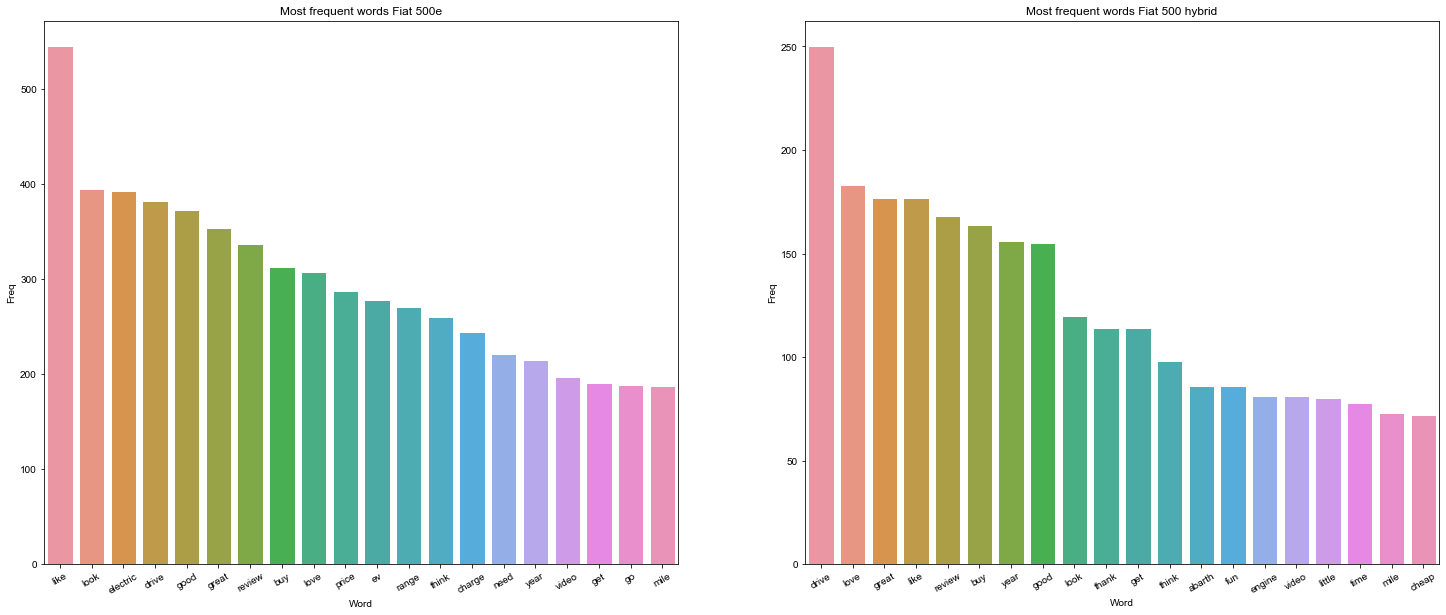

In [31]:
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
# Finding the most frequent words in the two corpus
def get_top_ngrams_words_stp(corpus, n, ngram=1, stp=stp):
    vec1 = CountVectorizer(ngram_range=(ngram,ngram), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items() if word not in stp] # Here we can add stopwords
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot
top_words = get_top_ngrams_words_stp(corpus_BEV_full, n=20, stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

# Convert most freq words to dataframe for plotting bar plot
top_words_hybrid = get_top_ngrams_words_stp(corpus_hybrid_full, n=20)
top_df_hybrid = pd.DataFrame(top_words_hybrid)
top_df_hybrid.columns=["Word", "Freq"]

barplot_freq_compare(top_df,top_df_hybrid,'Most frequent words Fiat 500e','Most frequent words Fiat 500 hybrid')

### Topic Modelling for the 2 models, Fiat 500 BEV and hybrid

In [32]:
# Removing the empty cells for BEV
yt_fiat_BEV['Clean_corpus'] = yt_fiat_BEV['Clean_corpus'].replace('',np.nan)
yt_fiat_BEV.dropna(subset=['Clean_corpus'], inplace=True)
yt_fiat_BEV.reset_index(drop=True, inplace=True)

# Removing the empty cells for hybrid
yt_fiat_hybrid['Clean_corpus'] = yt_fiat_hybrid['Clean_corpus'].replace('',np.nan)
yt_fiat_hybrid.dropna(subset=['Clean_corpus'], inplace=True)
yt_fiat_hybrid.reset_index(drop=True, inplace=True)

In [33]:
# Combine the 2 Datasets
# # Labeling the comments for 500 electric and hybrid
yt_fiat_BEV.loc[:,'500e'] = 1
yt_fiat_BEV.loc[:,'500h'] = 0
yt_fiat_hybrid.loc[:,'500e'] = 0
yt_fiat_hybrid.loc[:,'500h'] = 1
yt_combined_full = pd.concat([yt_fiat_BEV,yt_fiat_hybrid], axis=0)
yt_combined_full.reset_index(drop=True, inplace=True)

In [34]:
# Dropping duplicated values
yt_combined_full = drop_duplicate(yt_combined_full, 'Comment_text')

Number of comments before: 4879
-----------------
Number of dublicated comments: 506
-----------------
Number of comments after: 4373


In [35]:
# Creating a list of stopiwords to be excluded from topic modeling
stp= ['car', 'think','get','bit','like','$','£', 's','m','etc','thank','definitely','know','honda',
      'fiat','abarth','dog','cat','mini','panda','bmw','toyota','+', 'try','yes','vw', 'vs','e', 'tesla']

Iteration: 0	Log-likelihood: -8.15185733395893
Iteration: 10	Log-likelihood: -8.15185733395893
Iteration: 20	Log-likelihood: -8.15185733395893
Iteration: 30	Log-likelihood: -8.15185733395893
Iteration: 40	Log-likelihood: -8.15185733395893
Iteration: 50	Log-likelihood: -8.15185733395893
Iteration: 60	Log-likelihood: -8.15185733395893
Iteration: 70	Log-likelihood: -8.15185733395893
Iteration: 80	Log-likelihood: -8.15185733395893
Iteration: 90	Log-likelihood: -8.15185733395893
Iteration: 0	Log-likelihood: -8.453891385560734
Iteration: 10	Log-likelihood: -8.398816993623711
Iteration: 20	Log-likelihood: -8.353168255175955
Iteration: 30	Log-likelihood: -8.317896516509842
Iteration: 40	Log-likelihood: -8.281168942294983
Iteration: 50	Log-likelihood: -8.257365184560353
Iteration: 60	Log-likelihood: -8.232604396234564
Iteration: 70	Log-likelihood: -8.223779787160945
Iteration: 80	Log-likelihood: -8.209441614987808
Iteration: 90	Log-likelihood: -8.205716755114269
Iteration: 0	Log-likelihood: -8.

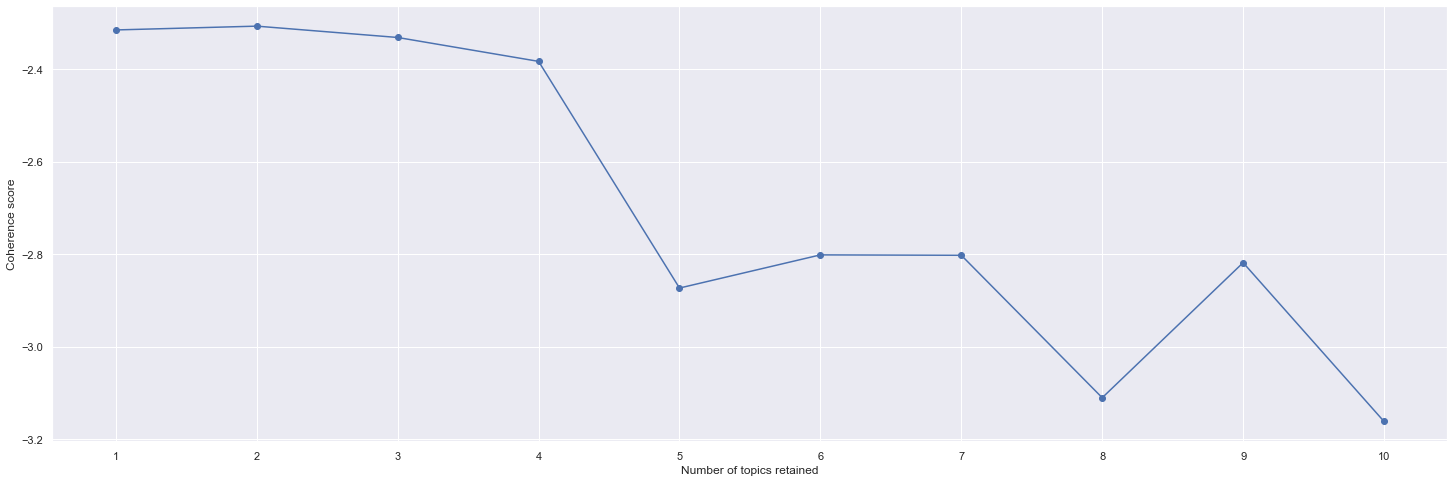

Iteration: 0	Log-likelihood: -8.905325551690233
Iteration: 4	Log-likelihood: -8.748166183463612
Iteration: 8	Log-likelihood: -8.64849072943218
Iteration: 12	Log-likelihood: -8.56456314356111
Iteration: 16	Log-likelihood: -8.510925326184024
Iteration: 20	Log-likelihood: -8.47337849674299
Iteration: 24	Log-likelihood: -8.461645272960764
Iteration: 28	Log-likelihood: -8.44376307958794
Iteration: 32	Log-likelihood: -8.422655629915507
Iteration: 36	Log-likelihood: -8.406717009887945
Iteration: 40	Log-likelihood: -8.393316971649249
Iteration: 44	Log-likelihood: -8.391954650297174
Iteration: 48	Log-likelihood: -8.392974383174462
Iteration: 52	Log-likelihood: -8.374254175375123
Iteration: 56	Log-likelihood: -8.367895082849602
Iteration: 60	Log-likelihood: -8.364637812428079
Iteration: 64	Log-likelihood: -8.362440219189663
Iteration: 68	Log-likelihood: -8.358007176251
Iteration: 72	Log-likelihood: -8.350781845266251
Iteration: 76	Log-likelihood: -8.349353784679977
Iteration: 80	Log-likelihood: 

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.030132,0.096163,0.183124,0.152987,0.027096,0.098903,0.034076,0.240594,0.108631,0.028295
1,0.044913,0.241437,0.076741,0.031822,0.040387,0.049313,0.050790,0.358610,0.063812,0.042175
2,0.040900,0.309207,0.069885,0.028979,0.036779,0.134247,0.046253,0.058553,0.236791,0.038407
3,0.030132,0.096163,0.248942,0.021350,0.027096,0.033084,0.099894,0.108956,0.042812,0.291571
4,0.345185,0.315155,0.053693,0.009772,0.012402,0.015143,0.015597,0.079998,0.109976,0.043078
...,...,...,...,...,...,...,...,...,...,...
4326,0.073920,0.074440,0.126305,0.052375,0.066472,0.081163,0.083594,0.105824,0.266493,0.069414
4327,0.063644,0.064091,0.108746,0.045094,0.057231,0.069879,0.210993,0.091113,0.090425,0.198784
4328,0.044913,0.143333,0.076741,0.031822,0.138491,0.049313,0.050790,0.260506,0.161916,0.042175
4329,0.235387,0.074440,0.126305,0.052375,0.066472,0.081163,0.083594,0.105824,0.105026,0.069414


In [36]:
## Training 10 LDAs to choose the best topic size
cvs, corpus, best_mdl, topic_size, docs_phrased, index_list = tm(comments=yt_combined_full['Clean_corpus'],k=10, Stopwords=stp)  # 7 # 14 group #

# Retrain the model with the best number of topics
best_mdl_trained = train_tm(best_mdl)

# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to go back and include those words in custom stopwords in the LDA code
wt_combined_full = pd.DataFrame()
for k in range(best_mdl_trained.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt_combined_full = pd.concat([wt_combined_full, tmp], ignore_index=False)
    del tmp

# Document to topic probabilities with the final k=10 topics 
train_td_combined_full = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["Topic {}".format(i + 1) for i in range(best_mdl.k)])
train_td_combined_full

In [37]:
# Topic to term distribution
values = {}
for k in range(best_mdl.k):
    values['Topic {}'.format(k)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in best_mdl.get_topic_words(k)]
    # print the table
    #return (table)
table_combined_full = pd.DataFrame(values)  

# Plotting the topic-word distribution
table_combined_full

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,"charge,(0.047)","drive,(0.04)","look,(0.066)","wheel,(0.018)","engine,(0.033)","drive,(0.044)","buy,(0.031)","review,(0.059)","price,(0.053)","work,(0.031)"
1,"mile,(0.035)","city,(0.028)","good,(0.049)","speed,(0.016)","year,(0.028)","good,(0.02)","want,(0.023)","love,(0.047)","electric,(0.032)","old,(0.026)"
2,"ev,(0.023)","seat,(0.028)","new,(0.043)","sport,(0.014)","time,(0.021)","sound,(0.019)","sell,(0.021)","video,(0.04)","small,(0.032)","bad,(0.018)"
3,"battery,(0.02)","big,(0.021)","buy,(0.026)","hate,(0.012)","problem,(0.02)","love,(0.018)","new,(0.02)","great,(0.036)","range,(0.031)","build,(0.014)"
4,"need,(0.018)","need,(0.019)","electric,(0.025)","convertible,(0.011)","issue,(0.019)","500e,(0.018)","lol,(0.019)","italian,(0.028)","ev,(0.022)","uk,(0.012)"
5,"vehicle,(0.016)","love,(0.017)","come,(0.019)","bad,(0.011)","drive,(0.019)","month,(0.017)","wait,(0.013)","matt,(0.024)","version,(0.02)","interior,(0.012)"
6,"charger,(0.016)","driver,(0.015)","design,(0.018)","control,(0.011)","brake,(0.015)","day,(0.017)","way,(0.013)","nice,(0.023)","expensive,(0.018)","use,(0.012)"
7,"range,(0.014)","boot,(0.015)","model,(0.017)","point,(0.011)","replace,(0.015)","enjoy,(0.014)","value,(0.012)","great_review,(0.02)","500e,(0.017)","hope,(0.011)"
8,"cost,(0.013)","km,(0.014)","people,(0.017)","feel,(0.011)","change,(0.014)","want,(0.014)","man,(0.012)","watch,(0.02)","buy,(0.016)","yeah,(0.011)"
9,"time,(0.013)","fit,(0.012)","sure,(0.014)","dash,(0.011)","gear,(0.013)","light,(0.012)","girl,(0.012)","comment,(0.015)","battery,(0.015)","feel,(0.011)"


In [38]:
# Visualise the topics to inspect the number of topics and their interpetability
prepared_data = topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/georgestavrakis/opt/anaconda3/envs/NLP_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

In [39]:
# Removing the documents that don't have topics
yt_combined_full = yt_combined_full.drop(index_list, axis=0)
yt_combined_full.reset_index(drop=True, inplace=True)

#### Topic interpretation:
- **Topic 0**: Battery, chargers and Range
- **Topic 1**: Covininient of the car in the city (commute, storage space)
- **Topic 2**: Car's look and design
- **Topic 3**: Technical equipment of the car
- **Topic 4**: Regarding the service and issues assosiated with the car
- **Topic 5**: Driving behavior and performance (based on test drive)
- **Topic 6**: Affortability of the car
- **Topic 7**: Comments regarding the video
- **Topic 8**: Price of the electric cars
- **Topic 9**: Charging Station

In [40]:
# Plotting the top 10 comments per topic
top_n_topics(train_td_combined_full,yt_combined_full,table_combined_full, 10)

TOP 10 documents for topic 0 :
['charge,(0.047)', 'mile,(0.035)', 'ev,(0.023)', 'battery,(0.02)', 'need,(0.018)', 'vehicle,(0.016)', 'charger,(0.016)', 'range,(0.014)', 'cost,(0.013)', 'time,(0.013)']
0 :  What are the charging times. (Same with any plug in). If you live in terraced house or flat with street parking you have to consider sitting in the car for hours at a public charging point twiddling your thumbs and probably paying a higher electricity rate.
1 :  This is a common misconception and the National Grid disagrees with you. Two thirds of UK homeowners have access to a driveway and, therefore, a home charger. They can charge at night making use of a currently under utilised electricity availability from wind power. Add in solar panels and storage from used EV batteries, not to mention vehicle-to-grid (where cars charge when prices are low and sell their cars electricity to the grid when prices are high) and you can see there really is no shortage. It is NOT why utility bills

##### Consetrating for the 2 main topics of each document

In [41]:
# Concentrate for the 2 main topics of each document and rescale them to find the average sentiment
main_topics = train_td_combined_full.apply(lambda row: row.nlargest(2),axis=1)
main_topics = main_topics.div(main_topics.sum(axis=1), axis=0)
main_topics = main_topics.replace(np.nan,0)

# find the top 2 main topics
g = main_topics.filter(like='Topic')
main_topics['Main_topic1'] = g.idxmax(axis=1)
main_topics['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)
main_topics

,Topic 1,Topic 10,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Main_topic1,Main_topic2
0,0.000000,0.000000,0.000000,0.432183,0.0,0.000000,0.0,0.000000,0.567817,0.000000,Topic 8,Topic 3
1,0.000000,0.000000,0.402363,0.000000,0.0,0.000000,0.0,0.000000,0.597637,0.000000,Topic 8,Topic 2
2,0.000000,0.000000,0.566316,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.433684,Topic 2,Topic 9
3,0.000000,0.539433,0.000000,0.460567,0.0,0.000000,0.0,0.000000,0.000000,0.000000,Topic 10,Topic 3
4,0.522738,0.000000,0.477262,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,Topic 1,Topic 2
...,...,...,...,...,...,...,...,...,...,...,...,...
4326,0.000000,0.000000,0.000000,0.321552,0.0,0.000000,0.0,0.000000,0.000000,0.678448,Topic 9,Topic 3
4327,0.000000,0.485103,0.000000,0.000000,0.0,0.000000,0.0,0.514897,0.000000,0.000000,Topic 7,Topic 10
4328,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.616696,0.383304,Topic 8,Topic 9
4329,0.650794,0.000000,0.000000,0.349206,0.0,0.000000,0.0,0.000000,0.000000,0.000000,Topic 1,Topic 3


In [42]:
# flag fiat500 hybrid entries
# flag fiat500e entries
# flag entries with competitor names
# fiat500 hybrid
fiat500h_patterns = [
    [{'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'car'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'model'}],
    [{'LOWER': '500'}, {'LOWER': 'fiat'}],
    [{'LOWER': 'car'}, {'LOWER': 'fiat'}],
    [{'LOWER': 'model'}, {'LOWER': 'fiat'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'hybrid'}],
    [{'LOWER': 'hybrid'}, {'LOWER': 'fiat'}],
]

#Fiat500e
fiat500e_patterns = [
    [{'LOWER': 'fiat'}, {'TEXT': '500'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'model'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'LOWER': 'fiat'}, {'LOWER': 'model'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'car'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'LOWER': 'fiat'}, {'LOWER': 'car'}],
    [{'LOWER': 'electric'}, {'LOWER': 'model'},{'LOWER': 'fiat'}],
    [{'LOWER':'new'}, {'LOWER': 'fiat'}],

    [{'LOWER': 'fiat'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'LOWER': 'fiat'}],
    [{'TEXT': '500'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'TEXT': '500'}],
    [{'TEXT': '500'}, {'LOWER': 'ev'}],
    [{'LOWER': 'ev'}, {'TEXT': '500'}],
    [{'LOWER': 'ev'}, {'TEXT': '500'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'charge'}],
    [{'LOWER': 'charge'}, {'LOWER': 'fiat'}],
    [{'TEXT': '500'}, {'LOWER': 'charge'}],
    [{'LOWER': 'charge'}, {'TEXT': '500'}],
    [{'LOWER': 'fiat'}, {'TEXT': '500e'}],
    [{'LOWER': 'fiat'}, {'TEXT': '500'}, {'LOWER': 'e'}],
    [{'LOWER': 'new'}, {'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'TEXT': '500e'}],
    [{'TEXT': '500'}, {'LOWER': 'e'}]
]
# competitor 1: mini cooper
minicooper_patterns = [
    [{'LOWER': 'mini'}, {'LOWER': 'cooper'}],
    [{'LOWER': 'mini'}]
]
# competitor 2: vauxhall corsa
vauxhall_patterns = [
    [{'LOWER': 'corsa'}],
    [{'LOWER': 'vauxhall'}]
]
# competitor 3: renault zoe
renault_patterns = [
    [{'LOWER': 'renault'}],
    [{'LOWER': 'zoe'}]
]
# competitor 4: honda E
honda_patterns = [
    [{'LOWER': 'honda'}]
]
# competitor 5: peuguet 208
peugeot_patterns = [
    [{'LOWER': 'peugeot'}]
]
# competitor 6: bmw i3
bmw_patterns = [
    [{'LOWER': 'bmw'}]
]
# competitor 7: mercedes eq
mercedes_patterns = [
    [{'LOWER': 'mercedes'}],
    [{'LOWER': 'eq'}]
]
# competitor 8: volswagen up
volkswagen_patterns = [
    [{'LOWER': 'volkswagen'}]
]
# competitor 9: volvo
volvo_patterns = [
    [{'LOWER': 'volvo'}]
]

In [43]:
# Creating the function to extract comments for specific models
def comments_matcher_model(df, column_name):

    matcher = Matcher(nlp.vocab)
    
    fiat500_hybrid = []
    fiat500_e = []
    mini = []
    vauxhall = []
    renault = []
    honda = []
    peugeot = []
    bmw = []
    mercedes = []
    volkswagen = []
    volvo = []

    list = df[column_name].to_list()
    

    for text in list:
        temp = nlp(text)

        matcher.add('fiat500_e', fiat500e_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            fiat500_e.append(1)
            fiat500_hybrid.append(0)
            matcher.remove('fiat500_e')
        else: 
            fiat500_e.append(0)
            matcher.remove('fiat500_e')

            matcher.add('fiat500_hybrid', fiat500h_patterns)
            matches = matcher(temp)
            if len(matches) != 0:
                fiat500_hybrid.append(1)
            else: fiat500_hybrid.append(0)
    
            matcher.remove('fiat500_hybrid')
        
        matcher.add('mini', minicooper_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            mini.append(1)
        else:
            mini.append(0)
        matcher.remove('mini')

        matcher.add('vauxhall', vauxhall_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            vauxhall.append(1)
        else:
            vauxhall.append(0)
        matcher.remove('vauxhall')

        matcher.add('renault', renault_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            renault.append(1)
        else:
            renault.append(0)
        matcher.remove('renault')

        matcher.add('honda', honda_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            honda.append(1)
        else:
            honda.append(0)
        matcher.remove('honda')

        matcher.add('peugeot', peugeot_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            peugeot.append(1)
        else:
            peugeot.append(0)
        matcher.remove('peugeot')

        matcher.add('bmw', bmw_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            bmw.append(1)
        else:
            bmw.append(0)
        matcher.remove('bmw')

        matcher.add('mercedes', mercedes_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            mercedes.append(1)
        else:
            mercedes.append(0)
        matcher.remove('mercedes')

        matcher.add('volkswagen', volkswagen_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            volkswagen.append(1)
        else:
            volkswagen.append(0)
        matcher.remove('volkswagen')

        matcher.add('volvo', volvo_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            volvo.append(1)
        else:
            volvo.append(0)
        matcher.remove('volvo')

    df['fiat500_hybrid'] = fiat500_hybrid
    df['fiat500_e'] = fiat500_e
    df['mini'] = mini
    df['renault'] = renault
    df['vauxhall'] = vauxhall
    df['honda'] = honda
    df['peugeot'] = peugeot
    df['bmw'] = bmw
    df['mercedes'] = mercedes
    df['volkswagen'] = volkswagen
    df['volvo'] = volvo

    return df

In [44]:
# Apply the SpaCy Matcher function
df = comments_matcher_model(yt_combined_full, 'Clean_corpus')

In [45]:
# Inspectin the number of comments that mentions the following models and brands
print('''
Number of comments per car model:
Fiat 500 hybrid: {}
Fiat 500 e: {}
Vauxhall: {}
Renault: {}
Mini: {}
Honda: {}
Peugeot: {}
BMW: {}
Mercedes: {}
Volkswagen: {}
Volvo: {}
'''.format(sum(df['fiat500_hybrid']),sum(df['fiat500_e']),sum(df['vauxhall']),
sum(df['vauxhall']),sum(df['renault']),sum(df['mini']),sum(df['honda']),
sum(df['peugeot']),sum(df['bmw']),sum(df['mercedes']),sum(df['volkswagen']),sum(df['volvo'])))


Number of comments per car model:
Fiat 500 hybrid: 209
Fiat 500 e: 226
Vauxhall: 7
Renault: 7
Mini: 42
Honda: 92
Peugeot: 52
BMW: 15
Mercedes: 42
Volkswagen: 11
Volvo: 2



In [46]:
# Inpecting for overlaping comments
print('''
Number of comments that mentioned other models along with 500e:
==============================================================
fiat 500 hybrid: {}
Vauxhall: {}
Renault: {}
Mini: {}
Honda: {}
Peugeot: {}
BMW: {}
Mercedes: {}
Volkswagen: {}
Volvo: {}
'''.format(sum(df[df['fiat500_e']==1].fiat500_hybrid),sum(df[df['fiat500_e']==1].vauxhall),
sum(df[df['fiat500_e']==1].renault),sum(df[df['fiat500_e']==1].mini),sum(df[df['fiat500_e']==1].honda),
sum(df[df['fiat500_e']==1].peugeot),sum(df[df['fiat500_e']==1].bmw),sum(df[df['fiat500_e']==1].mercedes),
sum(df[df['fiat500_e']==1].volkswagen),sum(df[df['fiat500_e']==1].volvo)))


Number of comments that mentioned other models along with 500e:
fiat 500 hybrid: 0
Vauxhall: 0
Renault: 9
Mini: 8
Honda: 9
Peugeot: 1
BMW: 5
Mercedes: 2
Volkswagen: 1
Volvo: 0



### Sentiment analysis for the 2 models, Fiat 500 BEV and hybrid

In [47]:
# Create the corpus for sentiment analysis
corpus_sentiment = [cleaning_text_sentiment(comment) for comment in df['Comment_text']]
df.loc[:,'Sentiment_corpus'] =  corpus_sentiment

In [48]:
# Performing the sentiment analysis
df = sentiment(df, 'Sentiment_corpus')

# Overview inspection of the results
df.sentiment.value_counts()

100%|██████████| 4331/4331 [00:00<00:00, 2928507.27it/s]


pos    2487
neu    1003
neg     841
Name: sentiment, dtype: int64

In [49]:
# Creating table with combined topic and sentiment
topic_sentiment = pd.concat([main_topics, df[['compound','sentiment','fiat500_hybrid','fiat500_e','mini','renault','vauxhall','peugeot','bmw','mercedes','volkswagen','volvo','time_updated','Sentiment_corpus','Clean_corpus']]],axis=1) 

In [50]:
# seperate the Subset Fiat500e & Fiat 500hybrid
topic_senti_fiat500e_yt = topic_sentiment.loc[(topic_sentiment['fiat500_e']  == 1) & (topic_sentiment['fiat500_hybrid']  != 1) 
& (topic_sentiment['mini']  != 1) & (topic_sentiment['renault']  != 1) & (topic_sentiment['vauxhall']  != 1) 
& (topic_sentiment['peugeot']  != 1) & (topic_sentiment['bmw']  != 1) & (topic_sentiment['mercedes']  != 1)
& (topic_sentiment['volkswagen']  != 1) & (topic_sentiment['volvo']  != 1)]
topic_senti_fiat500e_yt = topic_senti_fiat500e_yt.reset_index(drop = True)

topic_senti_fiat500hybrid_yt =  topic_sentiment.loc[(topic_sentiment['fiat500_e']  != 1) & (topic_sentiment['fiat500_hybrid']  == 1) 
& (topic_sentiment['mini']  != 1) & (topic_sentiment['renault']  != 1) & (topic_sentiment['vauxhall']  != 1) 
& (topic_sentiment['peugeot']  != 1) & (topic_sentiment['bmw']  != 1) & (topic_sentiment['mercedes']  != 1)
& (topic_sentiment['volkswagen']  != 1) & (topic_sentiment['volvo']  != 1)]
topic_senti_fiat500hybrid_yt = topic_senti_fiat500hybrid_yt.reset_index(drop = True)

In [51]:
# Inspecting the number of comments after separation
print('''
Number of comments that mention only fiat 500e: {}
Number of comments that mention only fiat 500 hybrid: {}
'''.format(topic_senti_fiat500e_yt.shape[0],topic_senti_fiat500hybrid_yt.shape[0]))



Number of comments that mention only fiat 500e: 202
Number of comments that mention only fiat 500 hybrid: 189



#### Analysis of the sentiment results

Average compound for Fiat 500 hybrid: 0.294
Number of extremly positive comments (compound > 0.5): 41.3 % with 78 comments

    Data information
    --------------------------------------
    Total number of comments: 189
    Average lenght of each reply: 223.52 characters
    Average words per comment: 47.7 words
    
    Number of positive comments (compound >0.05) is 117 (61.9%)
    Number of negative comments (compound <-0.05) is 41 (21.7%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 31 (16.4%)
    
    --------------------------------------
    


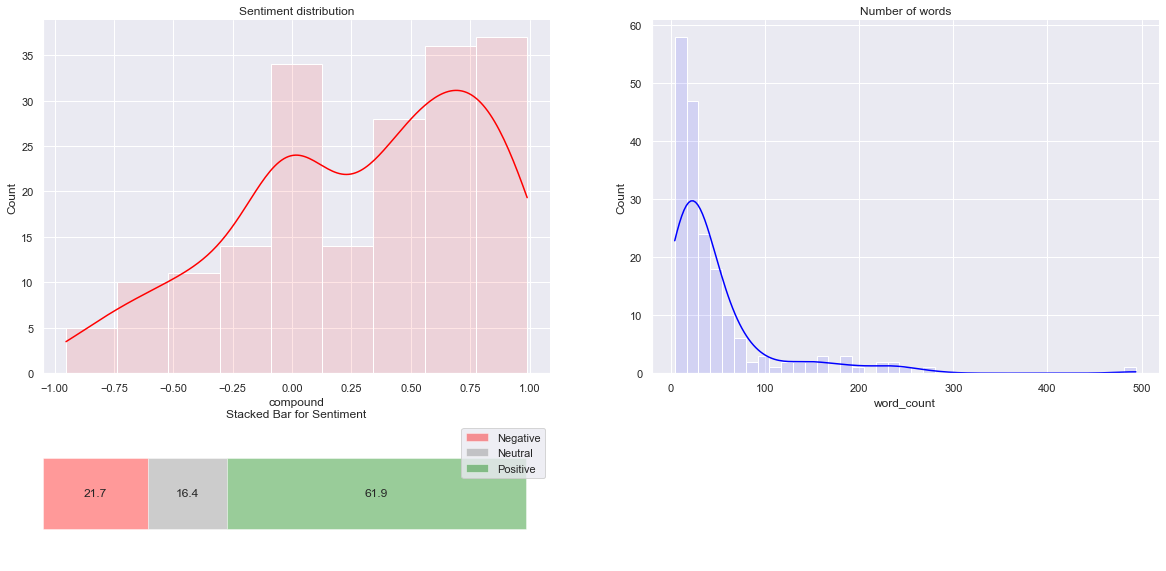

In [52]:
# Calculating the average sentiment for the Fuat 500 hybrid
print('Average compound for Fiat 500 hybrid:', round(np.mean(topic_senti_fiat500hybrid_yt.compound),3))
# Calculating the number of extremely positive or negative comments
print('Number of extremly positive comments (compound > 0.5):',round(sum(topic_senti_fiat500hybrid_yt.compound > 0.5)/topic_senti_fiat500hybrid_yt.shape[0],3)*100 ,'% with', sum(topic_senti_fiat500hybrid_yt.compound > 0.5), 'comments')
# Sentiment results exploration
sentiment_explor_yt(topic_senti_fiat500hybrid_yt,'Sentiment_corpus')

Average compound for Fiat 500 BEV: 0.351
Number of extremly positive comments (compound > 0.5): 46.0 % with 93 comments

    Data information
    --------------------------------------
    Total number of comments: 202
    Average lenght of each reply: 238.16 characters
    Average words per comment: 50.0 words
    
    Number of positive comments (compound >0.05) is 132 (65.3%)
    Number of negative comments (compound <-0.05) is 34 (16.8%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 36 (17.8%)
    
    --------------------------------------
    


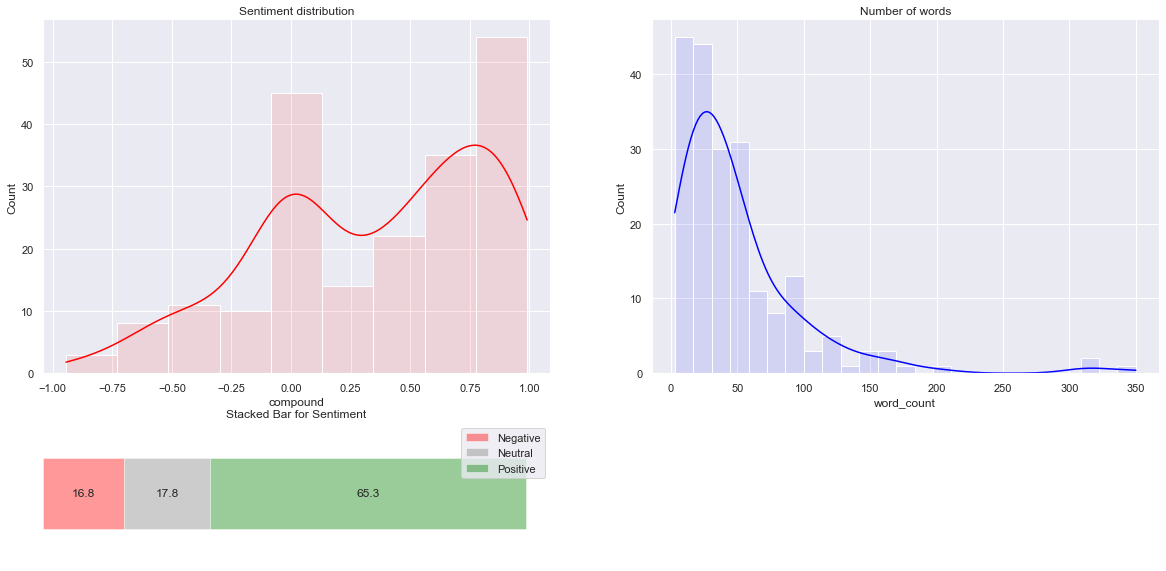

In [53]:
# Calculating the average sentiment for the Fuat 500 electric
print('Average compound for Fiat 500 BEV:', round(np.mean(topic_senti_fiat500e_yt.compound),3))
# Calculating the number of extremely positive or negative comments
print('Number of extremly positive comments (compound > 0.5):',round(sum(topic_senti_fiat500e_yt.compound > 0.5)/topic_senti_fiat500e_yt.shape[0],3)*100 ,'% with', sum(topic_senti_fiat500e_yt.compound > 0.5), 'comments')
# Sentiment results exploration
sentiment_explor_yt(topic_senti_fiat500e_yt,'Sentiment_corpus')

In [54]:
# Examining which topics are mostrly discussed in the extremely positive comments
topic_labels_dic_Q1 = {'Topic 1': 'Battery', 'Topic 2': 'Convenience', 'Topic 3': 'Design', 'Topic 4': 'Technical_Parts','Topic 5': 'Services_Issues',
                        'Topic 6': 'Driving_Behavior', 'Topic 7': 'Value_Money', 'Topic 8': 'Video_Comments', 'Topic 9': 'Price', 'Topic 10': 'Charging Stations'}
                        
## Examining the exremely positive comments
top_positive_500e = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['compound']>0.5]
print('For Fiat 500 electric')
print('---------------------')
top_positive_500e_no_video = top_positive_500e.loc[(top_positive_500e['Main_topic1']!= 'Topic 8') & (top_positive_500e['Main_topic2']!= 'Topic 8')]
print('Number of extremely positive comments:', top_positive_500e_no_video.shape[0])
top_positive_500e_no_video['Main_topic1'].replace(topic_labels_dic_Q1, inplace=True)
top_positive_500e_no_video['Main_topic2'].replace(topic_labels_dic_Q1, inplace=True)
print('Main Topic1')
print(top_positive_500e_no_video['Main_topic1'].value_counts())
print('Main Topic2')
print(top_positive_500e_no_video['Main_topic2'].value_counts())

For Fiat 500 electric
---------------------
Number of extremely positive comments: 69
Main Topic1
Driving_Behavior     19
Price                16
Battery              10
Design               10
Value_Money           5
Convenience           4
Charging Stations     3
Technical_Parts       1
Services_Issues       1
Name: Main_topic1, dtype: int64
Main Topic2
Design               17
Price                14
Driving_Behavior     10
Convenience          10
Battery               6
Services_Issues       4
Technical_Parts       3
Charging Stations     3
Value_Money           2
Name: Main_topic2, dtype: int64


In [55]:
# Examining which topics are mostrly discussed in the extremely positive comments
topic_labels_dic_Q1 = {'Topic 1': 'Battery', 'Topic 2': 'Convenience', 'Topic 3': 'Design', 'Topic 4': 'Technical_Parts','Topic 5': 'Services_Issues',
                        'Topic 6': 'Driving_Behavior', 'Topic 7': 'Value_Money', 'Topic 8': 'Video_Comments', 'Topic 9': 'Price', 'Topic 10': 'Charging Stations'}
                        
## Examining the exremely positive comments
top_positive_500h = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['compound']>0.5]
print('For Fiat 500 hybrid')
print('-------------------')
top_positive_500h_no_video = top_positive_500h.loc[(top_positive_500h['Main_topic1']!= 'Topic 8') & (top_positive_500h['Main_topic2']!= 'Topic 8')]
print('Number of extremely positive comments:', top_positive_500h_no_video.shape[0])
top_positive_500h_no_video['Main_topic1'].replace(topic_labels_dic_Q1, inplace=True)
top_positive_500h_no_video['Main_topic2'].replace(topic_labels_dic_Q1, inplace=True)
print('Main Topic1')
print(top_positive_500h_no_video['Main_topic1'].value_counts())
print('Main Topic2')
print(top_positive_500h_no_video['Main_topic2'].value_counts())

For Fiat 500 hybrid
-------------------
Number of extremely positive comments: 55
Main Topic1
Design               18
Convenience          12
Driving_Behavior      7
Services_Issues       6
Price                 4
Battery               3
Technical_Parts       2
Value_Money           2
Charging Stations     1
Name: Main_topic1, dtype: int64
Main Topic2
Services_Issues      11
Value_Money           9
Design                8
Convenience           7
Driving_Behavior      7
Charging Stations     4
Price                 4
Technical_Parts       3
Battery               2
Name: Main_topic2, dtype: int64


### Performing PMI for the main topic for the two models

In [56]:
def topic_pmi(df,column_name, numberbest=100):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, numberbest)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

#### Performing PMI for price topic

In [57]:
print('Analysis for Price')
print('===================')
print()

# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)

Analysis for Price

Number of words in the corpus: 2442
For Fiat 500e
[('hyundai', 'ioniq'), ('twin', 'air'), ('c', 'segment'), ('ioniq', '5'), ('entry', 'level'), ('e', 'vs'), ('great', 'review'), ('8', 'year'), ('how', 'cheap'), ('kwh', 'battery'), ('or', 'diesel'), ('honda', 'e'), ('000', 'km'), ('talk', 'about'), ('affordable', 'evs'), ('my', 'channel'), ('my', 'wife'), ('spec', '/'), ('000', 'euro'), ('too', 'expensive'), ('high', 'spec'), ('very', 'small'), ('petrol', 'or'), ('look', 'at'), ('will', 'lose'), ('live', 'with'), ('electric', 'vehicle'), ('could', 'get'), ('also', 'review'), ('£', '30'), ('ev', "'s"), ('cheap', 'they'), ('would', 'bring'), ('year', 'or'), ('in', 'california'), ('lack', 'of'), ('trade', 'in'), ('agree', 'with'), ('comparison', 'with'), ('we', 'need'), ('then', 'it'), ('an', 'abarth'), ('vs', 'fiat'), ('this', 'point'), ('wait', 'for'), ('segment', 'car'), ('as', 'well'), ('more', 'expensive'), ('so', 'much'), ('more', 'than'), ('I', 'wish'), ('in', 't

In [58]:
# Finding the number of bigrams and trigrams per model
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for electric
             Word  Freq
0       fiat 500e    17
1        fiat 500     9
2   electric fiat     4
3     review fiat     3
4      spec price     3
5        price ev     3
6    500 electric     3
7        new fiat     3
8    electric 500     3
9          000 km     3
10   500e channel     2
11      evs price     2
12      feel like     2
13     golf astra     2
14    entry level     2
15    segment car     2
16    price range     2
17      basic 500     2
18        ice car     2
19      small car     2
trigrmas for electric
                         Word  Freq
0            review fiat 500e     3
1           fiat 500e channel     2
2               spec price ev     2
3         affordable evs need     2
4           fiat 500 electric     2
5               honda vs fiat     2
6                vs fiat 500e     2
7           fiat 500e hyundai     2
8          500e hyundai ioniq     2
9      500e channel promising     1
10   channel promising strong     1
11  promising strong 

#### Performing PMI for price topic in extremely positive comments

In [59]:
# PMI for price for extreme
print('Analysis for Price')
print('===================')
print()

# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500e[top_positive_500e['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500h[top_positive_500h['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)

Analysis for Price

Number of words in the corpus: 1141
For Fiat 500e
[('twin', 'air'), ('c', 'segment'), ('affordable', 'evs'), ('how', 'cheap'), ('or', 'diesel'), ('8', 'year'), ('could', 'get'), ('my', 'channel'), ('spec', '/'), ('talk', 'about'), ('electric', 'vehicle'), ('petrol', 'or'), ('so', 'much'), ('000', 'km'), ('live', 'with'), ('cheap', 'they'), ('000', 'euro'), ('500', 'e'), ('£', '30'), ('ev', "'s"), ('we', 'need'), ('then', 'it'), ('segment', 'car'), ('lot', 'of'), ('more', 'than'), ('I', 'can'), ('an', 'electric'), ('at', 'this'), ('/', 'price'), ('easy', 'to'), ('to', 'live'), ('fiat', '500e'), ('£', '30k'), ('purchase', 'of'), ('would', 'have'), ('if', 'you'), ('a', 'c'), ('a', 'second'), ('a', 'very'), ('in', 'my'), ('to', 'buy'), ('to', 'go'), ('an', 'ev'), ('with', 'an'), ('about', '£'), ('it', 'would'), ('fiat', '500'), ('a', 'good'), ('get', 'a'), ('for', 'an'), ('enjoy', 'the'), ('the', 'idea'), ('they', 'be'), ('we', 'have'), ('be', 'still'), ('than', 'the'),

In [60]:
# Finding the number of bigrams and trigrams per model
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 9') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 9') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 9') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 9') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for electric
                Word  Freq
0          fiat 500e     6
1         spec price     3
2           price ev     3
3           fiat 500     3
4             000 km     3
5         golf astra     2
6        review fiat     2
7        segment car     2
8           twin air     2
9     affordable evs     2
10          evs need     2
11  electric vehicle     2
12     petrol diesel     2
13          000 euro     2
14    wandelen thing     1
15       thing price     1
16     price mention     1
17      mention golf     1
18        astra pure     1
19           pure ev     1
trigrmas for electric
                                Word  Freq
0                      spec price ev     2
1                   review fiat 500e     2
2                affordable evs need     2
3               wandelen thing price     1
4                thing price mention     1
5                 price mention golf     1
6                 mention golf astra     1
7                    golf astra pure     1
8  

#### Performing PMI for Design topic in extremely positive comments

In [61]:
# PMI for price for extreme
print('Analysis for Design')
print('===================')
print()

# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500e[top_positive_500e['Main_topic1']=='Topic 3'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500h[top_positive_500h['Main_topic1']=='Topic 3'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)

Analysis for Design

Number of words in the corpus: 572
For Fiat 500e
[('free', 'consultation'), ('our', 'vehicle'), ('journalist', 'when'), ('honda', 'e'), ('give', 'you'), ('much', 'more'), ('good', 'surprise'), ('lot', 'of'), ('of', 'our'), ('one', 'of'), ('happy', 'to'), ('so', 'good'), ('when', 'new'), ('fiat', '500e'), ('new', 'fiat'), ('review', 'of'), ('fiat', '500'), ('car', 'for'), ('car', 'with'), ('as', 'it'), ('but', 'I'), ('however', 'the'), ('the', 'old'), ('the', 'same'), ('a', 'nice'), ('it', 'be'), ('be', 'happy'), ('be', 'not'), ('range', 'be'), ('on', 'the'), ('with', 'a'), ('500e', 'it'), ('will', 'be'), ('a', 'new'), ('500e', 'be'), ('for', 'the'), ('look', 'the'), ('a', 'good'), ('of', 'a'), ('of', 'the'), ('be', 'a'), ('the', '500'), ('the', 'good'), ('the', 'fiat'), ('be', 'the')]
----------
[('of', 'our', 'vehicle'), ('one', 'of', 'our'), ('journalist', 'when', 'new'), ('a', 'good', 'surprise'), ('look', 'the', 'same'), ('new', 'fiat', '500'), ('be', 'happy', 

In [62]:
# Finding the number of bigrams and trigrams per model
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 3') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 3') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 3') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 3') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for electric
              Word  Freq
0        fiat 500e     6
1         fiat 500     5
2         new fiat     4
3        500e good     2
4    good surprise     2
5       drive fiat     2
6        500 great     2
7       range good     2
8   journalist new     2
9        nice cool     1
10       cool feel     1
11       feel like     1
12  like dimension     1
13    dimension go     1
14      go missing     1
15    missing turn     1
16        turn 500     1
17          500 ev     1
18        ev sound     1
19    sound engine     1
trigrmas for electric
                       Word  Freq
0              new fiat 500     3
1           drive fiat 500e     2
2            fiat 500 great     2
3            nice cool feel     1
4            cool feel like     1
5       feel like dimension     1
6         like dimension go     1
7      dimension go missing     1
8           go missing turn     1
9          missing turn 500     1
10              turn 500 ev     1
11             500 ev so

In [63]:
# PMI for price for extreme
print('Analysis for Driving Behavior')
print('===================')
print()

# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500e[top_positive_500e['Main_topic1']=='Topic 6'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = top_positive_500h[top_positive_500h['Main_topic1']=='Topic 6'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)

Analysis for Driving Behavior

Number of words in the corpus: 1452
For Fiat 500e
[('huge', 'impression'), ('la', 'prima'), ('immediately', 'place'), ('twingo', 'gt'), ('every', 'day'), ('later', 'this'), ('range', 'mode'), ('one', 'pedal'), ('pedal', 'range'), ('honda', 'e'), ('extended', 'test'), ('although', 'not'), ('an', 'extended'), ('last', 'week'), ('month', 'ago'), ('place', 'an'), ('hand', 'on'), ('my', 'twingo'), ('would', 'say'), ('fun', 'as'), ('this', 'month'), ('of', 'these'), ('would', 'like'), ('an', 'order'), ('on', 'order'), ('want', 'to'), ('test', 'drive'), ('do', 'not'), ('500e', 'when'), ('around', 'an'), ('in', 'january'), ('now', 'as'), ('you', 'show'), ('it', 'play'), ('back', 'of'), ('one', 'of'), ('their', 'car'), ('to', 'try'), ('you', 'can'), ('500e', 'last'), ('a', 'few'), ('a', 'huge'), ('a', 'small'), ('fiat', '500e'), ('lounge', 'and'), ('because', 'it'), ('try', 'it'), ('the', 'next'), ('the', 'back'), ('can', 'you'), ('if', 'you'), ('I', "'ve"), ('wit

In [64]:
# Finding the number of bigrams and trigrams per model

print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 6') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500e[(top_positive_500e['Main_topic1']=='Topic 6') & (top_positive_500e['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 6') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(top_positive_500h[(top_positive_500h['Main_topic1']=='Topic 6') & (top_positive_500h['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for electric
                 Word  Freq
0          test drive     8
1           fiat 500e     4
2          drive 500e     3
3           500e week     3
4           twingo gt     3
5         pedal range     3
6          range mode     3
7       extended test     2
8     huge impression     2
9            think go     2
10      500e consider     2
11        drive honda     2
12          want test     2
13        later month     2
14         week pedal     2
15  immediately place     2
16        place order     2
17          month ago     2
18           la prima     2
19        bring smile     1
trigrmas for electric
                          Word  Freq
0              test drive 500e     3
1              drive 500e week     3
2             pedal range mode     3
3          extended test drive     2
4           fiat 500e consider     2
5              500e week pedal     2
6             week pedal range     2
7      immediately place order     2
8             bring smile face     1

In [65]:
# Combine the two datasets
topic_sentiment_fiat_combined = pd.concat([topic_senti_fiat500e_yt,topic_senti_fiat500hybrid_yt], axis=0)

In [66]:
# calculate the weighted average of sentiment compound for topics
from numpy import average
def weighted_avg(df):
    weighted_avg_sentiment={}
    for i in df.columns.values[0:k+1]:
        weighted_avg_topic= round(average(df['compound'], weights = df[i]),3)
        weighted_avg_sentiment[i] = weighted_avg_topic
        weighted_avg_sentiment= pd.Series(weighted_avg_sentiment)
    return weighted_avg_sentiment

In [67]:
# Labeling the topics
topic_labels = ['Battery','Charging Stations','Convenience','Design','Technical_Parts','Services_Issues',
                'Driving_Behavior','Value_Money','Video_Comments','Price']

In [68]:
# For Fiat 500 electric

# Find the number of main topics discued in the comments that mention fiat 500 hybrid
topics_per_comment_fiat500h = topic_senti_fiat500hybrid_yt['Main_topic1'].value_counts()

# Find the number of main topics discued in the comments that mention fiat 500 hybrid 
topics2_per_comment_fiat500h = topic_senti_fiat500hybrid_yt['Main_topic2'].value_counts()

# Find the average probabilty of each topic to appear in the corpus of fiat 500 hybrid
topics_prob_fiat500h = topic_senti_fiat500hybrid_yt[list(topic_senti_fiat500hybrid_yt.columns.values)].mean()[:10]

# Finding the average sentiment of each topic for the comments that mention fiat 500 hybrid
weighted_avg_senti_fiat500h = weighted_avg(df = topic_senti_fiat500hybrid_yt)

# Finding the total occurances of each topic for the comments that mention 500 hybrid
total_topics_per_comment_fiat500h = topics_per_comment_fiat500h + topics2_per_comment_fiat500h

# Finding the percentage of total occurances of each topic for the comments that mention 500 hybrid
percentage_topics_per_comment_fiat500h = round(total_topics_per_comment_fiat500h/ topic_senti_fiat500hybrid_yt.shape[0],2)

fiat_500h_results = pd.DataFrame([total_topics_per_comment_fiat500h, percentage_topics_per_comment_fiat500h, topics_per_comment_fiat500h, topics2_per_comment_fiat500h , topics_prob_fiat500h, weighted_avg_senti_fiat500h]).T
fiat_500h_results = fiat_500h_results.rename(columns={'Unnamed 0': 'Topic_Appearance', 'Unnamed 1': 'Topic_Percentage', 'Unnamed 2': 'Average_Topic_Prob', 'Unnamed 3': 'Average_Sentiment'})

# Find the sentiment for each topic
for topic in fiat_500h_results.index:
    temp = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt[topic]!=0]['sentiment'].value_counts()
    if topic == fiat_500h_results.index[0]:
        sentiments_500h = temp
    else:
        sentiments_500h = pd.concat([sentiments_500h, temp], axis=1)

sentiments_500h = sentiments_500h.T.set_index(fiat_500h_results.index)

fiat_500h_results = pd.concat([fiat_500h_results, sentiments_500h], axis=1)
fiat_500h_results['Positive_Percentage'] = fiat_500h_results.pos / (fiat_500h_results.pos + fiat_500h_results.neu + fiat_500h_results.neg)
fiat_500h_results['Average_Sentiment_Whole'] = weighted_avg(df = topic_sentiment)
fiat_500h_results

,Topic_Appearance,Topic_Percentage,Main_topic1,Main_topic2,Average_Topic_Prob,Average_Sentiment,pos,neg,neu,Positive_Percentage,Average_Sentiment_Whole
Topic 1,16.0,0.08,9.0,7.0,0.045221,0.306,12,3,1,0.750000,0.202
Topic 10,21.0,0.11,9.0,12.0,0.054354,0.185,12,6,3,0.571429,0.190
Topic 2,36.0,0.19,19.0,17.0,0.100378,0.435,25,5,6,0.694444,0.383
Topic 3,99.0,0.52,64.0,35.0,0.269130,0.234,54,25,20,0.545455,0.250
Topic 4,19.0,0.10,8.0,11.0,0.045940,0.076,9,8,2,0.473684,0.079
Topic 5,33.0,0.17,16.0,17.0,0.088476,0.434,25,5,3,0.757576,0.124
Topic 6,30.0,0.16,12.0,18.0,0.077850,0.429,23,5,2,0.766667,0.332
Topic 7,33.0,0.17,13.0,20.0,0.080832,0.257,22,6,5,0.666667,0.216
Topic 8,52.0,0.28,21.0,31.0,0.131420,0.389,34,9,9,0.653846,0.343
Topic 9,39.0,0.21,18.0,21.0,0.106400,0.153,18,10,11,0.461538,0.210


In [69]:
# For Fiat 500 electric Summary results

# Find the number of main topics discued in the comments that mentions fiat 500e
topics_per_comment_fiat500e = topic_senti_fiat500e_yt['Main_topic1'].value_counts()

# Find the number of main topics discued in the comments that mentions fiat 500e
topics2_per_comment_fiat500e = topic_senti_fiat500e_yt['Main_topic2'].value_counts()

# Find the average probabilty of each topic to appear in the corpus of fiat 500e
topics_prob_fiat500e = topic_senti_fiat500e_yt[list(topic_senti_fiat500e_yt.columns.values)].mean()[:10]

# Finding the average sentiment of each topic for the comments that mentions fiat 500e
weighted_avg_senti_fiat500e = weighted_avg(df = topic_senti_fiat500e_yt) 

# Finding the total occurances of each topic for the comments that mention 500e
total_topics_per_comment_fiat500e = topics_per_comment_fiat500e + topics2_per_comment_fiat500e

# Finding the perecentage of total occurances of each topic for the comments that mention 500e
percentage_topics_per_comment_fiat500e = round(total_topics_per_comment_fiat500e/ topic_senti_fiat500e_yt.shape[0],2)

fiat_500e_results = pd.DataFrame([total_topics_per_comment_fiat500e, percentage_topics_per_comment_fiat500e, topics_per_comment_fiat500e, topics2_per_comment_fiat500e , topics_prob_fiat500e, weighted_avg_senti_fiat500e]).T
fiat_500e_results = fiat_500e_results.rename(columns={'Unnamed 0': 'Topic_Appearance', 'Unnamed 1': 'Topic_Percentage', 'Unnamed 2': 'Average_Topic_Prob', 'Unnamed 3': 'Average_Sentiment'})

# Find the sentiment for each topic
for topic in fiat_500e_results.index:
    temp = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt[topic]!=0]['sentiment'].value_counts()
    if topic == fiat_500e_results.index[0]:
        sentiments_500e = temp
    else:
        sentiments_500e = pd.concat([sentiments_500e, temp], axis=1)

sentiments_500e = sentiments_500e.T.set_index(fiat_500e_results.index)

fiat_500e_results = pd.concat([fiat_500e_results, sentiments_500e], axis=1)
fiat_500e_results['Positive_Percentage'] = fiat_500e_results.pos / (fiat_500e_results.pos + fiat_500e_results.neu + fiat_500e_results.neg)
fiat_500e_results['Average_Sentiment_Whole'] = weighted_avg(df = topic_sentiment)
fiat_500e_results

,Topic_Appearance,Topic_Percentage,Main_topic1,Main_topic2,Average_Topic_Prob,Average_Sentiment,pos,neg,neu,Positive_Percentage,Average_Sentiment_Whole
Topic 1,32.0,0.16,20.0,12.0,0.086912,0.372,22,7,3,0.687500,0.202
Topic 10,22.0,0.11,11.0,11.0,0.050509,0.361,14,2,6,0.636364,0.190
Topic 2,24.0,0.12,7.0,17.0,0.051639,0.535,20,2,2,0.833333,0.383
Topic 3,77.0,0.38,38.0,39.0,0.179351,0.310,47,11,19,0.610390,0.250
Topic 4,11.0,0.05,3.0,8.0,0.025423,0.269,8,2,1,0.727273,0.079
Topic 5,14.0,0.07,4.0,10.0,0.032823,0.158,8,5,1,0.571429,0.124
Topic 6,56.0,0.28,31.0,25.0,0.151573,0.475,42,8,6,0.750000,0.332
Topic 7,32.0,0.16,14.0,18.0,0.077787,0.248,18,7,7,0.562500,0.216
Topic 8,41.0,0.20,20.0,21.0,0.092676,0.555,30,1,10,0.731707,0.343
Topic 9,95.0,0.47,54.0,41.0,0.251307,0.249,55,23,17,0.578947,0.210


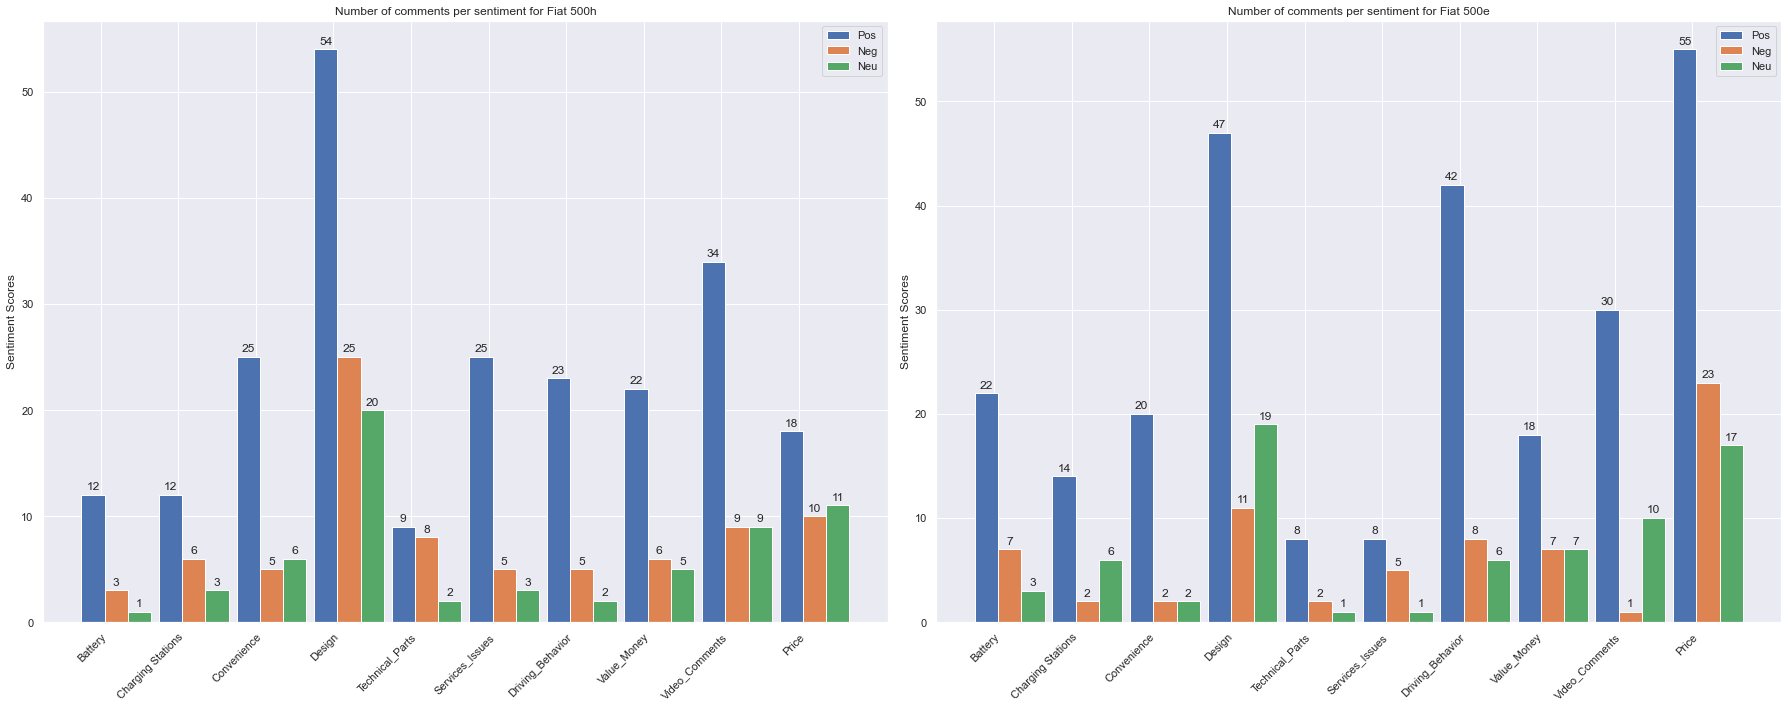

In [70]:
# Visualising the results per sentiment

labels = ['Battery', 'Charging Stations', 'Convenience' ,'Design',
          'Technical_Parts','Services_Issues','Driving_Behavior',
          'Value_Money','Video_Comments','Price']

x = np.arange(fiat_500h_results.shape[0])  # the label locations
width = 0.30  # the width of the bar

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

## Add the plot for hybrid
rects1 = ax1.bar(x - width/3, fiat_500h_results['pos'], width, label='Pos')
rects2 = ax1.bar(x + width/3+0.1, fiat_500h_results['neg'], width, label='Neg')
rects3 = ax1.bar(x + width/3+0.4, fiat_500h_results['neu'], width, label='Neu')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Sentiment Scores')
ax1.set_title('Number of comments per sentiment for Fiat 500h')
ax1.set_xticks(x, labels)
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)
ax1.bar_label(rects3, padding=3)

## Add the plot for electric
rects1e = ax2.bar(x - width/3, fiat_500e_results['pos'], width, label='Pos')
rects2e = ax2.bar(x + width/3+0.1, fiat_500e_results['neg'], width, label='Neg')
rects3e = ax2.bar(x + width/3+0.4, fiat_500e_results['neu'], width, label='Neu')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Sentiment Scores')
ax2.set_title('Number of comments per sentiment for Fiat 500e')
ax2.set_xticks(x, labels)
ax2.legend()

ax2.bar_label(rects1e, padding=3)
ax2.bar_label(rects2e, padding=3)
ax2.bar_label(rects3e, padding=3)

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
         
fig.tight_layout()

plt.show()

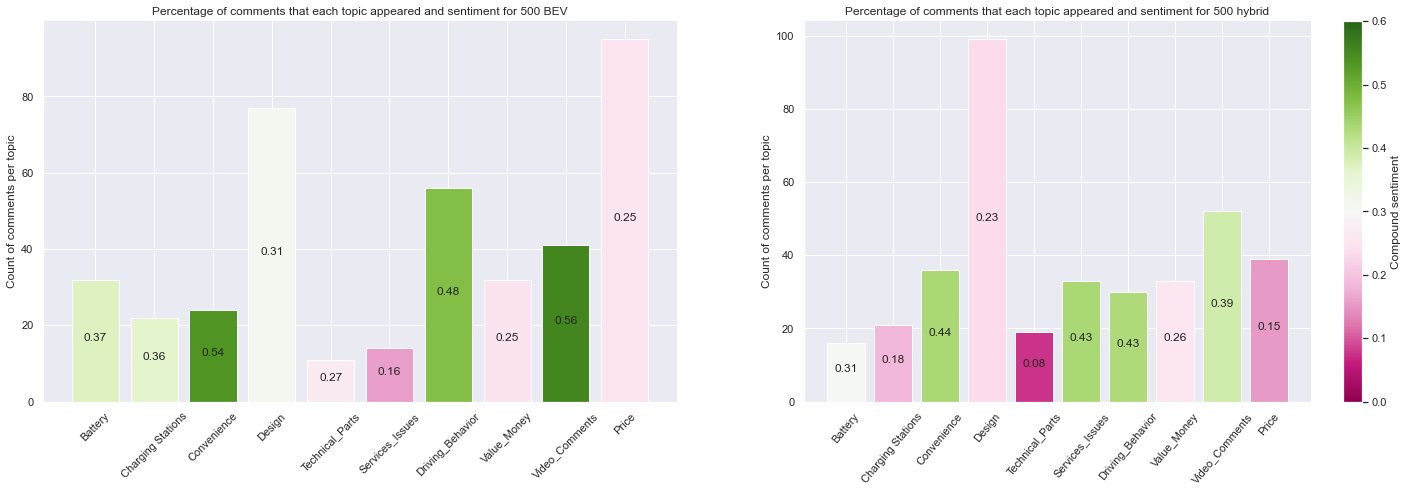

In [71]:
# Ploting the average compound score pre topic
fig = plt.figure(figsize = (25,7))
ax = fig.add_subplot(1,2,1)

height = fiat_500e_results['Topic_Appearance']
sentiment = fiat_500e_results['Average_Sentiment']
bars = fiat_500e_results.index
y_pos = np.arange(len(bars))

cmap = plt.cm.PiYG
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.6)

# Create bars
ax.bar(y_pos, height, color=cmap(norm(fiat_500e_results['Average_Sentiment'])))

def add_value_label(x_list,y_place, y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_place[i]/2,round(y_list[i],2), ha="center")
add_value_label(y_pos, height ,sentiment)

#add_value_label(y_pos,height)
ax.set_title("Percentage of comments that each topic appeared and sentiment for 500 BEV")

# Create names on the x-axis
ax.set_xticks(y_pos, topic_labels,rotation = 45)
ax.set_ylabel("Count of comments per topic")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1 = fig.add_subplot(1,2,2)
height1 = fiat_500h_results['Topic_Appearance']
sentiment1 = fiat_500h_results['Average_Sentiment']

# Create bars
ax1.bar(y_pos, height1, color=cmap(norm(fiat_500h_results['Average_Sentiment'])))
add_value_label(y_pos, height1 ,sentiment1)

#add_value_label(y_pos,height)
ax1.set_title("Percentage of comments that each topic appeared and sentiment for 500 hybrid")

# Create names on the x-axis
ax1.set_xticks(y_pos, topic_labels,rotation = 50)
ax1.set_ylabel("Count of comments per topic")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Compound sentiment')

# Show graphic
plt.show()

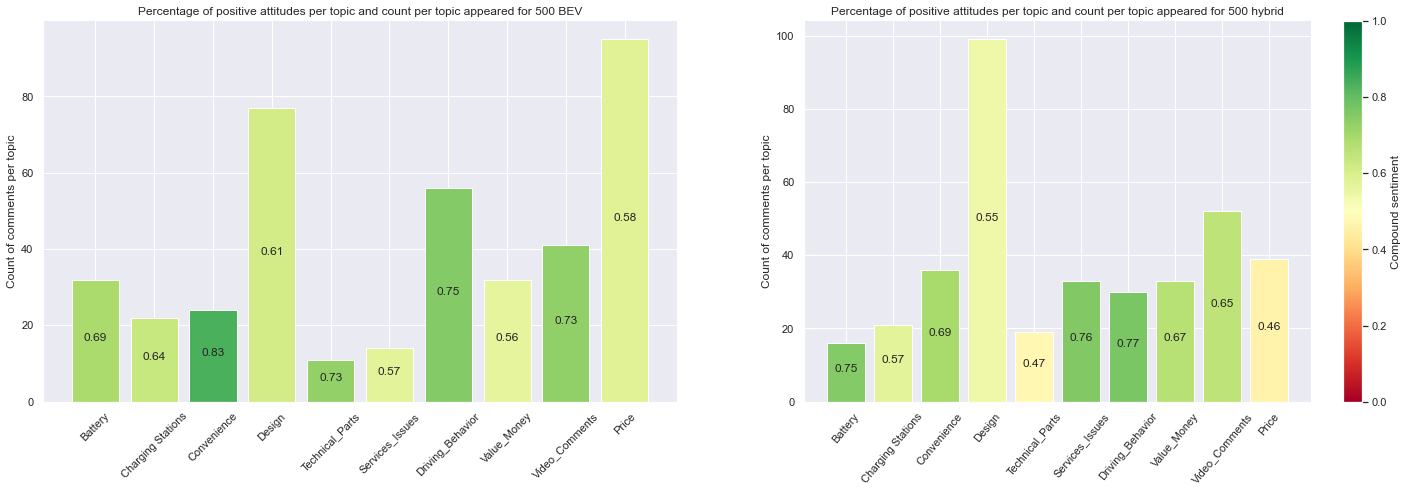

In [72]:
# Ploting the average positive percentage of comments pre topic
fig = plt.figure(figsize = (25,7))
ax = fig.add_subplot(1,2,1)

height = fiat_500e_results['Topic_Appearance']
sentiment = fiat_500e_results['Positive_Percentage']
bars = fiat_500e_results.index
y_pos = np.arange(len(bars))

cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)


# Create bars
ax.bar(y_pos, height, color=cmap(norm(fiat_500e_results['Positive_Percentage'])))

def add_value_label(x_list,y_place, y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_place[i]/2,round(y_list[i],2), ha="center")
add_value_label(y_pos, height ,sentiment)

#add_value_label(y_pos,height)
ax.set_title("Percentage of positive attitudes per topic and count per topic appeared for 500 BEV")

# Create names on the x-axis
ax.set_xticks(y_pos, topic_labels,rotation = 45)
ax.set_ylabel("Count of comments per topic")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1 = fig.add_subplot(1,2,2)
height1 = fiat_500h_results['Topic_Appearance']
sentiment1 = fiat_500h_results['Positive_Percentage']

# Create bars
ax1.bar(y_pos, height1, color=cmap(norm(fiat_500h_results['Positive_Percentage'])))
add_value_label(y_pos, height1 ,sentiment1)

#add_value_label(y_pos,height)
ax1.set_title("Percentage of positive attitudes per topic and count per topic appeared for 500 hybrid")

# Create names on the x-axis
ax1.set_xticks(y_pos, topic_labels,rotation = 50)
ax1.set_ylabel("Count of comments per topic")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Compound sentiment')

# Show graphic
plt.show()

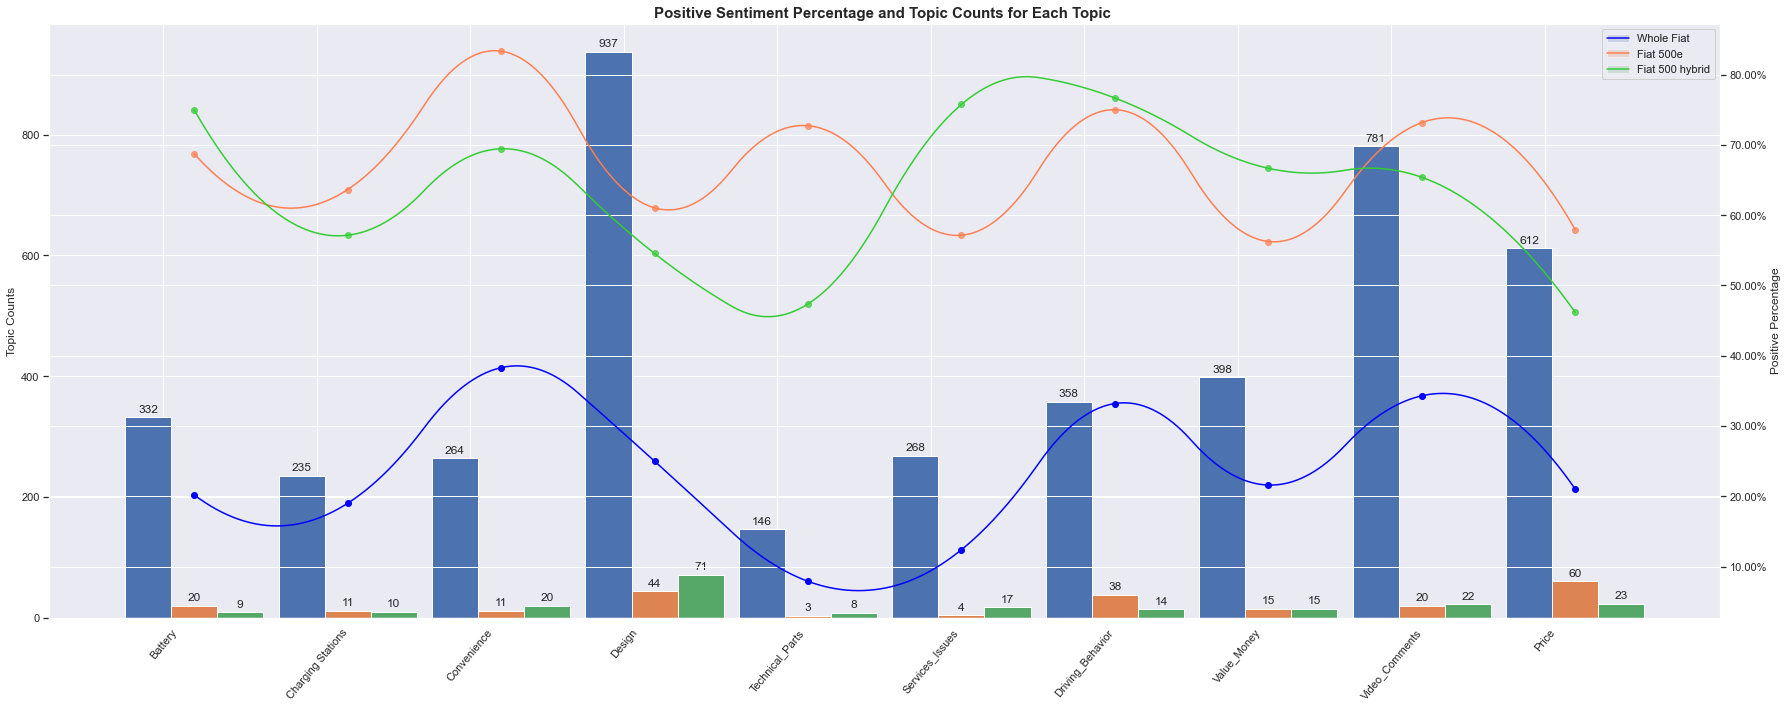

In [73]:
# Visualising the results per sentiment

topics_y = topic_sentiment.groupby('Main_topic1')['Topic 1'].count().values


x = np.arange(fiat_500e_results.shape[0])  # the label locations
x_pos = np.arange(0,fiat_500e_results.shape[0])
width = 0.30  # the width of the bar

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1,1,1)

# fiat
topics_fiate = topic_sentiment[topic_sentiment['fiat500_e']==1].groupby('Main_topic1')['time_updated'].count().values
# renault
topics_fiath = topic_sentiment[topic_sentiment['fiat500_hybrid']==1].groupby('Main_topic1')['time_updated'].count().values

## Add the plot for hybrid
rects1 = ax1.bar(x - width/3, topics_y, width, label='Whole Fiat')
rects2 = ax1.bar(x + width/3+0.1, topics_fiate, width, label='Fiat 500e')
rects3 = ax1.bar(x + width/3+0.4, topics_fiath, width, label='Fiat 500 hybrid')

ax2 = ax1.twinx()
ax2.scatter(x + width/3+0.1 ,fiat_500e_results['Average_Sentiment_Whole'],  color = 'blue', alpha =1)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500e_results['Average_Sentiment_Whole']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'blue', label='Whole Fiat')

ax2.scatter(x + width/3+0.1,fiat_500e_results['Positive_Percentage'],  color = 'coral', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500e_results['Positive_Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'coral', label='Fiat 500e')

ax2.scatter(x + width/3+0.1,fiat_500h_results['Positive_Percentage'],  color = 'limegreen', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1,fiat_500h_results['Positive_Percentage'] ], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'limegreen', label='Fiat 500 hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Topic Counts')
ax2.set_ylabel('Positive Percentage')

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax1.set_title('Positive Sentiment Percentage and Topic Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})
ax1.set_xticks(y_pos, topic_labels,rotation = 50)
ax1.legend()
ax2.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)
ax1.bar_label(rects3, padding=3)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
         
fig.tight_layout()

plt.show()

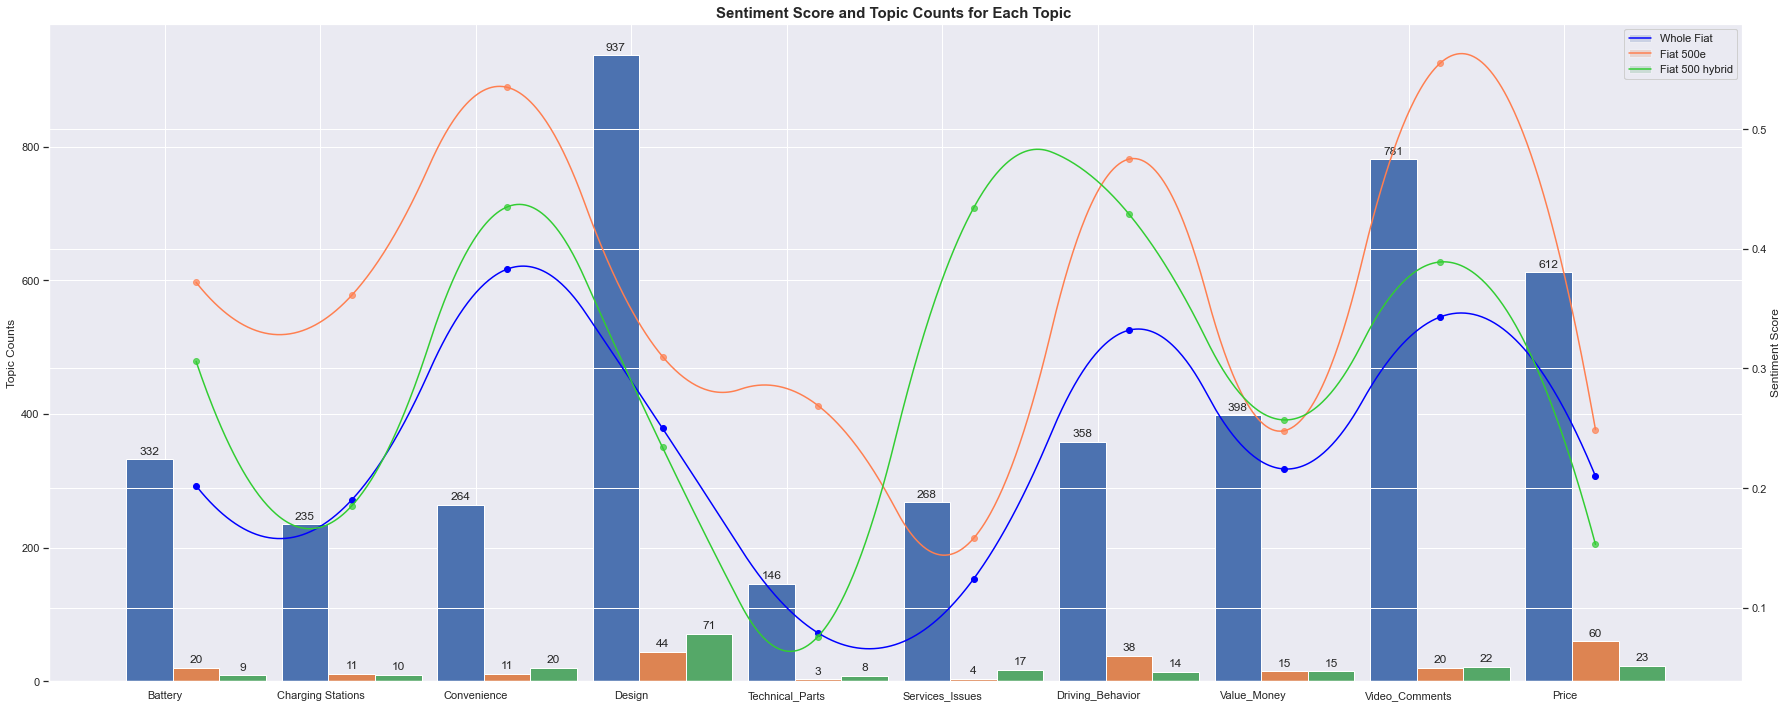

In [74]:
# Visualising the results per sentiment

topics_y = topic_sentiment.groupby('Main_topic1')['Topic 1'].count().values


x = np.arange(fiat_500e_results.shape[0])  # the label locations
x_pos = np.arange(0,fiat_500e_results.shape[0])
width = 0.30  # the width of the bar

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1,1,1)

# fiat
topics_fiate = topic_sentiment[topic_sentiment['fiat500_e']==1].groupby('Main_topic1')['time_updated'].count().values
# renault
topics_fiath = topic_sentiment[topic_sentiment['fiat500_hybrid']==1].groupby('Main_topic1')['time_updated'].count().values

## Add the plot for hybrid
rects1 = ax1.bar(x - width/3, topics_y, width, label='Whole Fiat')
rects2 = ax1.bar(x + width/3+0.1, topics_fiate, width, label='Fiat 500e')
rects3 = ax1.bar(x + width/3+0.4, topics_fiath, width, label='Fiat 500 hybrid')

ax2 = ax1.twinx()
ax2.scatter(x + width/3+0.1 ,fiat_500e_results['Average_Sentiment_Whole'],  color = 'blue', alpha =1)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500e_results['Average_Sentiment_Whole']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'blue', label='Whole Fiat')

ax2.scatter(x + width/3+0.1,fiat_500e_results['Average_Sentiment'],  color = 'coral', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500e_results['Average_Sentiment']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'coral', label='Fiat 500e')

ax2.scatter(x + width/3+0.1,fiat_500h_results['Average_Sentiment'],  color = 'limegreen', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1,fiat_500h_results['Average_Sentiment'] ], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'limegreen', label='Fiat 500 hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Topic Counts')
ax2.set_ylabel('Sentiment Score')

vals = ax2.get_yticks()
ax2.set_yticklabels([round(x,2) for x in vals])

ax1.set_title('Sentiment Score and Topic Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})
ax1.set_xticks(x, topic_labels)
ax1.legend()
ax2.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)
ax1.bar_label(rects3, padding=3)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
         
fig.tight_layout()

plt.show()

### Time series sentiment 

In [75]:
def plot_timeseries_sentiment(df, title):
    # Plot Mentioned Counts Top 5 
    fig = plt.figure(figsize = (20,8), facecolor = None)
    ax = fig.add_subplot()
    plt.plot(df['date'],df["compound"], label = 'compound', marker='o',c= 'blue')  
    plt.plot(df['date'],df["Topic 1"], marker='o',label = topic_labels[0], c= 'green',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 2"], marker='o',label = topic_labels[1], c= 'firebrick',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 3"], marker='o',label = topic_labels[2], c= 'lightblue',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 4"], marker='o',label = topic_labels[3], c= 'darkorange',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 5"], marker='o',label = topic_labels[4], c= 'lightcoral',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 6"], marker='o',label = topic_labels[5], c= 'grey',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 7"], marker='o',label = topic_labels[6], c= 'blue',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 8"], marker='o',label = topic_labels[7], c= 'limegreen',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 9"], marker='o',label = topic_labels[8], c= 'salmon',ls ='--',alpha = 0.8)
    plt.plot(df['date'],df["Topic 10"], marker='o',label = topic_labels[9], c= 'purple',ls ='--',alpha = 0.8)

    # Labelling 
    plt.xlabel("Discussion Date")
    plt.ylabel("Sentiment Scores")
    plt.title(title)
    plt.xticks(rotation = 45)

    # Display
    ## aest
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


    plt.legend()
    plt.show()
    

In [76]:
# Preparing the data for visualisation
df_time_sentiment = topic_sentiment.copy()
for topic in topic_sentiment.columns[:10].to_list():
    df_time_sentiment.loc[:,topic] = topic_sentiment[topic] * topic_sentiment['compound']

df_time_sentiment['time_updated']= pd.to_datetime(topic_sentiment['time_updated'])

df_time_sentiment['month_update'] = df_time_sentiment['time_updated'].dt.month
df_time_sentiment['year_update'] = df_time_sentiment['time_updated'].dt.year

df_time = pd.DataFrame(df_time_sentiment.groupby(['year_update', 'month_update'], as_index=False)['compound'].aggregate(np.mean))

df_time_topic = pd.DataFrame(df_time_sentiment.groupby(['year_update', 'month_update'], as_index=False)['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10'].aggregate(np.mean))

df_time.loc[:,'date'] = df_time['month_update'].astype(int).astype(str)+ '-' +df_time['year_update'].astype(int).astype(str)
df_time_topic.loc[:,'date'] = df_time_topic['month_update'].astype(int).astype(str)+ '-' +df_time_topic['year_update'].astype(int).astype(str)

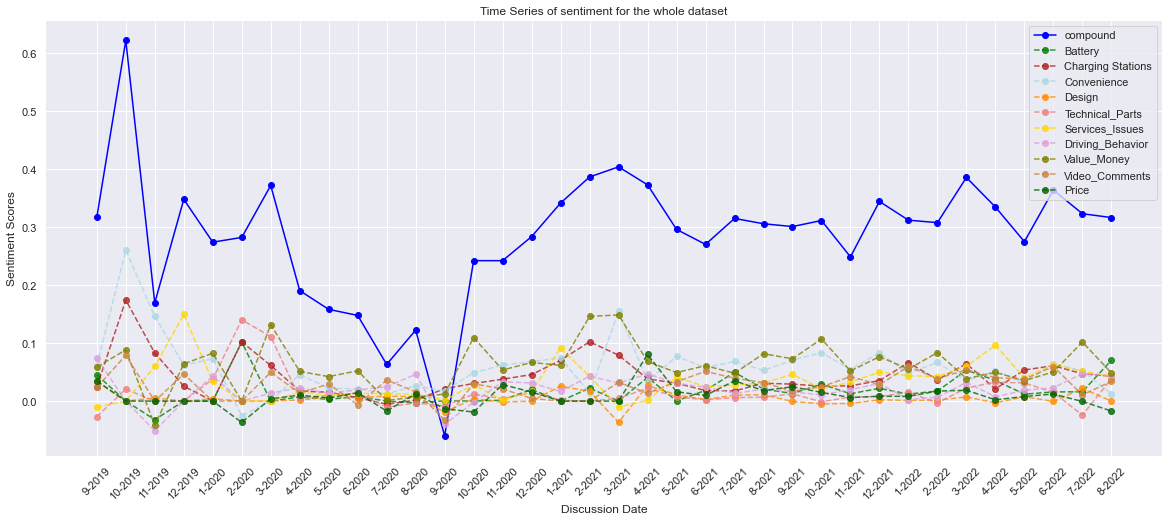

In [77]:
# Plot Mentioned Counts Top 5 
fig = plt.figure(figsize = (20,8), facecolor = None)
ax = fig.add_subplot()
plt.plot(df_time['date'],df_time["compound"], label = 'compound', marker='o',c= 'blue')  
plt.plot(df_time_topic['date'],df_time_topic["Topic 1"], marker='o',label = topic_labels[0], c= 'green',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 2"], marker='o',label = topic_labels[1], c= 'firebrick',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 3"], marker='o',label = topic_labels[2], c= 'lightblue',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 4"], marker='o',label = topic_labels[3], c= 'darkorange',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 5"], marker='o',label = topic_labels[4], c= 'lightcoral',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 6"], marker='o',label = topic_labels[5], c= 'gold',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 7"], marker='o',label = topic_labels[6], c= 'plum',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 8"], marker='o',label = topic_labels[7], c= 'olive',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 9"], marker='o',label = topic_labels[8], c= 'peru',ls ='--',alpha = 0.8)
plt.plot(df_time_topic['date'],df_time_topic["Topic 10"], marker='o',label = topic_labels[9], c= 'darkgreen',ls ='--',alpha = 0.8)

# Labelling 
plt.xlabel("Discussion Date")
plt.ylabel("Sentiment Scores")
plt.title("Time Series of sentiment for the whole dataset")
plt.xticks(rotation = 45)

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.legend()
plt.show()

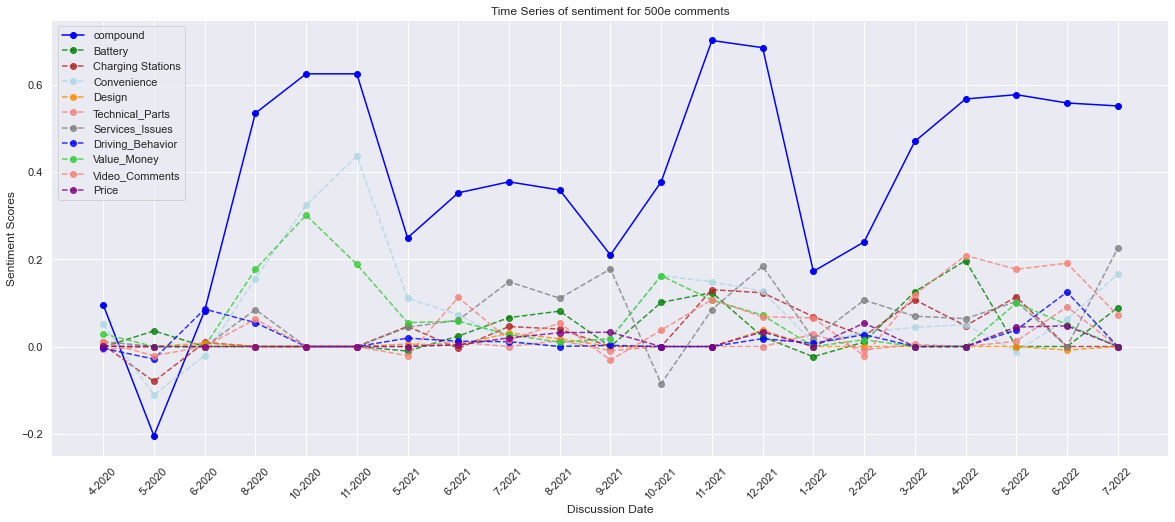

In [78]:
# Separate the comments only for fiat 500e
df_time_500e =  df_time_sentiment[df_time_sentiment['fiat500_e']==1]

# Create the table to visualise
df_time_topic_500e = pd.DataFrame(df_time_500e.groupby(['year_update', 'month_update'], as_index=False)['compound','Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10'].aggregate(np.mean))

df_time_topic_500e.loc[:,'date'] = df_time_topic_500e['month_update'].astype(int).astype(str)+ '-' +df_time_topic_500e['year_update'].astype(int).astype(str)

plot_timeseries_sentiment(df_time_topic_500e, "Time Series of sentiment for 500e comments")

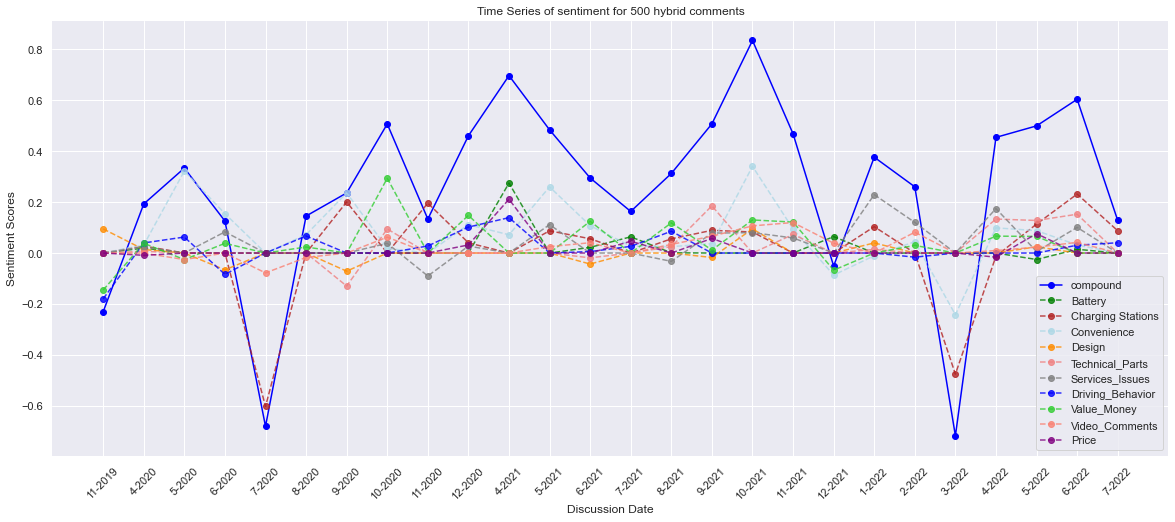

In [79]:
# Separate the comments only for fiat 500 hybrid
df_time_500h =  df_time_sentiment[df_time_sentiment['fiat500_hybrid']==1]

# Create the table to visualise
df_time_topic_500h = pd.DataFrame(df_time_500h.groupby(['year_update', 'month_update'], as_index=False)['compound','Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10'].aggregate(np.mean))

df_time_topic_500h.loc[:,'date'] = df_time_topic_500h['month_update'].astype(int).astype(str)+ '-' +df_time_topic_500h['year_update'].astype(int).astype(str)

plot_timeseries_sentiment(df_time_topic_500h, "Time Series of sentiment for 500 hybrid comments")

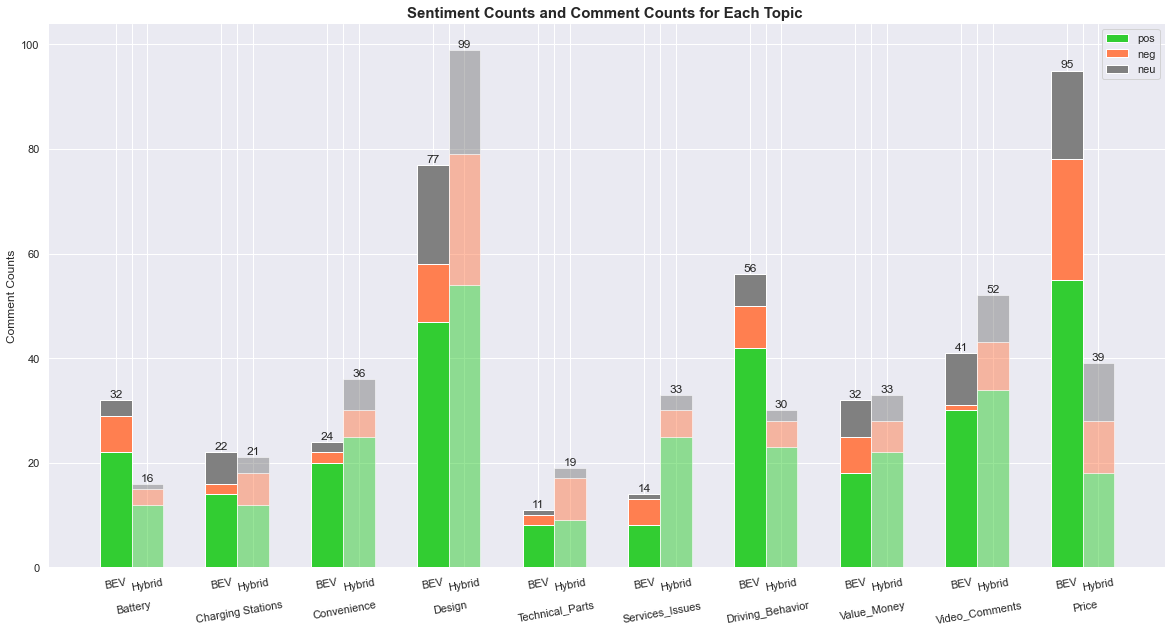

In [80]:
# Visualising the count of pos, neg and neu per topic

sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.30

x = list()
ind = np.arange(len(fiat_500e_results))   # Number of topics
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

#temp_combined = topic_senti_combined.iloc[:,2:5]
temp_bev= fiat_500e_results.iloc[:,6:9]
temp_hybrid = fiat_500h_results.iloc[:,6:9]

#bev
ax.bar(ind, temp_bev[sentiment_labels[0]], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_bev[sentiment_labels[1]], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_bev[sentiment_labels[0]] ,alpha = 1)
ax.bar(ind, temp_bev[sentiment_labels[2]], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_bev[sentiment_labels[0]] + temp_bev[sentiment_labels[1]],alpha =1 )

bev_count = fiat_500e_results.iloc[:,6:9].sum(axis=1)
hybrid_count =  fiat_500h_results.iloc[:,6:9].sum(axis=1)

for a, b in zip(ind, bev_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)
for a, b in zip(ind+width, hybrid_count):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)

#hybrid
ax.bar(ind+width, temp_hybrid[sentiment_labels[0]], width,  color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_hybrid[sentiment_labels[1]], width,  color = colors[1],bottom=  temp_hybrid[sentiment_labels[0]] , alpha = 0.5)
ax.bar(ind+width, temp_hybrid[sentiment_labels[2]], width,  color = colors[2],bottom=  temp_hybrid[sentiment_labels[0]] + temp_hybrid[sentiment_labels[1]], alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Comment Counts")
plt.xticks(x)

ax.set_xticklabels(('BEV','\n\nBattery', 'Hybrid', 'BEV','\n\nCharging Stations', 'Hybrid',
                    'BEV','\n\nConvenience', 'Hybrid','BEV','\n\nDesign', 'Hybrid',
                    'BEV','\n\nTechnical_Parts', 'Hybrid','BEV','\n\nServices_Issues', 'Hybrid',
                    'BEV','\n\nDriving_Behavior', 'Hybrid','BEV','\n\nValue_Money', 'Hybrid',
                    'BEV','\n\nVideo_Comments', 'Hybrid', 'BEV','\n\nPrice', 'Hybrid'),ha='center',rotation = 10)

ax.set_title('Sentiment Counts and Comment Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})

plt.legend()

#### Topics per month on Youtube

In [81]:
def topics_per_month_yt(df, column_name1, column_name2, topic_labels, n_topics):

   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','peru']

   width = 20

   df['date'] = pd.to_datetime(df['time_updated'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
   df = df.loc[df['month_year'].between('2020-01','2022-08', inclusive=True)]
   df = df.loc[(df[column_name1] ==1) & (df[column_name2] !=1)]

   topics_df = pd.DataFrame()
   topics_df['month_year'] = df['month_year']
   topics_df['Main_topic1'] = df['Main_topic1']
   topics_df['count'] = 1

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.columns = topic_labels
   # sns.set_style("whitegrid")
   fig = plt.figure(figsize=(20, 10))
   ax = fig.add_subplot(1, 1, 1)
   quarter1 = df_topics.index.to_timestamp()

   bottom=[0]
   plt.bar(quarter1,df_topics[topic_labels[0]], width, label = topic_labels[0], color = colors[0])

   for i in range(1, n_topics):
       bottom.append(bottom[i-1] + df_topics[topic_labels[i-1]])
       plt.bar(quarter1,df_topics[topic_labels[i]], width, label = topic_labels[i], color = colors[i], bottom = bottom[i])

   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['top'].set_visible(False)
   ax.spines['bottom'].set_visible(False)
   ax.set_title('Count of topics per month for ' + str(column_name1) ) 

   # Labelling 
   plt.xlabel("Discussion Date")
   plt.ylabel("Topic Counts")
   plt.legend()
   
   return df_topics

In [82]:
# Labeling the topics
topic_labels = ['Battery','Charging Stations','Convenience','Design','Technical_Parts','Services_Issues',
                'Driving_Behavior','Value_Money','Video_Comments','Price']

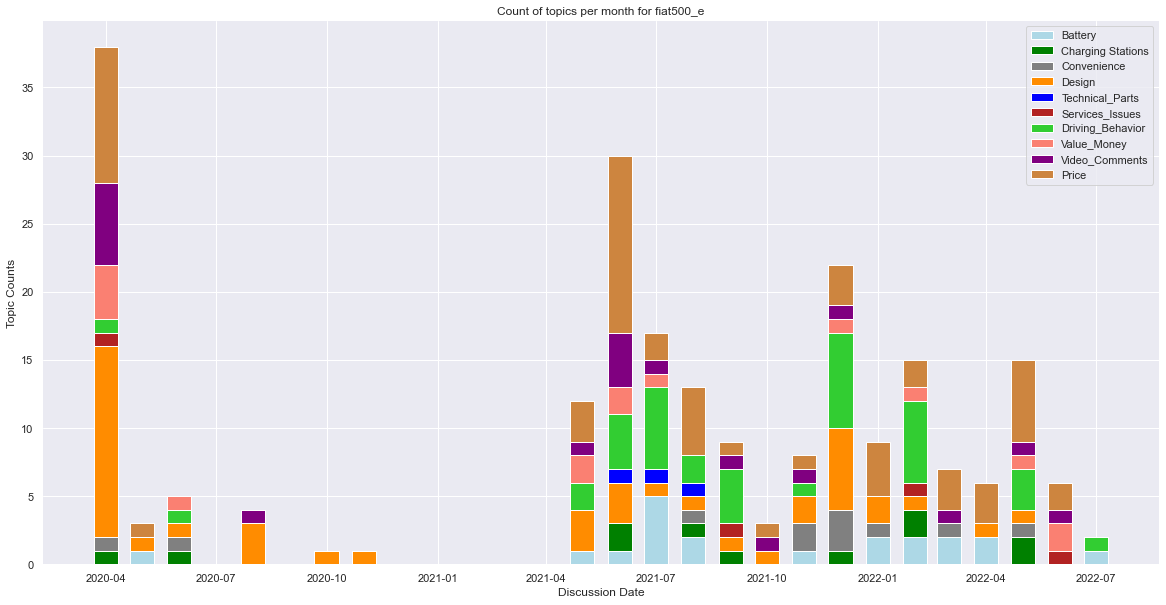

In [83]:
# Plotting the count per topic per month for electric
df_topic_500e = topics_per_month_yt(topic_sentiment, 'fiat500_e','fiat500_hybrid', topic_labels, 10)

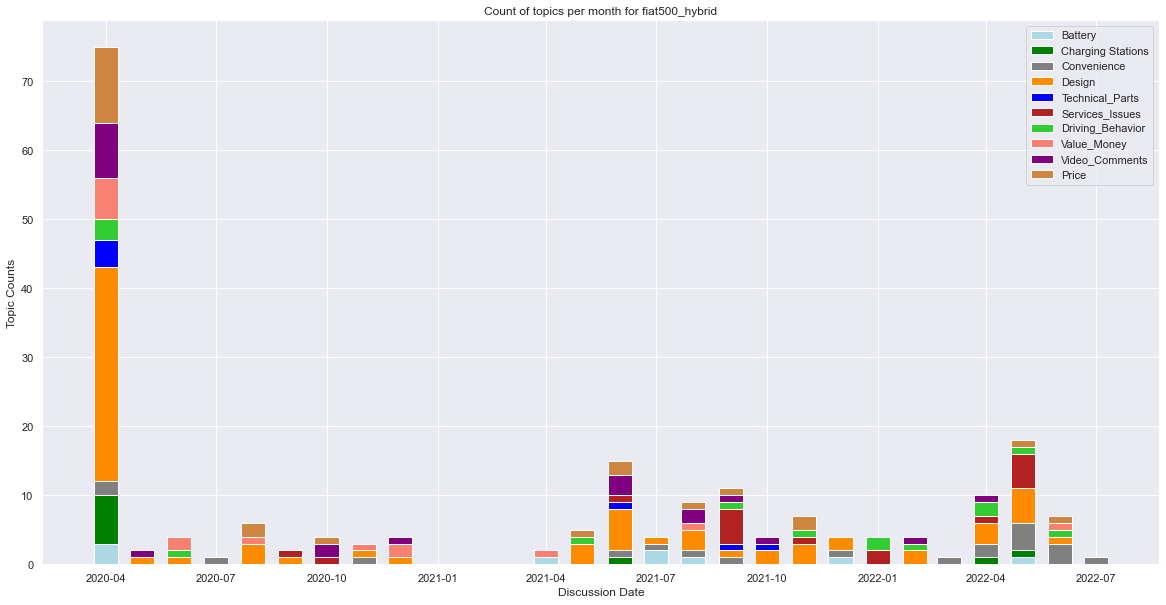

In [84]:
# Plotting the count per topic per month for hybrid
df_topic_500h = topics_per_month_yt(topic_sentiment, 'fiat500_hybrid','fiat500_e', topic_labels, 10)

In [85]:
def topic_sentiment_dispersion_plot(df, topic1, topic2, colname1, colname2, topic_labels):

   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon','purple','lightcoral']

   sent_colors = ['red', 'grey', 'green']

   width = 20

   df['date'] = pd.to_datetime(df['time_updated'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
   df = df.loc[df['month_year'].between('2020-01','2022-08', inclusive=True)]
   df = df.loc[(df[colname1] ==1) & (df[colname2] !=1)]

   topics_sent_dispersion = df.groupby(['month_year', 'sentiment', 'Main_topic1', colname1, colname2])['Main_topic1'].size().unstack('Main_topic1', fill_value=0)
   topics_sent_dispersion = topics_sent_dispersion.reset_index()
   
   fig = plt.figure(figsize=(20, 10))
   ax1 = fig.add_subplot(1, 2, 1)
   ax2 = fig.add_subplot(1, 2, 2)

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.reset_index(inplace=True)
   quarter1 = df_topics['month_year'].dt.to_timestamp()

   for topic, ax in zip([topic1, topic2], [ax1, ax2]):
    topic_name = "Topic "+str(topic)
    #topics_sent_dispersion_topic = topics_sent_dispersion.loc[topics_sent_dispersion[topic] == topic_name]
    y_sent_pos = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'pos'])
    y_sent_pos = y_sent_pos.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_pos['sentiment'] = y_sent_pos['sentiment'].fillna('pos')
    y_sent_pos = y_sent_pos.fillna(0)
    y_sent_pos = y_sent_pos[topic_name]

    y_sent_neu = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neu'])
    y_sent_neu = y_sent_neu.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neu['sentiment'] = y_sent_neu['sentiment'].fillna('neu')
    y_sent_neu = y_sent_neu.fillna(0)
    y_sent_neu = y_sent_neu[topic_name]

    y_sent_neg = pd.DataFrame(topics_sent_dispersion.loc[topics_sent_dispersion['sentiment']== 'neg'])
    y_sent_neg = y_sent_neg.merge(df_topics, left_on = 'month_year', right_on = 'month_year', how = 'right', suffixes=('', '_drop'))
    y_sent_neg['sentiment'] = y_sent_neg['sentiment'].fillna('neg')
    y_sent_neg = y_sent_neg.fillna(0)
    y_sent_neg = y_sent_neg[topic_name]


    ax.bar(quarter1, y_sent_neg, width, label = 'neg', color = sent_colors[0])
    ax.bar(quarter1, y_sent_neu, width, label = 'neu', color = sent_colors[1], bottom = y_sent_neg)
    ax.bar(quarter1, y_sent_pos, width, label = 'pos', color = sent_colors[2], bottom = y_sent_neg + y_sent_neu)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False) 
    
    # Labelling 
    ax.set_xlabel("Discussion Date")
    ax.set_ylabel("Comment Counts")
    ax.set_title("Dispersion of Sentiment over time for "+ colname1 + ": " +topic_labels[topic-1])
   
   plt.legend()
   plt.show()

   return 

In [86]:
topic_labels_dispersion = ['Battery','Convenience','Design','Technical_Parts','Services_Issues',
                'Driving_Behavior','Value_Money','Video_Comments','Price','Charging Stations']

In [87]:
# Concatinating the two datasets
yt_model_df= pd.concat([topic_senti_fiat500e_yt, topic_senti_fiat500hybrid_yt], axis=0)

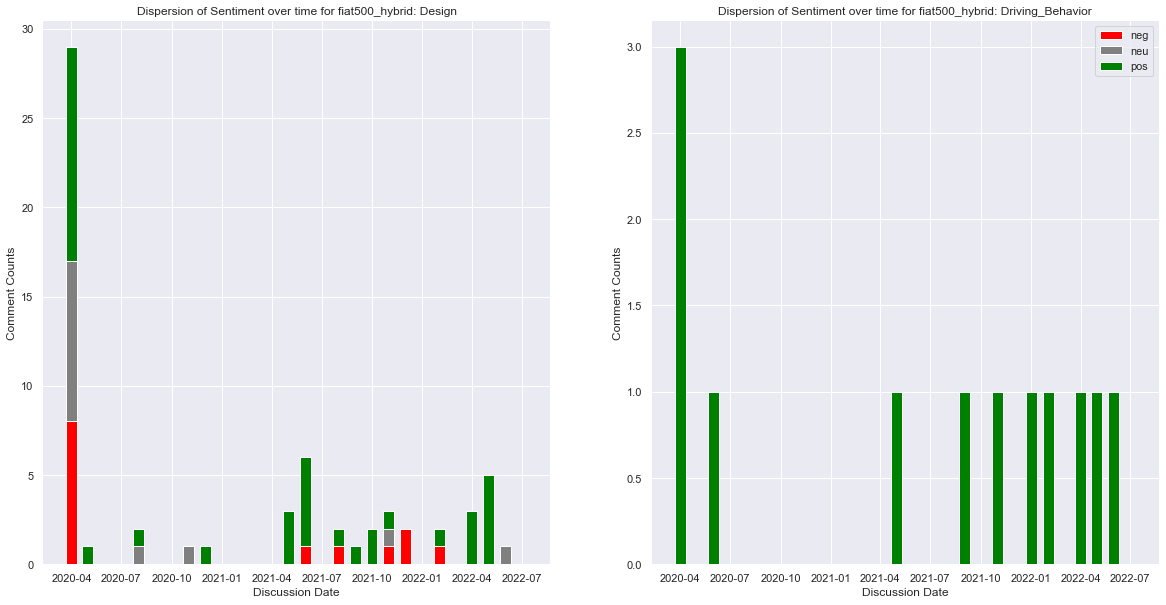

In [88]:
# Plotting the sentiment dispersion per topic
topic_sentiment_dispersion_plot(yt_model_df, 3, 6, 'fiat500_hybrid','fiat500_e', topic_labels_dispersion)

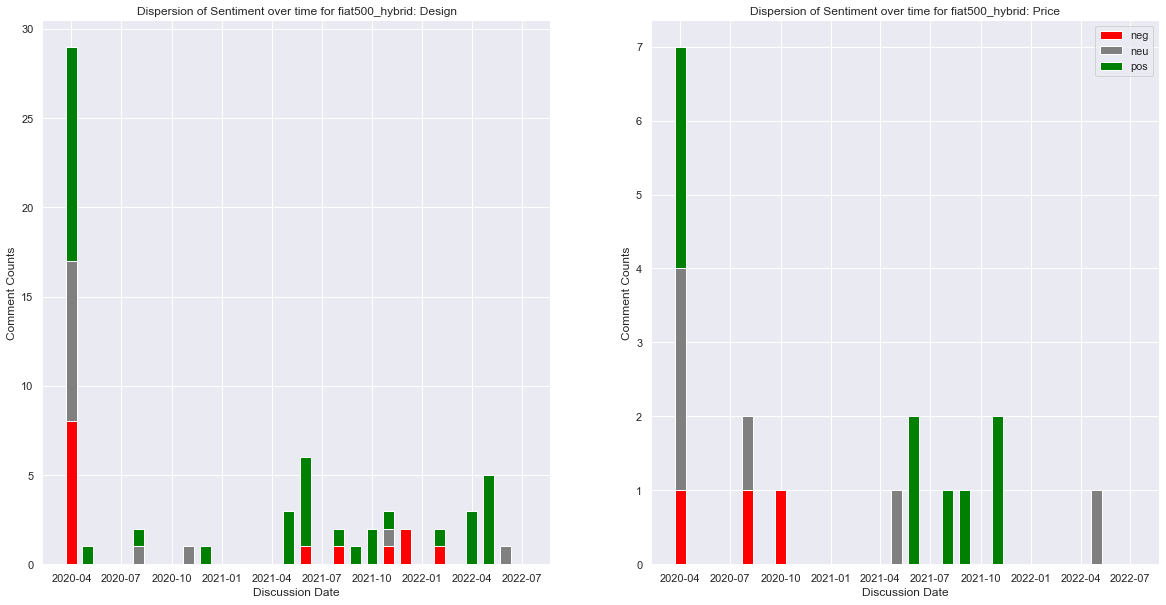

In [89]:
# Plotting the sentiment dispersion per topic
topic_sentiment_dispersion_plot(yt_model_df, 3, 9, 'fiat500_hybrid','fiat500_e', topic_labels_dispersion)

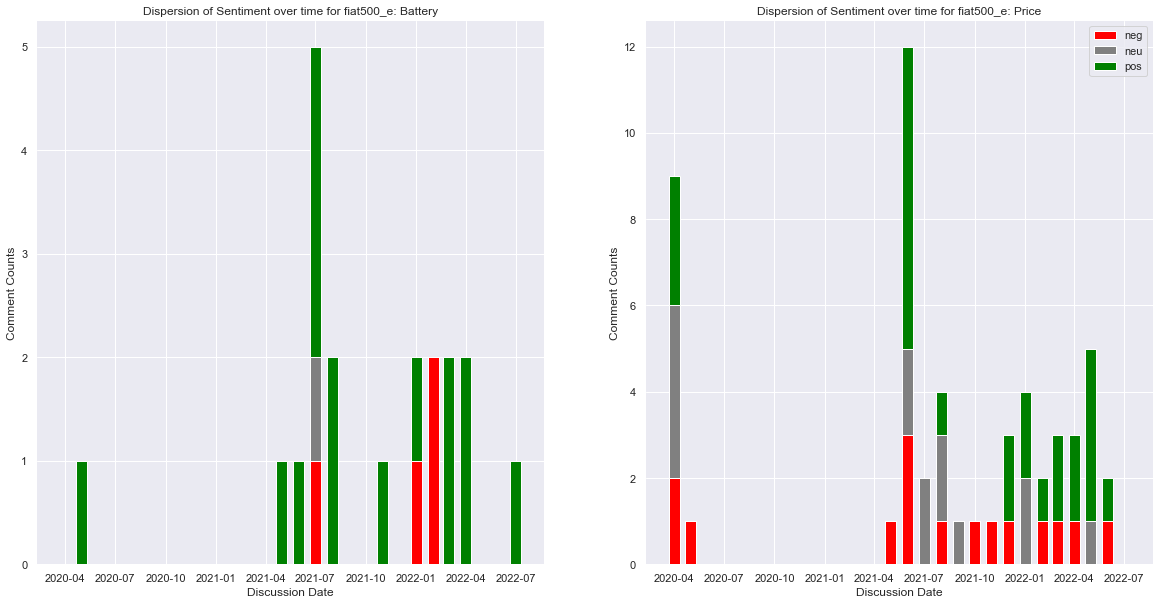

In [90]:
# Plotting the sentiment dispersion per topic
topic_sentiment_dispersion_plot(yt_model_df, 1, 9, 'fiat500_e','fiat500_hybrid', topic_labels_dispersion)

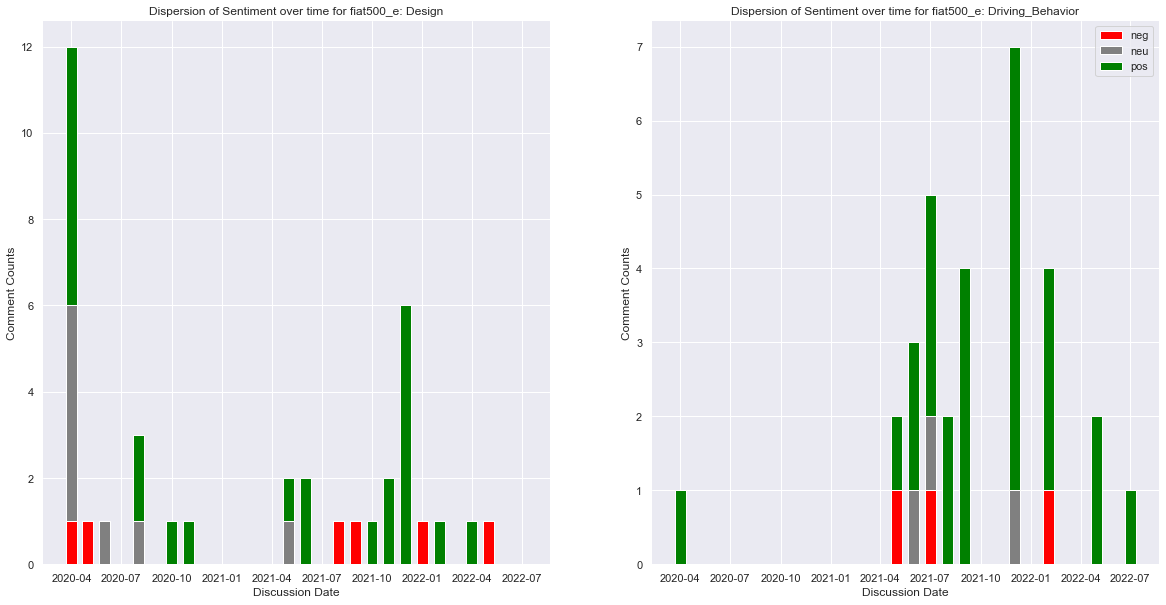

In [91]:
# Plotting the sentiment dispersion per topic
topic_sentiment_dispersion_plot(yt_model_df, 3, 6, 'fiat500_e','fiat500_hybrid', topic_labels_dispersion)

In [92]:
# Creating a copy of the dataset for further plots
df = topic_sentiment.copy()

In [93]:
### to see the general trend

label = ['Fiat 500 hybrid', "Fiat 500e"]

def plot_comment_trend(df, date_column, column_1, column_2, label):

    df['date'] = pd.to_datetime(df[date_column])
    df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
    df = df.loc[df['month_year'].between('2020-01','2022-08', inclusive=True)]

    # Creating the datasets to plot
    df_1 = df.groupby('month_year', as_index=False)[column_1].agg(sum)
    df_2 = df.groupby('month_year', as_index=False)[column_2].agg(sum)

    df_1['month_year'] = df_1['month_year'].astype(str)
    df_2['month_year'] = df_2['month_year'].astype(str)

    # Plot Mentioned Counts Top 5 
    fig = plt.figure(figsize = (20,8), facecolor = None)
    ax = fig.add_subplot()
    plt.plot(df_1['month_year'],df_1[column_1], marker='o', label = label[0],c= 'blue', alpha = 0.8)
    plt.plot(df_2['month_year'], df_2[column_2], marker='o',label = label[1], c= 'y',alpha = 0.8)

    # Labelling 
    plt.xlabel("Date Posted", size = 12)
    plt.ylabel("Mentioned Times", size = 12)
    plt.title("Monthly comments for " + label[0] + " and "+ label[1],  color = 'dimgray', size = 25, fontweight='bold' )
    plt.xticks(rotation = 45)

    # Display
    ## aest
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.set_yscale('log')

    plt.legend( prop={'size': 16})
    plt.show()

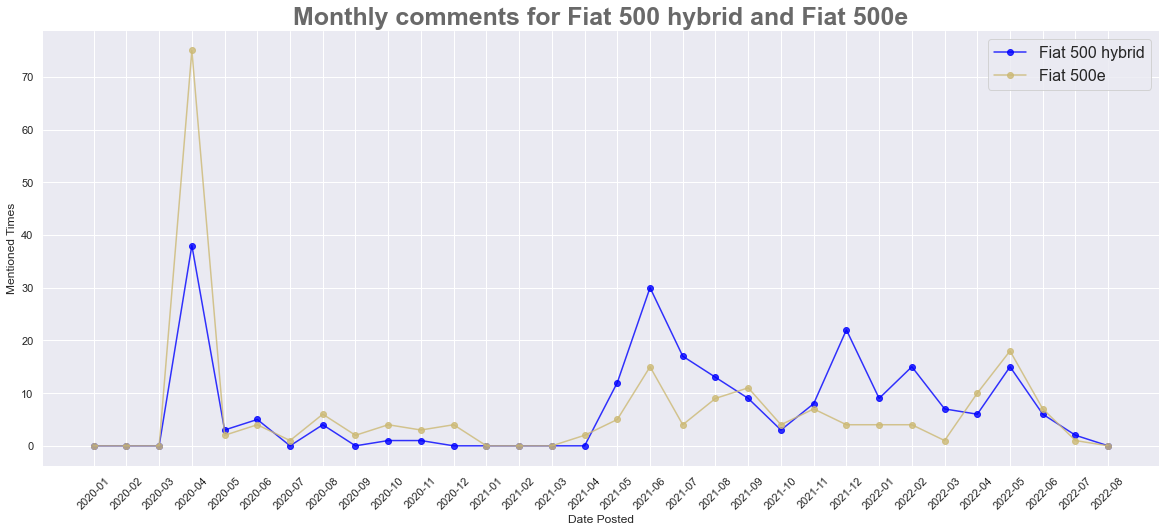

In [94]:
# Ploting the general trend of the general corpus
label = ['Fiat 500 hybrid', "Fiat 500e"]
plot_comment_trend(topic_sentiment, 'time_updated','fiat500_e','fiat500_hybrid', label)

In [95]:
## Plot per topic per time
def topics_per_quater1 (df_wth_prob, df_with_tweets, topic_names, for_whom):

  df_wth_prob_copy = df_wth_prob.copy()

  for i in range(len(topic_names)):
    df_wth_prob_copy.rename(columns={df_wth_prob_copy.columns[i]: topic_names[i] }, inplace = True)

  topic_larger = df_wth_prob_copy.loc[:, (df_wth_prob_copy.columns != 'Compound')& (df_wth_prob_copy.columns != 'Main_topic1')& (df_wth_prob_copy.columns != 'Main_topic2') ].apply(lambda row: row.nlargest(2),axis=1)
  topic_larger = topic_larger.div(topic_larger.sum(axis=1), axis=0)
  topic_larger = topic_larger.replace(np.nan,0)


  g = topic_larger[topic_names]
  df_wth_prob_copy['Main_topic1'] = g.idxmax(axis=1)
  df_wth_prob_copy['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)

  df_with_tweets['Main_topic1']=df_wth_prob_copy['Main_topic1']
  df_with_tweets['Main_topic2']=df_wth_prob_copy['Main_topic2']

  topics_df = pd.DataFrame()
  topics_df['quater_year'] = df_with_tweets ['quater_year']
  topics_df['Main_topic1'] = df_with_tweets ['Main_topic1']
  topics_df['count'] = 1
  
  df_to_plot = topics_df.groupby(['quater_year', 'Main_topic1']).count()\
      .unstack()

  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(1, 1, 1)

  df_to_plot.plot(ax=ax,  marker='o',ls ='--',alpha = 0.9)
  #ax.set_title(f'Number of tweets per quater for {for_whom}', size = 15)
  ax.legend(fontsize=14)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

In [96]:
## Plot per topic
def topics_per_quater1 (topic_sentiment, topic_1, topic_2, topic_3, topic_labels,):

  df_wth_prob_copy = df_wth_prob.copy()

  for i in range(len(topic_names)):
    df_wth_prob_copy.rename(columns={df_wth_prob_copy.columns[i]: topic_names[i] }, inplace = True)

  topic_larger = df_wth_prob_copy.loc[:, (df_wth_prob_copy.columns != 'Compound')& (df_wth_prob_copy.columns != 'Main_topic1')& (df_wth_prob_copy.columns != 'Main_topic2') ].apply(lambda row: row.nlargest(2),axis=1)
  topic_larger = topic_larger.div(topic_larger.sum(axis=1), axis=0)
  topic_larger = topic_larger.replace(np.nan,0)


  g = topic_larger[topic_names]
  df_wth_prob_copy['Main_topic1'] = g.idxmax(axis=1)
  df_wth_prob_copy['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)

  df_with_tweets['Main_topic1']=df_wth_prob_copy['Main_topic1']
  df_with_tweets['Main_topic2']=df_wth_prob_copy['Main_topic2']

  topics_df = pd.DataFrame()
  topics_df['quater_year'] = df_with_tweets ['quater_year']
  topics_df['Main_topic1'] = df_with_tweets ['Main_topic1']
  topics_df['count'] = 1
  
  df_to_plot = topics_df.groupby(['quater_year', 'Main_topic1']).count()\
      .unstack()

  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(1, 1, 1)

  df_to_plot.plot(ax=ax,  marker='o',ls ='--',alpha = 0.9)
  ax.set_title(f'Number of tweets per quater for {for_whom}', size = 15)
  ax.legend(fontsize=14)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

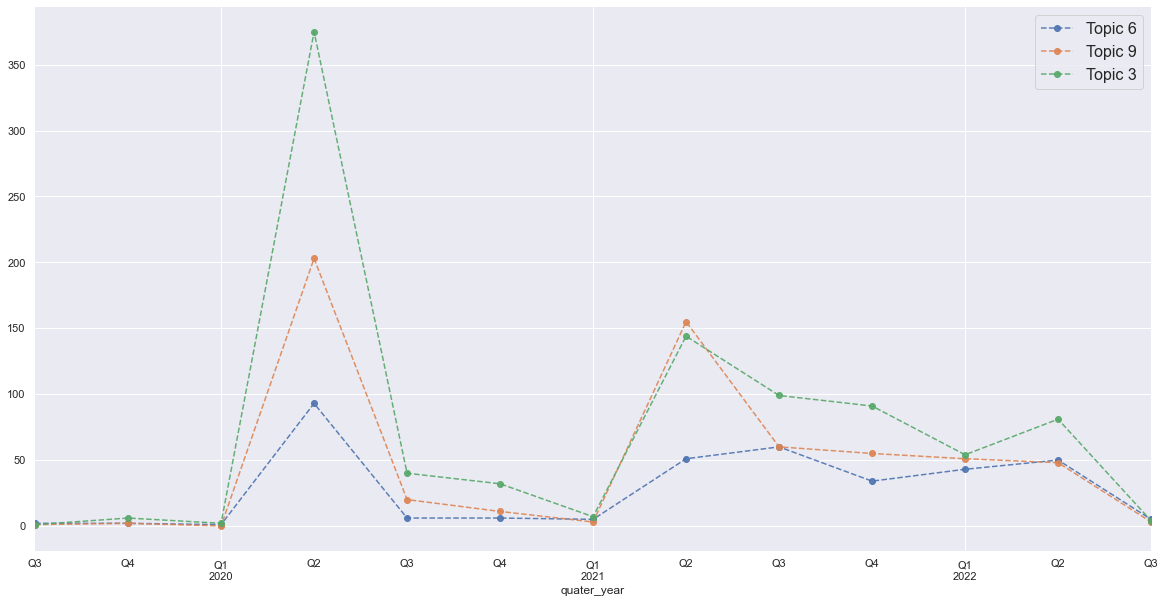

In [97]:
df = topic_sentiment.copy()

#add date
df['month_year'] = pd.to_datetime(df['time_updated']).dt.to_period('M')
df['quater_year'] = pd.to_datetime(df['time_updated']).dt.to_period('Q')

df_to_plot = df.groupby(['quater_year', 'Main_topic1']).size().unstack(fill_value=0)   #.count().unstack()

df_to_plot = df_to_plot[['Topic 6', 'Topic 9','Topic 3']]

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

df_to_plot.plot(ax=ax,  marker='o',ls ='--',alpha = 0.9)

ax.legend(fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#### Performing PMI in Price, Design and Driving Behavior to see what they are talking about by examining bi-grams and tri-grams

In [98]:
def topic_pmi(df,column_name, numberbest=100):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, numberbest)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

# To use for the whole dataset regarding to fiat (more co-occurances)
def topic_pmi_whole(df,column_name, numberbest=100):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(4)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(2)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, numberbest)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [99]:
# PMI for price
print('Analysis for Price')
print('===================')
print()

# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 9') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)


Analysis for Price

Number of words in the corpus: 2442
For Fiat 500e
[('hyundai', 'ioniq'), ('twin', 'air'), ('c', 'segment'), ('ioniq', '5'), ('entry', 'level'), ('e', 'vs'), ('great', 'review'), ('8', 'year'), ('how', 'cheap'), ('kwh', 'battery'), ('or', 'diesel'), ('honda', 'e'), ('000', 'km'), ('talk', 'about'), ('affordable', 'evs'), ('my', 'channel'), ('my', 'wife'), ('spec', '/'), ('000', 'euro'), ('too', 'expensive'), ('high', 'spec'), ('very', 'small'), ('petrol', 'or'), ('look', 'at'), ('will', 'lose'), ('live', 'with'), ('electric', 'vehicle'), ('could', 'get'), ('also', 'review'), ('£', '30'), ('ev', "'s"), ('cheap', 'they'), ('would', 'bring'), ('year', 'or'), ('in', 'california'), ('lack', 'of'), ('trade', 'in'), ('agree', 'with'), ('comparison', 'with'), ('we', 'need'), ('then', 'it'), ('an', 'abarth'), ('vs', 'fiat'), ('this', 'point'), ('wait', 'for'), ('segment', 'car'), ('as', 'well'), ('more', 'expensive'), ('so', 'much'), ('more', 'than'), ('I', 'wish'), ('in', 't

In [100]:
# Checking if they mentions goverment grant
topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 9'][(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 9']['Clean_corpus'].str.contains('gov|goverment|Goverment|Gov') & topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 9']['Clean_corpus'].str.contains('grant|Grant'))].Sentiment_corpus.to_list()

['a lot of talk about the price of the 500 e " this model be £ 30 000 " but no talk about government grant for 1 purchase of a new electric vehicle about £ 3000 & 2 more money off if you be trade in an old petrol or diesel car about £ 1500 so you\'ave already reduce your outgoing by £ 4 500 here in france we get up to currently about 7000 € for the purchase of a 100 % electric vehicle plus it be worth know that fuel ( if you charge at home ) be about 70 % cheap than an equivalent petrol or diesel engined car']

In [101]:
topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Clean_corpus'].str.contains('gov|goverment|Goverment|Gov') & topic_senti_fiat500e_yt['Clean_corpus'].str.contains('grant|Grant'))].Sentiment_corpus.to_list()

['a lot of talk about the price of the 500 e " this model be £ 30 000 " but no talk about government grant for 1 purchase of a new electric vehicle about £ 3000 & 2 more money off if you be trade in an old petrol or diesel car about £ 1500 so you\'ave already reduce your outgoing by £ 4 500 here in france we get up to currently about 7000 € for the purchase of a 100 % electric vehicle plus it be worth know that fuel ( if you charge at home ) be about 70 % cheap than an equivalent petrol or diesel engined car']

In [102]:
# PMI for design

# For fiat 500e
print('Analysis for Design')
print('===================')
print()
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3'], column_name='Sentiment_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 3'], column_name='Sentiment_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 3') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 3') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 3') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 3') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)


Analysis for Design

Number of words in the corpus: 1024
For Fiat 500e
[('free', 'consultation'), ('abarth', 'model'), ('our', 'vehicle'), ('journalist', 'when'), ('move', 'part'), ('honda', 'e'), ('give', 'you'), ('much', 'well'), ('not', 'replace'), ('good', 'surprise'), ('here', 'in'), ('that', 'can'), ('as', 'always'), ('dozen', 'of'), ('lot', 'of'), ('of', 'our'), ('happy', 'to'), ('do', 'not'), ('much', 'more'), ('I', 'want'), ('have', 'just'), ('review', 'of'), ('not', 'so'), ('a', 'few'), ('one', 'of'), ('so', 'good'), ('new', 'abarth'), ('this', 'new'), ('be', 'become'), ('would', 'be'), ('fiat', '500e'), ('however', 'the'), ('replace', 'the'), ('the', 'old'), ('the', 'same'), ('electric', 'this'), ('when', 'new'), ('I', 'have'), ('but', 'I'), ('fiat', '500'), ('range', 'be'), ('on', 'the'), ('a', 'nice'), ('new', 'fiat'), ('as', 'it'), ('it', 'will'), ('be', 'happy'), ('the', 'price'), ('electric', '500'), ('it', 'be'), ('500', 'e'), ('car', 'with'), ('the', 'engine'), ('have

In [103]:
# Checking for the comparison of the design of the car with abarth
print(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3'].shape[0])
sum(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3']['Clean_corpus'].str.contains('abarth | Abarth'))

38


2

In [104]:
topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3'][(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3']['Clean_corpus'].str.contains('california | California'))].Sentiment_corpus.to_list()
#topic_senti_fiat500e_yt[topic_senti_fiat500e_yt.Sentiment_corpus.str.contains('california | California')].Sentiment_corpus.to_list()

['I drive the old california fiat 500e it be interesting to compare and contrast they fix a lot of thing and modernize it the interior look more current less charming',
 'I have own 2 electric fiat 500s as far back as 2014 in california they look like the gas car but be full electric this new one be ugly']

In [105]:
# Check if the talk about the electric 500 which was launced in california (not in USA) in 2013 (https://www.wired.com/2012/11/fiat-500e-la/)
print(topic_senti_fiat500e_yt.shape[0])
print(sum(topic_senti_fiat500e_yt.Sentiment_corpus.str.contains('california | California')))
topic_senti_fiat500e_yt[topic_senti_fiat500e_yt.Sentiment_corpus.str.contains('california | California')].Sentiment_corpus.to_list()

202
8


['I drive the old california fiat 500e it be interesting to compare and contrast they fix a lot of thing and modernize it the interior look more current less charming',
 'here in california the 500e be launch as an emission " compliance " car in 2013 I like the look and need motorized shopping cart so I pick up a use orange 2013 500e with the white interior a year ago as a local runabout for $ 5000 it do have 70k mile on it but with the 10 year battery warranty I figure I be good for a while incidentally I notice the max range have degrade a little from new but I can still reliably push it to about 80 mile of mixed speed driving we be an all electric household with a new 250 mile range chevy bolt for our road trip look like pricey evs be go to be a hard sell for a while as long as the low petrol price and eliminate commute persist at least',
 'I have own 2 electric fiat 500s as far back as 2014 in california they look like the gas car but be full electric this new one be ugly',
 'they 

In [106]:
# PMI for driving behavior
print('Analysis for Driving Behavior')
print('===================')
print()
# For fiat 500e
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6'], column_name='Clean_corpus')
print('For Fiat 500e')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)
print()
# For fiat 500 hybrid
topic_best_bigrams, topic_best_trigrams = topic_pmi(df = topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6'], column_name='Clean_corpus')
print('For Fiat 500 hybrid')
print(topic_best_bigrams)
print('----------')
print(topic_best_trigrams)

print()
print('Top words for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=1 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for electric')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500e_yt[(topic_senti_fiat500e_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500e_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('Top words for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=1 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print()
print('bigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for hybrid')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(topic_senti_fiat500hybrid_yt[(topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6') & (topic_senti_fiat500hybrid_yt['Main_topic2']!='Topic 8')].Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

Analysis for Driving Behavior

Number of words in the corpus: 819
For Fiat 500e
[('60', 'mph'), ('huge', 'impression'), ('/', 'mr'), ('immediately', 'place'), ('la', 'prima'), ('mr', 'ev'), ('till', '/'), ('160', 'mile'), ('twingo', 'gt'), ('000', '€'), ('33', '000'), ('later', 'month'), ('place', 'order'), ('think', 'go'), ('range', 'mode'), ('honda', 'e'), ('pedal', 'range'), ('extended', 'test'), ('month', 'ago'), ('want', 'test'), ('500e', 'consider'), ('test', 'drive'), ('small', 'car'), ('500e', 'week'), ('get', '500e'), ('fiat', '500e'), ('drive', 'honda'), ('drive', '500e')]
----------
[('till', '/', 'mr'), ('/', 'mr', 'ev'), ('33', '000', '€'), ('immediately', 'place', 'order'), ('pedal', 'range', 'mode'), ('extended', 'test', 'drive'), ('fiat', '500e', 'consider'), ('drive', 'honda', 'e'), ('drive', '500e', 'week'), ('test', 'drive', '500e')]

Number of words in the corpus: 463
For Fiat 500 hybrid
[('7', 'year'), ('second', 'hand'), ('low', 'speed'), ('courtesy', 'car'), ('50

In [107]:
# Checking how many comments for test drive talking about  
# For electric
print('For electric')
print(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6'].shape[0])
print(sum(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('pedal')))
print(sum(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('range')))
print(sum(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('order')))

(topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 3']['Clean_corpus'].str.contains('california | California'))


# For hybrid
print('For hybrid')
print(topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6'].shape[0])
print(sum(topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('speed')))
print(sum(topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('manual | gear | gearbox')))
print(sum(topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('safety')))


For electric
31
4
7
5
For hybrid
12
3
3
1


In [108]:
topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6'].Sentiment_corpus.to_list()

['we see load of 500s on the road so I guess for any fiat 500 fan want to go electric this would be just the job',
 'the safety be definitely need especially the 360 camera all the girl I know that drive a fiat 500 can not drive to save anyones life',
 'the normal fiat 500 sound like a coffeemachine luckily they make this electric one so it do not make any sound at all hahaha',
 '" it be almost like be sit in the1950 apart from the threat of the cold war " literally death I have december 2007 fiat 500 lounge white color it be my mom ’s car and she gift I when I turn 18 ( in italy you can drive from 18 yo ) and now I ’m 22 yo she buy the new model but it ’ really similar to the old fiat 500 we both love this car',
 "buy the missus a second hand petrol 500c just for the occasional trip around town or to go shop not expect much more than a couple of open air thrill every now and then we end up love the car much more than we think we would the engine have fairly low mileage and feel unnusu

In [109]:
topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6'][topic_senti_fiat500e_yt[topic_senti_fiat500e_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('pedal')].Sentiment_corpus.to_list()

["I have an extended test drive of a 500e last week and as a previously dedicated petrolhead it make a huge impression on I I 've only ever drive manual car before and I find one pedal drive much easy so my twingo gt will be replace by the fiat in the next couple of week once my new car arrive at the dealer",
 'I be also a total petrolhead and have never previously drive a bev until I have an extended test drive of a 500e last week ( one pedal range mode ) which make a huge impression for the same reason as you I immediately place an order and it should arrive later this month I hope the next owner of my trade in a twingo gt enjoy it as much as I do but for I ice vehicle be now as redundant as steam power car at the beginning of last century',
 'buy the 118 hp 500e passion 6 month ago ( in rise gold ) and love everything it range be about 160 mile with a light foot in mix condition include a lot of 60 mph drive and always in one pedal range mode choose the fiat over its rival because i

In [110]:
topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6'][topic_senti_fiat500hybrid_yt[topic_senti_fiat500hybrid_yt['Main_topic1']=='Topic 6']['Clean_corpus'].str.contains('speed')].Sentiment_corpus.to_list()

["buy the missus a second hand petrol 500c just for the occasional trip around town or to go shop not expect much more than a couple of open air thrill every now and then we end up love the car much more than we think we would the engine have fairly low mileage and feel unnusually sluggish with a very poor mpg but I 've be rev it till the redline from time to time and now we be able to shift into a high gear at low speed cruise effortlessly and with excellent fuel consumption around 5 2l/100kms it be great fun in the bend a bit wobbly at low speed but push a little more speed into corner and it remain fairly flat and predictable the steering could be a bit quick to react but very enjoyable indeed and I be use to great handling car own a smart roadster and a focus I be not expect this much fun the gearbox have some bad bearing that need replacement but all solve under warranty overpriced when new a bargain when not we love our little fiat 500",
 "I have a 2012 fiat 500 sport with a 5 sp

## Question 2

In [111]:
# Creating the patterns to distinguish the fiat brand with fiat 500 brand
fiat_brand_patterns = [
    [{'LOWER': 'fiat'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'brand'}],
    [{'LOWER': 'brand'}, {'LOWER': 'fiat'}]
    ]

fiat500_brand_patterns = [
    [{'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'TEXT': '500'}, {'LOWER': 'fiat'}],
    [{'LOWER': 'fiat'}, {'LOWER': 'hybrid'}],
    [{'LOWER': 'hybrid'}, {'LOWER': 'fiat'}],
    [{'LOWER': 'fiat'}, {'TEXT': '500'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'TEXT': '500'}, {'LOWER': 'electric'}],
    [{'LOWER': 'electric'}, {'TEXT': '500'}],
    [{'TEXT': '500'}, {'LOWER': 'ev'}],
    [{'LOWER': 'ev'}, {'TEXT': '500'}],
    [{'LOWER': 'ev'}, {'TEXT': '500'}],
    [{'LOWER': 'fiat'}, {'TEXT': '500e'}],
    [{'LOWER': 'fiat'}, {'TEXT': '500'}, {'LOWER': 'e'}],
    [{'LOWER': 'new'}, {'LOWER': 'fiat'}, {'TEXT': '500'}],
    [{'TEXT': '500e'}],
    [{'TEXT': '500'}],
    [{'TEXT': '500'}, {'LOWER': 'e'}]   
]

In [112]:
# Creating the matcher for the brand
def comments_matcher_brand(df, column_name):

    matcher = Matcher(nlp.vocab)
    
    fiat = []
    fiat500 = []

    list = df[column_name].to_list()

    for text in list:
        temp = nlp(text)

        matcher.add('fiat', fiat_brand_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            fiat.append(1)
            #fiat500.append(0)
            matcher.remove('fiat')
        else: 
            fiat.append(0)
            matcher.remove('fiat')

        matcher.add('fiat500', fiat500_brand_patterns)
        matches = matcher(temp)
        if len(matches) != 0:
            fiat500.append(1)
        #    fiat.append(0)
        else: fiat500.append(0)
    
        matcher.remove('fiat500')

    df['fiat_brand'] = fiat
    df['fiat500_brand'] = fiat500

    return df

In [113]:
df_brands = comments_matcher_brand(yt_combined_full, 'Clean_corpus')
df_brands.shape

(4331, 25)

In [114]:
# Inspectin the number of comments that mentions the following models and brands
print('''
Number of comments per car model:
Fiat brand: {}
Fiat 500 brand: {}
Number of overlaping comments: {}
'''.format(sum(df_brands['fiat_brand']),sum(df_brands['fiat500_brand']), sum(df_brands[df_brands['fiat_brand']==1].fiat500_brand),))


Number of comments per car model:
Fiat brand: 696
Fiat 500 brand: 634
Number of overlaping comments: 353



In [115]:
# Removing the overlaping comments
df_brands.loc[df_brands['fiat500_brand']==1, 'fiat_brand'] = 0

In [116]:
# Inspectin the number of comments that mentions the following models and brands
print('''
Number of comments per car model:
Fiat brand: {}
Fiat 500 brand: {}
Number of overlaping comments: {}
'''.format(sum(df_brands['fiat_brand']),sum(df_brands['fiat500_brand']), sum(df_brands[df_brands['fiat_brand']==1].fiat500_brand),))


Number of comments per car model:
Fiat brand: 343
Fiat 500 brand: 634
Number of overlaping comments: 0



In [117]:
yt_combined_brand = df_brands.loc[(df_brands['fiat_brand']==1)| (df_brands['fiat500_brand']==1)]
yt_combined_brand.drop(['sentiments'], axis=1, inplace=True)
yt_combined_brand.reset_index(drop=True, inplace=True)
yt_combined_brand.shape[0]

977

100%|██████████| 977/977 [00:00<00:00, 2831952.32it/s]



    Data information
    --------------------------------------
    Total number of comments: 977
    Average lenght of each reply: 232.38 characters
    Average words per comment: 49.0 words
    
    Number of positive comments (compound >0.05) is 605 (61.9%)
    Number of negative comments (compound <-0.05) is 201 (20.6%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 171 (17.5%)
    
    --------------------------------------
    


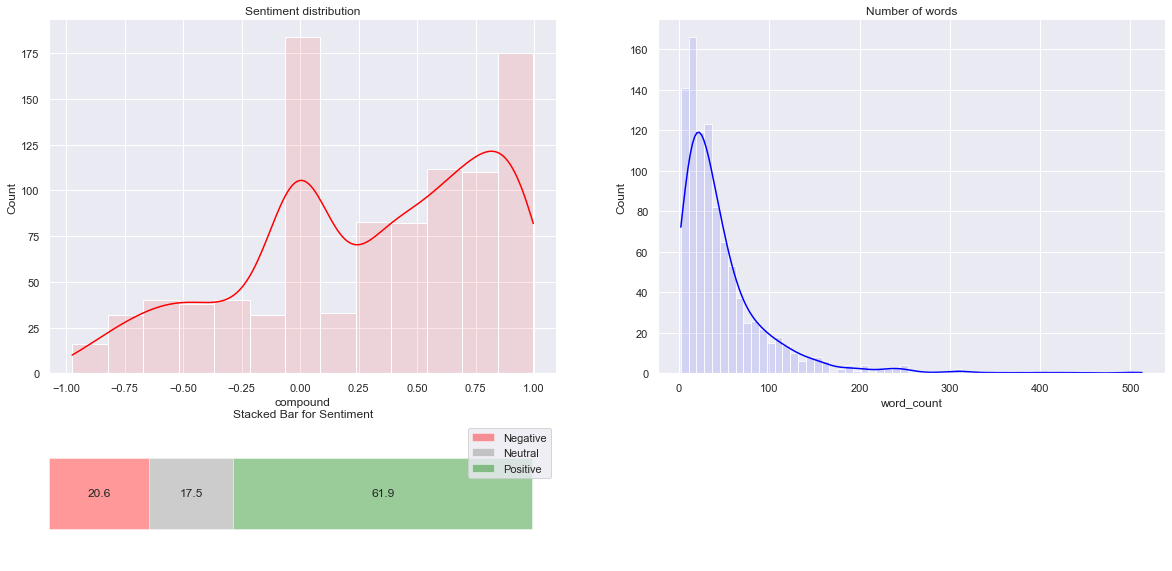

In [118]:
# Creating the function for sentiment analysis
def sentiment(df, column_name):
    sid = SentimentIntensityAnalyzer()
    df["sentiments"] = df[column_name].apply(lambda x: sid.polarity_scores(x))
    df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

    # decide sentiment as positive, negative and neutral
    sentiment = []
    for compound in tqdm.tqdm(df['compound']):
        if compound >= 0.05 :
            sentiment.append('pos')
        elif compound <= - 0.05 :
            sentiment.append('neg')
        else :
            sentiment.append('neu')
    df.loc[:,'sentiment'] = sentiment

    return df

    
# Performing the sentiment analysis
yt_combined_brand = sentiment(yt_combined_brand, 'Sentiment_corpus')

sentiment_explor_yt(yt_combined_brand, 'Sentiment_corpus')


    Data information
    --------------------------------------
    Total number of comments: 343
    Average lenght of each reply: 177.36 characters
    Average words per comment: 37.1 words
    
    Number of positive comments (compound >0.05) is 189 (55.1%)
    Number of negative comments (compound <-0.05) is 76 (22.2%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 78 (22.7%)
    
    --------------------------------------
    


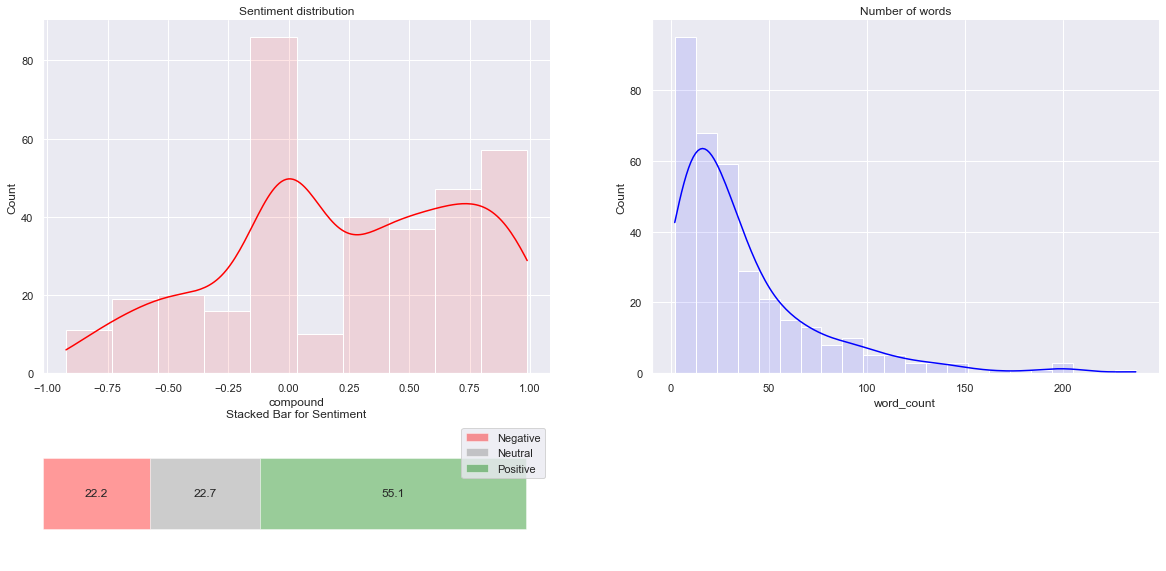

In [119]:
# Display Sentiment for fiat brand
sentiment_explor_yt(yt_combined_brand[yt_combined_brand['fiat_brand']==1], 'Sentiment_corpus')

In [120]:
# Finding the average sentiment for Fiat brand
print('Average compound for Fiat brand:', round(np.mean(yt_combined_brand[yt_combined_brand['fiat_brand']==1].compound),2))

Average compound for Fiat brand: 0.24



    Data information
    --------------------------------------
    Total number of comments: 634
    Average lenght of each reply: 262.15 characters
    Average words per comment: 55.4 words
    
    Number of positive comments (compound >0.05) is 416 (65.6%)
    Number of negative comments (compound <-0.05) is 125 (19.7%)
    Number of neutral comments (compound is between -0.05 and 0.05) is 93 (14.7%)
    
    --------------------------------------
    


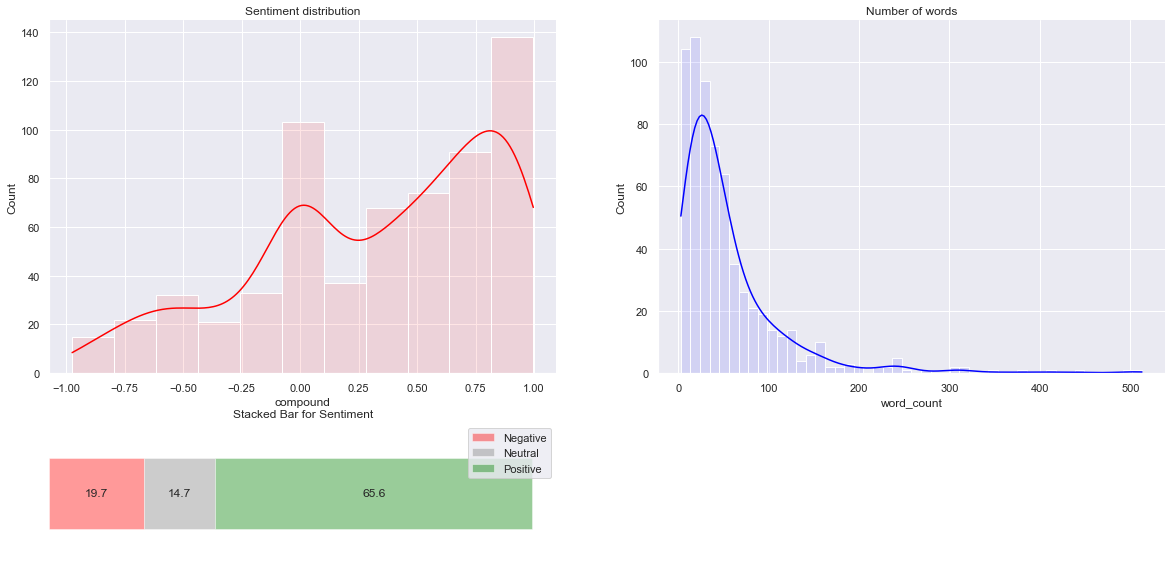

In [121]:
# Display Sentiment for fiat 500 brand
sentiment_explor_yt(yt_combined_brand[yt_combined_brand['fiat500_brand']==1], 'Sentiment_corpus')

In [122]:
# Finding the average sentiment for Fiat brand
print('Average compound for Fiat 500 brand:', round(np.mean(yt_combined_brand[yt_combined_brand['fiat500_brand']==1].compound),2))

Average compound for Fiat 500 brand: 0.33


In [123]:
# Converting the date column to datetime
yt_combined_brand['date']= pd.to_datetime(yt_combined_brand['time_updated'])
# Extract month and year
yt_combined_brand['month_year'] = pd.to_datetime(yt_combined_brand['date']).dt.to_period('M')
yt_combined_brand = yt_combined_brand.loc[yt_combined_brand['month_year'].between('2019-09','2022-08', inclusive=True)]

# Creating the data to visualise
df_time_brand = yt_combined_brand.groupby(['month_year']) ['fiat_brand','fiat500_brand'].sum().reset_index()
df_time_brand['month_year'] = pd.to_datetime(df_time_brand['month_year'].astype(str))
df_time_brand = df_time_brand[df_time_brand['month_year']>='2020-01-01']

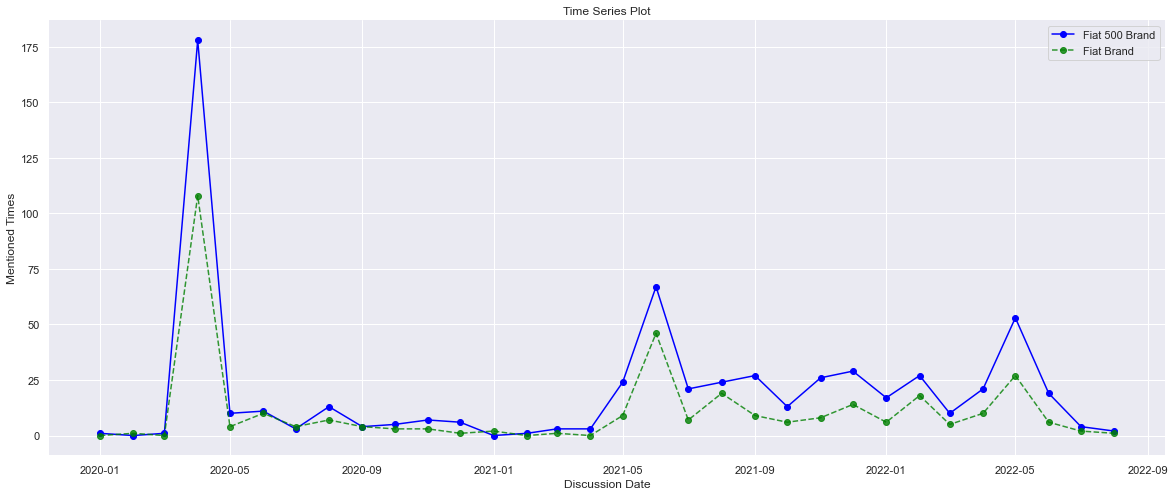

In [124]:
# Plot Mentioned Counts
fig = plt.figure(figsize = (20,8), facecolor = None)
ax = fig.add_subplot()
plt.plot(df_time_brand['month_year'],df_time_brand["fiat500_brand"], marker='o', label = 'Fiat 500 Brand', c= 'blue')
plt.plot(df_time_brand['month_year'],df_time_brand["fiat_brand"], marker='o',label = 'Fiat Brand', c= 'green',ls ='--',alpha = 0.8)

# Labelling 
plt.xlabel("Discussion Date")
plt.ylabel("Mentioned Times")
plt.title("Time Series Plot")

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend()
plt.show()

#### Sentiment Changed Through Time -- Brand

In [125]:
yt_fiat_brand = yt_combined_brand.loc[(yt_combined_brand['fiat500_brand'] !=1) & (yt_combined_brand['fiat_brand'] ==1)]
yt_fiat500_brand = yt_combined_brand.loc[(yt_combined_brand['fiat500_brand'] ==1) & (yt_combined_brand['fiat_brand'] !=1)]
print('Number of comments only mentioned Fiat 500 Brand: {}'.format(yt_fiat500_brand.shape[0]))
print('Number of comments only mentioned Fiat Brand: {}'.format(yt_fiat_brand.shape[0]))

Number of comments only mentioned Fiat 500 Brand: 634
Number of comments only mentioned Fiat Brand: 343


In [126]:
# brand mentioned counts through time
df_time_fiat500_brand_sentiment = yt_fiat500_brand.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
df_time_fiat_brand_sentiment = yt_fiat_brand.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
df_time_fiat500_brand_sentiment = df_time_fiat500_brand_sentiment[df_time_fiat500_brand_sentiment.index>='2020-01-01']
df_time_fiat_brand_sentiment = df_time_fiat_brand_sentiment[df_time_fiat_brand_sentiment.index>='2020-01-01']

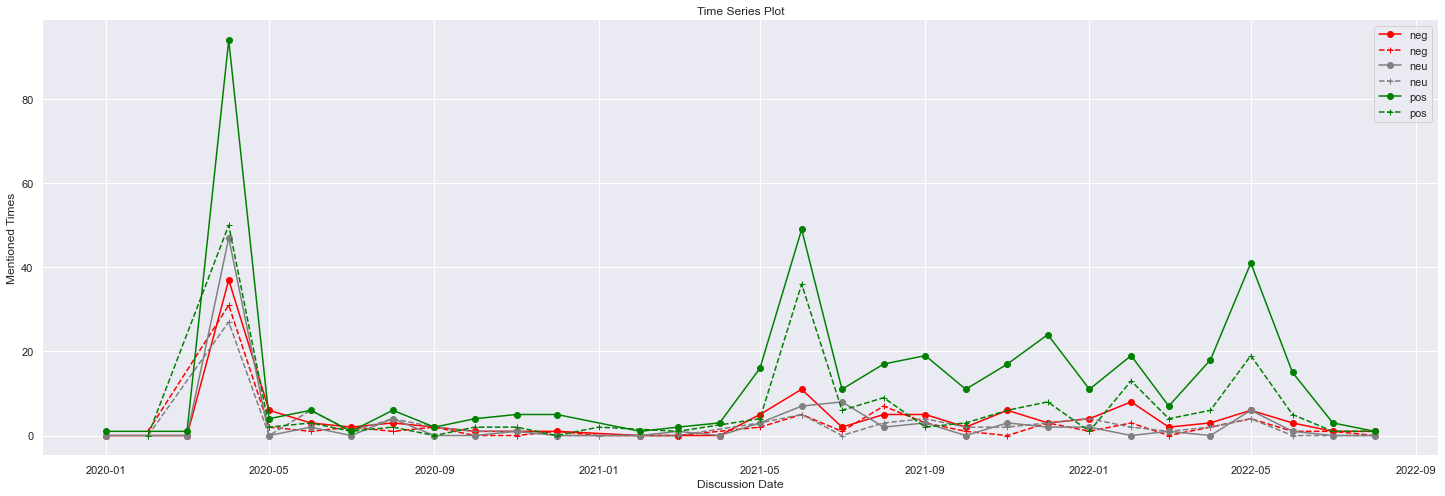

In [127]:
# Plot Mentioned Counts
fig = plt.figure(figsize = (25,8), facecolor = None)
ax = fig.add_subplot()
label = ['neg','neu','pos']
color = ['red','grey','green']
quarter1 = df_time_fiat500_brand_sentiment.index.to_timestamp()
quarter2 = df_time_fiat_brand_sentiment.index.to_timestamp()
for i in range(3):
    
    plt.plot(quarter1,df_time_fiat500_brand_sentiment[label[i]], marker='o', label = label[i], c= color[i])
    plt.plot(quarter2,df_time_fiat_brand_sentiment[label[i]], marker='+',label = label[i], c= color[i],ls ='--')

# Labelling 
plt.xlabel("Discussion Date")
plt.ylabel("Mentioned Times")
plt.title("Time Series Plot")

# Display
## aest
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend()
plt.show()

In [128]:
# Preparing data for visualisation
yt_fiat500_brand_compound = yt_fiat500_brand.groupby('month_year').agg({'compound':'mean'}) 
yt_fiat_brand_compound = yt_fiat_brand.groupby('month_year').agg({'compound':'mean'})

yt_brand_compound_df = pd.concat([yt_fiat500_brand_compound,yt_fiat_brand_compound],axis= 1).replace(np.nan,0)
yt_brand_compound_df.columns = ['Fiat500_Brand_compound','Fiat_Brand_compound']
yt_brand_compound_df = yt_brand_compound_df.sort_values(by=['month_year'])
yt_brand_compound_df = yt_brand_compound_df[yt_brand_compound_df.index>='2020-01-01']


In [129]:
yt_brand_count_df = yt_combined_brand.groupby(['month_year']) ['fiat500_brand','fiat_brand'].sum().reset_index()
yt_brand_count_df = yt_brand_count_df[yt_brand_count_df['month_year']>='2020-01-01']

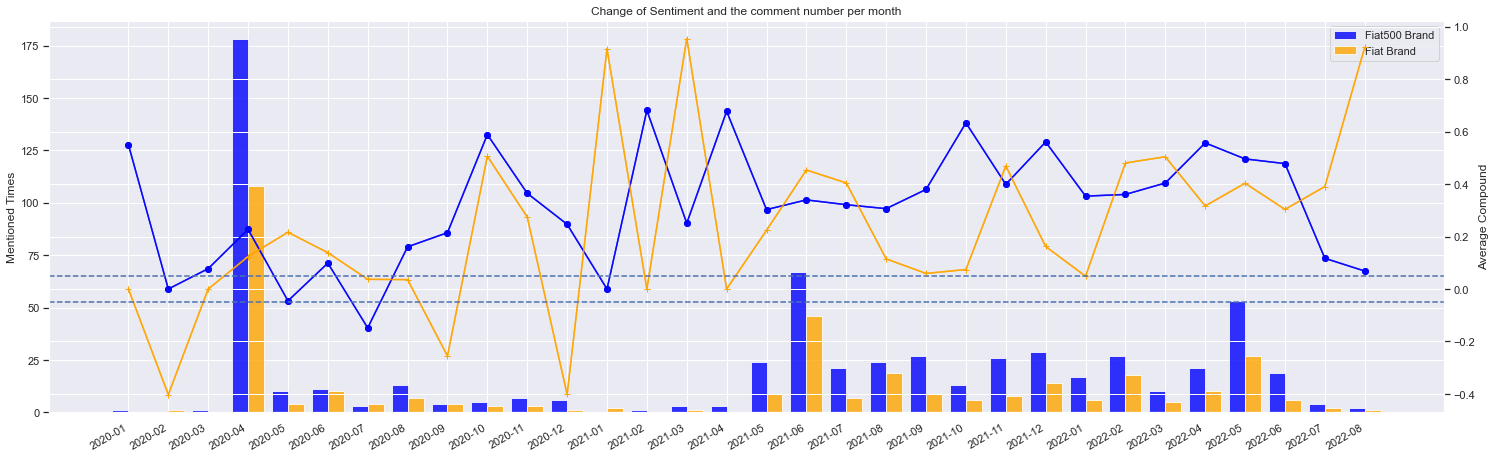

In [130]:
# Plot Mentioned Counts
fig = plt.figure(figsize = (25,8))
ax = fig.add_subplot(111)

label = ['Fiat500 Brand','Fiat Brand']
colors = ['blue','orange']
x= np.arange(0,len(yt_brand_compound_df.index))

width = 0.40

quarter  = yt_brand_compound_df.index


## Add the plot for hybrid
rects1 = ax.bar(x - width/2, yt_brand_count_df['fiat500_brand'], width, label='Fiat500 Brand',color = colors[0],alpha =0.8)
rects2 = ax.bar(x + width/2, yt_brand_count_df['fiat_brand'], width, label='Fiat Brand',color = colors[1],alpha =0.8)


ax2 = ax.twinx()
for i in range(2):
    ax2.plot(x,yt_brand_compound_df['Fiat500_Brand_compound'], marker='o', label = label[i],c=colors[0],alpha =0.8)
    ax2.plot(x,yt_brand_compound_df['Fiat_Brand_compound'], marker='+',label = label[i],c=colors[1],alpha =0.8)

# Labelling 
plt.xlabel("Discussion Date")
plt.title("Change of Sentiment and the comment number per month")
ax.set_ylabel("Mentioned Times")
ax2.set_ylabel("Average Compound")

# Display
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.axhline(0.05, linestyle='--')
ax2.axhline(-0.05, linestyle='--')
plt.xticks(x,quarter, rotation = 90)

ax.legend()
fig.autofmt_xdate()
plt.show()

The spike for mentions in April 2020 occured because it was a video from carwow that contained 1916 comments & High Peak Autos with (796) (apparently most of them are talking about the brand) (model anounced 3/2020 in Milan)
On 10/2021 Fiat Chrysler merged with PSA to form the Stellandis group (4th largest automotive group) link https://www.forbes.com/wheels/news/stellantis-fiat-chrysler-merges-with-psa-becoming-worlds-fourth-largest-automaker/

Dates that the youtube videos was published and comments:

- For BEV:
    - 4/20 (2.685) -> (model anounced 3/2020 in Milan)
    - 02/22 (175)
    - 05/21 (264)
    - 06/21 (1109)     High Peak Autos with (834) -> for the review a car dealer gave the car to youtuber to review it
    - 7/21 (169)
    - 08/21 (223) -> (500e named “Small Car of the Year” at the 2021 News UK Motor Awards)  link: https://www.driving.co.uk/news/motor-awards/motor-awards-2021-sunday-times-best-cars/ 
    - 10/21 (74)
    - 11/21 (118)
    - 04/22 (56)
    - 05/22 (85)

- For hybrid:
    - 9/19 (124)
    - 3/20 (31)
    - 4/20 (796)  High Peak Autos
    - 11/20 (129)
    - 3/21 (71)
    - 8/21 (476) 
    - 9/21 (13)
    - 10/21 (31)
    - 11/21 (6)


#### Performing PMI for the brands

In [131]:
pmi_brand_combined = pd.concat([yt_fiat_brand, yt_fiat500_brand],axis=0)

In [132]:
pmi_brand_combined
# Removing the numbers for the corpus 
pmi_brand_combined['Clean_corpus'] = [re.sub(" \d+", " ", comment) for comment in pmi_brand_combined['Clean_corpus'].to_list()]

In [133]:
def topic_pmi_brand(df,column_name):
    # Create one big corpus with words
    corpus_pmi_combined = [word for comment in df[column_name].to_list() for word in comment.split()]
    print('Number of words in the corpus:', len(corpus_pmi_combined))

    # Initialize the bigram model
    bigram_measures = BigramAssocMeasures()

    # find bigrams
    bigrams = BigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    bigrams.apply_freq_filter(5)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_bigrams_tuple = bigrams.nbest(bigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    # Initialize the trigram model
    trigram_measures = TrigramAssocMeasures()

    # find bigrams
    trigrams = TrigramCollocationFinder.from_words(corpus_pmi_combined)

    # See the best bigrams
    trigrams.apply_freq_filter(3)  # it is useful to apply filters, such as ignoring all bigrams which occur less than five times in the corpus
    best_trigrams_tuple = trigrams.nbest(trigram_measures.pmi, 100)  # the top bigram collocations in Genesis are listed below, as measured using Pointwise Mutual Information.
    
    return best_bigrams_tuple, best_trigrams_tuple

In [134]:
# PMI for fiat 500 brand
pmi_fiat500_brand_combined  = pmi_brand_combined.loc[(pmi_brand_combined['fiat500_brand'] ==1) & (pmi_brand_combined['fiat_brand'] != 1)]
brand_best_bigrams, brand_best_trigrams = topic_pmi_brand(df = pmi_fiat500_brand_combined, column_name='Clean_corpus')
print(brand_best_bigrams)
print('----------')
print(brand_best_trigrams)

Number of words in the corpus: 15138
[('la', 'prima'), ('twingo', 'gt'), ('ford', 'ka'), ('vw', 'beetle'), ('twin', 'air'), ('—', '—'), ('fuel', 'economy'), ('door', 'handle'), ('real', 'world'), ('easy', 'park'), ('charge', 'station'), ('mini', 'cooper'), ('build', 'quality'), ('kwh', 'battery'), ('month', 'ago'), ('second', 'hand'), ('oil', 'change'), ('speed', 'manual'), ('fall', 'love'), ('look', 'forward'), ('couple', 'year'), ('£', 'k'), ('year', 'ago'), ('sport', 'model'), ('range', 'mode'), ('driver', 'seat'), ('brand', 'new'), ('test', 'drive'), ('honda', 'e'), ('electric', 'vehicle'), ('great', 'review'), ('nice', 'review'), ('year', 'old'), ('great', 'video'), ('abarth', 'version'), ('feel', 'like'), ('thank', 'review'), ('fun', 'drive'), ('interior', 'look'), ('great', 'little'), ('abarth', 'model'), ('mini', 'electric'), ('look', 'like'), ('k', 'mile'), ('city', 'car'), ('mile', 'range'), ('fiat', 'pop'), ('little', 'car'), ('"', '"'), ('fiat', 'sport'), ('small', 'car'), 

In [135]:
# Bi-grams and for fiat 500 brand
print('bigrmas for fiat 500 brand')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(pmi_fiat500_brand_combined.Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for fiat 500 brand')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(pmi_fiat500_brand_combined.Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for fiat 500 brand
            Word  Freq
0       buy fiat    24
1       new fiat    24
2     test drive    23
3      look like    23
4       city car    21
5   great review    21
6     little car    20
7   electric car    16
8       car like    16
9      love fiat    15
10     fun drive    15
11      year old    14
12     small car    13
13    drive fiat    12
14      twin air    12
15    range mode    11
16     car drive    11
17      year ago    11
18       new car    10
19     brand new     9
trigrmas for fiat 500 brand
                      Word  Freq
0         great little car     6
1           fiat look like     5
2       interior look like     4
3               till mr ev     4
4         pedal range mode     4
5      twingo gt identical     3
6           small city car     3
7          test drive week     3
8           brand new fiat     3
9   book free consultation     3
10        real world range     3
11            car year old     3
12     review fiat channel     2


In [136]:
# PMI for fiat brand
pmi_fiat_brand_combined  = pmi_brand_combined.loc[(pmi_brand_combined['fiat500_brand'] !=1) & (pmi_brand_combined['fiat_brand'] == 1)]
brand_best_bigrams, brand_best_trigrams = topic_pmi_brand(df = pmi_fiat_brand_combined, column_name='Clean_corpus')
print(brand_best_bigrams)
print('----------')
print(brand_best_trigrams)

Number of words in the corpus: 5872
[('door', 'handle'), ('fix', 'tomorrow'), ('fix', 'tony'), ('pay', '£'), ('£', 'k'), ('test', 'drive'), ('great', 'video'), ('replace', ')'), ('great', 'review'), ('mile', 'range'), ('k', 'mile'), ('look', 'like'), ('fiat', 'stand'), ('little', 'car'), ('italian', 'car'), ('hope', 'fiat'), ('fiat', 'panda'), ('own', 'fiat'), ('fiat', 's'), ('car', 'price'), ('fiat', 'fix'), ('great', 'car'), ('buy', 'fiat'), ('new', 'car'), ('electric', 'car'), ('fiat', 'reliable'), ('reliable', 'fiat'), ('little', 'fiat'), ('love', 'fiat'), ('think', 'fiat'), ('drive', 'fiat'), ('electric', 'fiat'), ('new', 'fiat'), ('k', 'fiat'), ('car', 'like'), (')', 'fiat'), ('fiat', 'great'), ('fiat', 'electric'), ('fiat', 'buy'), ('like', 'fiat'), ('car', 'fiat'), ('fiat', 'car'), ('fiat', 'fiat')]
----------
[('fix', 'tony', ')'), ('(', 'replace', ')'), ('fiat', 'fix', 'tony'), ('fiat', 'fix', 'tomorrow'), ('£', 'k', 'fiat'), ('buy', 'fiat', 'panda')]


In [137]:
# Bi-grams and for fiat brand
print('bigrmas for fiat brand')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(pmi_fiat_brand_combined.Clean_corpus, n=20, ngram=2 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

print('trigrmas for fiat brand')
stp = ['fiat', 'car','new', '500', '500e','ve','quot','amp']
top_words = get_top_ngrams_words_stp(pmi_fiat_brand_combined.Clean_corpus, n=20, ngram=3 ,stp=stp)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

bigrmas for fiat brand
             Word  Freq
0        buy fiat    18
1    fix tomorrow    12
2      fiat panda    10
3        fiat fix    10
4       look like     9
5       love fiat     8
6    great review     8
7       great car     8
8     great video     8
9      think fiat     7
10     little car     7
11       car fiat     7
12       new fiat     7
13       own fiat     7
14    little fiat     6
15      like fiat     6
16  electric fiat     6
17        new car     6
18     fiat stand     6
19  reliable fiat     5
trigrmas for fiat brand
                    Word  Freq
0      fiat fix tomorrow     6
1          fiat fix tony     4
2         fiat stand fix     3
3     stand fix tomorrow     3
4         buy fiat panda     3
5       great little car     2
6         test time time     2
7      fix tomorrow fiat     2
8    small electric fiat     2
9         car price high     2
10         car look like     2
11       fiat mile range     2
12       know fiat stand     2
13         fiat

From the the bi-grams and tri-grams comming from PMI we can see that:
- Fiat Brand is assosiate with problematic cars (cars needed to be fixed or replaced)
- Fiat 500 Brand have collected more positive comments and usually compared to other compatitors (also the fiat team seems to want help the people solve their issues)

In [138]:
# worst comments for the 2 brands
yt_lowsenti_fiat_1 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2020-02-01','2020-02-29', inclusive=True)]
yt_lowsenti_fiat_2 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2020-09-01','2020-09-30', inclusive=True)]
yt_lowsenti_fiat_3 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2020-09-01','2020-09-30', inclusive=True)]
yt_lowsenti_fiat = pd.concat([yt_lowsenti_fiat_1, yt_lowsenti_fiat_2, yt_lowsenti_fiat_3], axis=0)
yt_lowsenti_fiat['Clean_corpus'] = [re.sub(" \d+", " ", comment) for comment in yt_lowsenti_fiat['Clean_corpus'].to_list()]

# worst comments for the 2 brands
yt_lowsenti_fiat500_1 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2020-02-01','2020-02-29', inclusive=True)]
yt_lowsenti_fiat500_2 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2020-07-01','2020-07-31', inclusive=True)]
yt_lowsenti_fiat500_3 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2021-01-01','2021-01-31', inclusive=True)]
yt_lowsenti_fiat500 = pd.concat([yt_lowsenti_fiat500_1, yt_lowsenti_fiat500_2, yt_lowsenti_fiat500_3], axis=0)
yt_lowsenti_fiat500['Clean_corpus'] = [re.sub(" \d+", " ", comment) for comment in yt_lowsenti_fiat500['Clean_corpus'].to_list()]

In [139]:
# best comments for the 2 brands
yt_high_fiat_1 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2021-01-01','2021-01-31', inclusive=True)]
yt_high_fiat_2 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2021-03-01','2021-03-31', inclusive=True)]
yt_high_fiat_3 = yt_fiat_brand.loc[yt_fiat_brand['date'].between('2022-08-01','2022-08-31', inclusive=True)]
yt_hight_fiat = pd.concat([yt_high_fiat_1, yt_high_fiat_2, yt_high_fiat_3], axis=0)
yt_hight_fiat['Clean_corpus'] = [re.sub(" \d+", " ", comment) for comment in yt_hight_fiat['Clean_corpus'].to_list()]

# best comments for the 2 brands
yt_high_fiat500_1 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2020-10-01','2020-10-31', inclusive=True)]
yt_high_fiat500_2 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2021-04-01','2021-04-30', inclusive=True)]
yt_high_fiat500_3 = yt_fiat500_brand.loc[yt_fiat500_brand['date'].between('2021-10-01','2021-10-31', inclusive=True)]
yt_hight_fiat500 = pd.concat([yt_high_fiat500_1, yt_high_fiat500_2, yt_high_fiat500_3], axis=0)
yt_hight_fiat500['Clean_corpus'] = [re.sub(" \d+", " ", comment) for comment in yt_hight_fiat500['Clean_corpus'].to_list()]


In [140]:
# PMI for fiat 500 brand
brand_best_bigrams, brand_best_trigrams = topic_pmi_brand(df = yt_hight_fiat500, column_name='Clean_corpus')
print(brand_best_bigrams)
print('----------')
print(brand_best_trigrams)

Number of words in the corpus: 411
[]
----------
[]


In [141]:
stp_brand = ['fiat','ford','ka','500e','500l','500s','gt','u','oh','hi'] #,'oh','girl','tell','hi','u','lol']
yt_combined_brand = yt_combined_brand.reset_index(drop=True)

Iteration: 0	Log-likelihood: -8.167897194307498
Iteration: 10	Log-likelihood: -8.167897194307498
Iteration: 20	Log-likelihood: -8.167897194307498
Iteration: 30	Log-likelihood: -8.167897194307498
Iteration: 40	Log-likelihood: -8.167897194307498
Iteration: 50	Log-likelihood: -8.167897194307498
Iteration: 60	Log-likelihood: -8.167897194307498
Iteration: 70	Log-likelihood: -8.167897194307498
Iteration: 80	Log-likelihood: -8.167897194307498
Iteration: 90	Log-likelihood: -8.167897194307498
Iteration: 0	Log-likelihood: -8.402629499383057
Iteration: 10	Log-likelihood: -8.33751464793675
Iteration: 20	Log-likelihood: -8.292291180676363
Iteration: 30	Log-likelihood: -8.278883624809922
Iteration: 40	Log-likelihood: -8.263055166633418
Iteration: 50	Log-likelihood: -8.256611430372299
Iteration: 60	Log-likelihood: -8.236311892269379
Iteration: 70	Log-likelihood: -8.222399286441625
Iteration: 80	Log-likelihood: -8.222495448639233
Iteration: 90	Log-likelihood: -8.219888482486715
Iteration: 0	Log-likeli

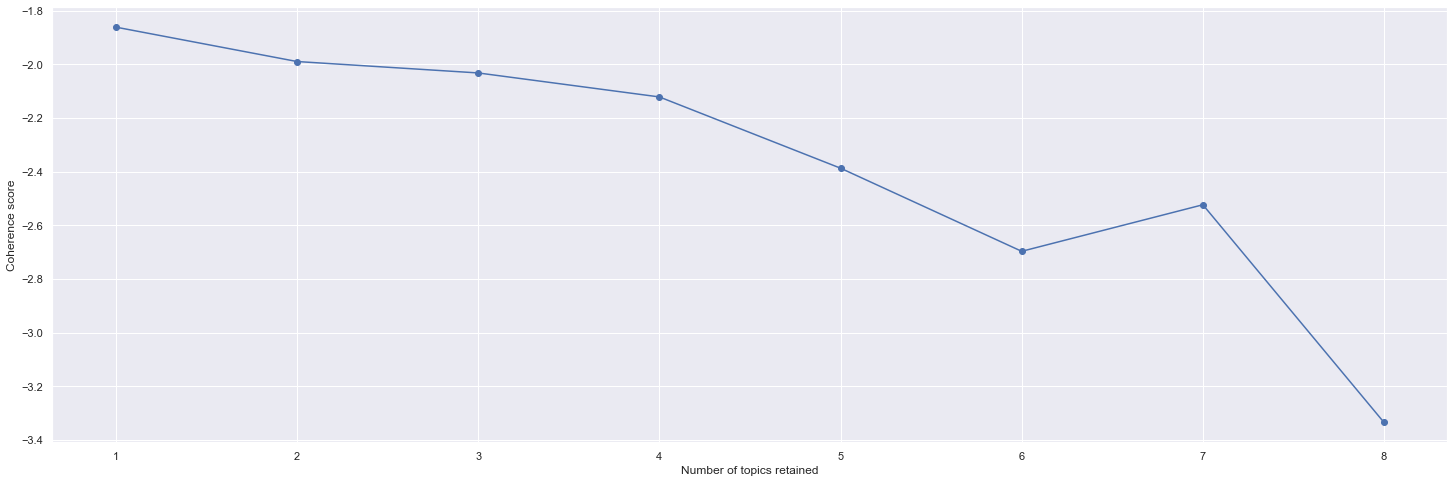

Iteration: 0	Log-likelihood: -8.65915087434492
Iteration: 4	Log-likelihood: -8.545368007410065
Iteration: 8	Log-likelihood: -8.452278779780617
Iteration: 12	Log-likelihood: -8.397638864520937
Iteration: 16	Log-likelihood: -8.360226902960543
Iteration: 20	Log-likelihood: -8.376196308292828
Iteration: 24	Log-likelihood: -8.351212092963634
Iteration: 28	Log-likelihood: -8.348206250086982
Iteration: 32	Log-likelihood: -8.326327461523054
Iteration: 36	Log-likelihood: -8.322450689668559
Iteration: 40	Log-likelihood: -8.32170003069469
Iteration: 44	Log-likelihood: -8.303284145203389
Iteration: 48	Log-likelihood: -8.311816701060536
Iteration: 52	Log-likelihood: -8.297234877311093
Iteration: 56	Log-likelihood: -8.28224281586472
Iteration: 60	Log-likelihood: -8.284605891188312
Iteration: 64	Log-likelihood: -8.281479206528859
Iteration: 68	Log-likelihood: -8.274151484934343
Iteration: 72	Log-likelihood: -8.263674076498287
Iteration: 76	Log-likelihood: -8.285337035005744
Iteration: 80	Log-likeliho

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,0.133618,0.113954,0.028815,0.123959,0.163104,0.055238,0.271325,0.109987
1,0.069657,0.099295,0.098678,0.230538,0.073650,0.286141,0.056332,0.085710
2,0.077137,0.109959,0.109275,0.147902,0.081559,0.102082,0.062382,0.309704
3,0.029544,0.247780,0.041853,0.509109,0.031238,0.039098,0.065026,0.036353
4,0.088976,0.519064,0.156255,0.071314,0.039326,0.049221,0.030079,0.045765
...,...,...,...,...,...,...,...,...
969,0.046910,0.066870,0.197076,0.155255,0.114910,0.323322,0.037937,0.057721
970,0.058341,0.245615,0.082648,0.193087,0.061685,0.077207,0.047181,0.234237
971,0.151905,0.090517,0.089954,0.298563,0.067138,0.084032,0.051352,0.166538
972,0.058341,0.164390,0.163873,0.111862,0.061685,0.158432,0.209631,0.071786


In [142]:
# Performing topic modelling for Q2

## Training 10 LDAs to choose the best topic size
cvs, corpus, best_mdl, topic_size, docs_phrased, index_list = tm(comments=yt_combined_brand['Clean_corpus'],k=8, Stopwords=stp_brand)  # 7 # 14 group #

best_mdl_trained = train_tm(best_mdl)

# Topic to word probabilities to understand words with the highest probabilities to occur in a topic and then
# to perhaps go back and include those words in custom stopwords in the LDA code
wt_brand = pd.DataFrame()
for k in range(best_mdl_trained.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt_brand = pd.concat([wt_brand, tmp], ignore_index=False)
    del tmp

# Document to topic probabilities with the final k=10 topics 
train_td_brand = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["Topic {}".format(i + 1) for i in range(best_mdl.k)])
train_td_brand

In [143]:
# inspecting topic themes as a dataframe just out of curiosity.
values = {}
for k in range(best_mdl.k):
    values['Topic {}'.format(k)]= [("{},({})".format(word, str(np.round(prob, 3)))) for word, prob in best_mdl.get_topic_words(k)]
    # print the table
    #return (table)
table_brand = pd.DataFrame(values)  

table_brand

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,"change,(0.026)","love,(0.04)","drive,(0.058)","look,(0.061)","range,(0.058)","new,(0.097)","seat,(0.038)","work,(0.031)"
1,"engine,(0.023)","good,(0.04)","great,(0.052)","price,(0.039)","charge,(0.038)","electric,(0.053)","right,(0.022)","buy,(0.028)"
2,"speed,(0.023)","review,(0.037)","year,(0.04)","cheap,(0.022)","ev,(0.034)","old,(0.022)","rear,(0.016)","need,(0.027)"
3,"fix,(0.018)","drive,(0.03)","time,(0.034)","want,(0.02)","battery,(0.031)","model,(0.021)","end,(0.015)","love,(0.026)"
4,"cost,(0.017)","city,(0.028)","buy,(0.03)","way,(0.02)","long,(0.027)","petrol,(0.019)","space,(0.015)","issue,(0.025)"
5,"month,(0.017)","come,(0.023)","thing,(0.023)","good,(0.019)","mile,(0.027)","start,(0.015)","find,(0.013)","italian,(0.018)"
6,"service,(0.016)","video,(0.021)","mile,(0.022)","buy,(0.019)","small,(0.02)","29k,(0.014)","boot,(0.013)","problem,(0.018)"
7,"year,(0.016)","little,(0.02)","big,(0.021)","people,(0.019)","spec,(0.014)","market,(0.013)","easy,(0.013)","stop,(0.018)"
8,"sound,(0.016)","fun,(0.017)","day,(0.021)","design,(0.019)","lot,(0.013)","brand,(0.013)","mean,(0.013)","reliable,(0.018)"
9,"km,(0.014)","actually,(0.017)","road,(0.021)","version,(0.018)","fast,(0.012)","uk,(0.013)","expensive,(0.012)","vehicle,(0.017)"


In [144]:
# Visualise the topics to inspect the number of topics and their interpetability
prepared_data = topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

#### Topic interpretation:
- **Topic 0**: Services and Issues
- **Topic 1**: Comments regarding the video
- **Topic 2**: City Cars (driving in the city)
- **Topic 3**: Design and price 
- **Topic 4**: Battery and chargers
- **Topic 5**: Dealer services
- **Topic 6**: Interior Configuration 
- **Topic 7**: Car Expenses

In [145]:
# Plotting the top 10 comments per topic
top_n_topics(train_td_brand,yt_combined_brand,table_brand, 10)

TOP 10 documents for topic 0 :
['change,(0.026)', 'engine,(0.023)', 'speed,(0.023)', 'fix,(0.018)', 'cost,(0.017)', 'month,(0.017)', 'service,(0.016)', 'year,(0.016)', 'sound,(0.016)', 'km,(0.014)']
0 :  Did anybody mention the Abarth ? The 695 models sound fun, particularly the Ferrari and Maserati special editions.......but they are serious money if you can find one at all as they only made 500 of each. They should have made them mainstream models....a pocket supercar. ...Yee Haa !
1 :  I had a 2015 pop. Only recently sold for a larger car...I miss the fiat everyday, it was fun to drive and didn&#39;t skip a beat. I had a manual so no transmission probs.
2 :  Great video as always.  I just don’t understand how people can justify £27k-£30k for a new Fiat.  In fact the price of new cars is becoming more and more unattainable.  For a while new cars were becoming affordable and it seems manufacturers are not making people cars anymore but cars that line the corporate pockets.
3 :  We nee

In [146]:
# Concentrate for the 2 main topics of each document and rescale them to find the average sentiment
main_topics = train_td_brand.apply(lambda row: row.nlargest(2),axis=1)
main_topics = main_topics.div(main_topics.sum(axis=1), axis=0)
main_topics = main_topics.replace(np.nan,0)
main_topics

# find the top 2 main topics
g = main_topics.filter(like='Topic')
main_topics['Main_topic1'] = g.idxmax(axis=1)
main_topics['Main_topic2'] = g.mask(g.eq(g.max(axis=1), axis=0) & g.apply(lambda x: ~x.duplicated(), axis=1)).idxmax(axis=1)
main_topics

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Main_topic1,Main_topic2
0,0.0,0.000000,0.000000,0.000000,0.375445,0.000000,0.624555,0.000000,Topic 7,Topic 5
1,0.0,0.000000,0.000000,0.446192,0.000000,0.553808,0.000000,0.000000,Topic 6,Topic 4
2,0.0,0.000000,0.000000,0.323208,0.000000,0.000000,0.000000,0.676792,Topic 8,Topic 4
3,0.0,0.327366,0.000000,0.672634,0.000000,0.000000,0.000000,0.000000,Topic 4,Topic 2
4,0.0,0.768620,0.231380,0.000000,0.000000,0.000000,0.000000,0.000000,Topic 2,Topic 3
...,...,...,...,...,...,...,...,...,...,...
969,0.0,0.000000,0.378702,0.000000,0.000000,0.621298,0.000000,0.000000,Topic 6,Topic 3
970,0.0,0.511856,0.000000,0.000000,0.000000,0.000000,0.000000,0.488144,Topic 2,Topic 8
971,0.0,0.000000,0.000000,0.641931,0.000000,0.000000,0.000000,0.358069,Topic 4,Topic 8
972,0.0,0.439520,0.000000,0.000000,0.000000,0.000000,0.560480,0.000000,Topic 7,Topic 2


In [147]:
# Labeling the topics

brand_topic_labels = ['Services_and_Issues', 'Comments_for_Video', 'City_Cars', 'Design_Price',
                      'Battery_Charger', 'Dealer_services','Interior_Configuration','Car_expenses']

In [148]:
# Removing the documents that don't have topics
yt_combined_brand = yt_combined_brand.drop(index_list, axis=0)
yt_combined_brand.reset_index(drop=True, inplace=True)

In [149]:
topic_sentiment_brand = pd.concat([main_topics, yt_combined_brand[['compound','sentiment','fiat_brand','fiat500_brand','time_updated','Sentiment_corpus','Clean_corpus']]],axis=1)

In [150]:
# seperate the subset Fiat500e & it's compatitors
topic_senti_fiat500_yt= topic_sentiment_brand.loc[(topic_sentiment_brand['fiat500_brand']==1) & (topic_sentiment_brand['fiat_brand']!=1)]
topic_senti_fiat_yt =topic_sentiment_brand.loc[(topic_sentiment_brand['fiat500_brand']!=1) & (topic_sentiment_brand['fiat_brand']==1)]

In [151]:
# For Fiat 500 brand

# Find the number of main topics discued in the comments that mention fiat 500 hybrid
topics_per_comment_fiat500_brand = topic_senti_fiat500_yt['Main_topic1'].value_counts()

# Find the number of main topics discued in the comments that mention fiat 500 hybrid 
topics2_per_comment_fiat500_brand = topic_senti_fiat500_yt['Main_topic2'].value_counts()

# Find the average probabilty of each topic to appear in the corpus of fiat 500 hybrid
topics_prob_fiat500_brand = topic_senti_fiat500_yt[list(topic_senti_fiat500_yt.columns.values)].mean()[:8]

# Finding the average sentiment of each topic for the comments that mention fiat 500 hybrid
weighted_avg_senti_fiat500_brand = weighted_avg(df = topic_senti_fiat500_yt)

# Finding the total occurances of each topic for the comments that mention 500 hybrid
total_topics_per_comment_fiat500_brand = topics_per_comment_fiat500_brand + topics2_per_comment_fiat500_brand

# Finding the percentage of total occurances of each topic for the comments that mention 500 hybrid
percentage_topics_per_comment_fiat500_brand = round(total_topics_per_comment_fiat500_brand/ topic_senti_fiat500_yt.shape[0],2)

fiat_500_results_brand = pd.DataFrame([total_topics_per_comment_fiat500_brand, percentage_topics_per_comment_fiat500_brand, topics_per_comment_fiat500_brand, topics2_per_comment_fiat500_brand , topics_prob_fiat500_brand, weighted_avg_senti_fiat500_brand]).T
fiat_500_results_brand = fiat_500_results_brand.rename(columns={'Unnamed 0': 'Topic_Appearance', 'Unnamed 1': 'Topic_Percentage', 'Unnamed 2': 'Average_Topic_Prob', 'Unnamed 3': 'Average_Sentiment'})

# Find the sentiment for each topic
for topic in fiat_500_results_brand.index:
    temp = topic_senti_fiat500_yt[topic_senti_fiat500_yt[topic]!=0]['sentiment'].value_counts()
    if topic == fiat_500_results_brand.index[0]:
        sentiments_500 = temp
    else:
        sentiments_500 = pd.concat([sentiments_500, temp], axis=1)

sentiments_500 = sentiments_500.T.set_index(fiat_500_results_brand.index)

fiat_500_results_brand = pd.concat([fiat_500_results_brand, sentiments_500], axis=1)
fiat_500_results_brand['Positive_Percentage'] = fiat_500_results_brand.pos / (fiat_500_results_brand.pos + fiat_500_results_brand.neu + fiat_500_results_brand.neg)
fiat_500_results_brand['Average_Sentiment_Whole'] = weighted_avg(df = topic_sentiment_brand)
fiat_500_results_brand

,Topic_Appearance,Topic_Percentage,Main_topic1,Main_topic2,Average_Topic_Prob,Average_Sentiment,pos,neg,neu,Positive_Percentage,Average_Sentiment_Whole
Topic 1,88.0,0.14,40.0,48.0,0.067215,0.399,61,17,10,0.693182,0.292
Topic 2,224.0,0.35,113.0,111.0,0.170490,0.462,164,41,19,0.732143,0.442
Topic 3,181.0,0.29,76.0,105.0,0.134674,0.387,127,29,25,0.701657,0.362
Topic 4,307.0,0.48,175.0,132.0,0.252375,0.314,196,56,55,0.638436,0.286
Topic 5,117.0,0.18,68.0,49.0,0.099365,0.259,71,31,15,0.606838,0.291
Topic 6,162.0,0.26,81.0,81.0,0.130618,0.172,87,40,35,0.537037,0.152
Topic 7,76.0,0.12,31.0,45.0,0.056252,0.422,56,11,9,0.736842,0.390
Topic 8,111.0,0.18,49.0,62.0,0.089011,0.275,70,25,16,0.630631,0.214


In [152]:
# For Fiat 500 brand

# Find the number of main topics discued in the comments that mention fiat 500 hybrid
topics_per_comment_fiat_brand = topic_senti_fiat_yt['Main_topic1'].value_counts()

# Find the number of main topics discued in the comments that mention fiat 500 hybrid 
topics2_per_comment_fiat_brand = topic_senti_fiat_yt['Main_topic2'].value_counts()

# Find the average probabilty of each topic to appear in the corpus of fiat 500 hybrid
topics_prob_fiat_brand = topic_senti_fiat_yt[list(topic_senti_fiat_yt.columns.values)].mean()[:8]

# Finding the average sentiment of each topic for the comments that mention fiat 500 hybrid
weighted_avg_senti_fiat_brand = weighted_avg(df = topic_senti_fiat_yt)

# Finding the total occurances of each topic for the comments that mention 500 hybrid
total_topics_per_comment_fiat_brand = topics_per_comment_fiat_brand + topics2_per_comment_fiat_brand

# Finding the percentage of total occurances of each topic for the comments that mention 500 hybrid
percentage_topics_per_comment_fiat_brand = round(total_topics_per_comment_fiat_brand/ topic_senti_fiat_yt.shape[0],2)

fiat_results_brand = pd.DataFrame([total_topics_per_comment_fiat_brand, percentage_topics_per_comment_fiat_brand, topics_per_comment_fiat_brand, topics2_per_comment_fiat_brand , topics_prob_fiat_brand, weighted_avg_senti_fiat_brand]).T
fiat_results_brand = fiat_results_brand.rename(columns={'Unnamed 0': 'Topic_Appearance', 'Unnamed 1': 'Topic_Percentage', 'Unnamed 2': 'Average_Topic_Prob', 'Unnamed 3': 'Average_Sentiment'})

# Find the sentiment for each topic
for topic in fiat_results_brand.index:
    temp = topic_senti_fiat_yt[topic_senti_fiat_yt[topic]!=0]['sentiment'].value_counts()
    if topic == fiat_results_brand.index[0]:
        sentiments = temp
    else:
        sentiments = pd.concat([sentiments, temp], axis=1)

sentiments = sentiments.T.set_index(fiat_results_brand.index)

fiat_results_brand = pd.concat([fiat_results_brand, sentiments], axis=1)
fiat_results_brand['Positive_Percentage'] = fiat_results_brand.pos / (fiat_results_brand.pos + fiat_results_brand.neu + fiat_results_brand.neg)
fiat_results_brand['Average_Sentiment_Whole'] = weighted_avg(df = topic_sentiment_brand)
fiat_results_brand

,Topic_Appearance,Topic_Percentage,Main_topic1,Main_topic2,Average_Topic_Prob,Average_Sentiment,pos,neu,neg,Positive_Percentage,Average_Sentiment_Whole
Topic 1,54.0,0.16,31.0,23.0,0.085287,0.135,25,17,12,0.462963,0.292
Topic 2,97.0,0.28,40.0,57.0,0.130127,0.393,61,18,18,0.628866,0.442
Topic 3,107.0,0.31,51.0,56.0,0.149267,0.321,67,16,24,0.626168,0.362
Topic 4,166.0,0.49,97.0,69.0,0.253045,0.234,91,43,32,0.548193,0.286
Topic 5,45.0,0.13,23.0,22.0,0.067103,0.380,30,9,6,0.666667,0.291
Topic 6,100.0,0.29,47.0,53.0,0.148766,0.121,46,26,28,0.460000,0.152
Topic 7,32.0,0.09,14.0,18.0,0.044627,0.317,21,6,5,0.656250,0.390
Topic 8,81.0,0.24,38.0,43.0,0.121780,0.130,35,21,25,0.432099,0.214


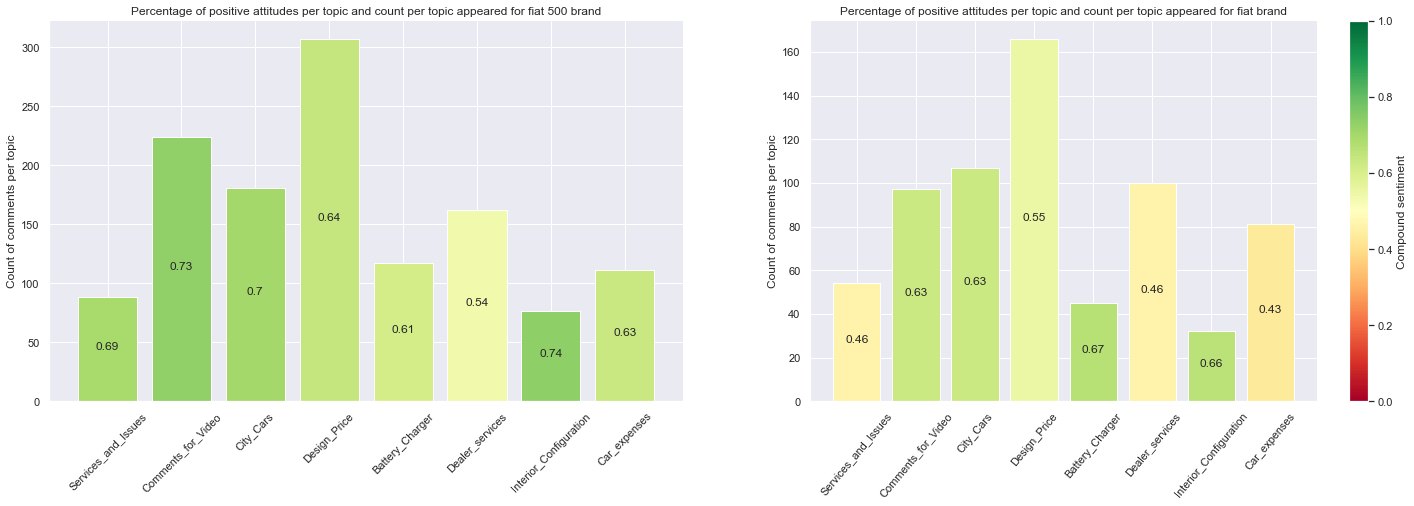

In [153]:
# Ploting the average positive percentage of comments pre topic
fig = plt.figure(figsize = (25,7))
ax = fig.add_subplot(1,2,1)

height = fiat_500_results_brand['Topic_Appearance']
sentiment = fiat_500_results_brand['Positive_Percentage']
bars = fiat_500_results_brand.index
y_pos = np.arange(len(bars))

cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)


# Create bars
ax.bar(y_pos, height, color=cmap(norm(fiat_500_results_brand['Positive_Percentage'])))

def add_value_label(x_list,y_place, y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_place[i]/2,round(y_list[i],2), ha="center")
add_value_label(y_pos, height ,sentiment)

#add_value_label(y_pos,height)
ax.set_title("Percentage of positive attitudes per topic and count per topic appeared for fiat 500 brand")

# Create names on the x-axis
ax.set_xticks(y_pos, brand_topic_labels,rotation = 45)
ax.set_ylabel("Count of comments per topic")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1 = fig.add_subplot(1,2,2)
height1 = fiat_results_brand['Topic_Appearance']
sentiment1 = fiat_results_brand['Positive_Percentage']

# Create bars
ax1.bar(y_pos, height1, color=cmap(norm(fiat_results_brand['Positive_Percentage'])))
add_value_label(y_pos, height1 ,sentiment1)

#add_value_label(y_pos,height)
ax1.set_title("Percentage of positive attitudes per topic and count per topic appeared for fiat brand")

# Create names on the x-axis
ax1.set_xticks(y_pos, brand_topic_labels,rotation = 50)
ax1.set_ylabel("Count of comments per topic")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Compound sentiment')

# Show graphic
plt.show()

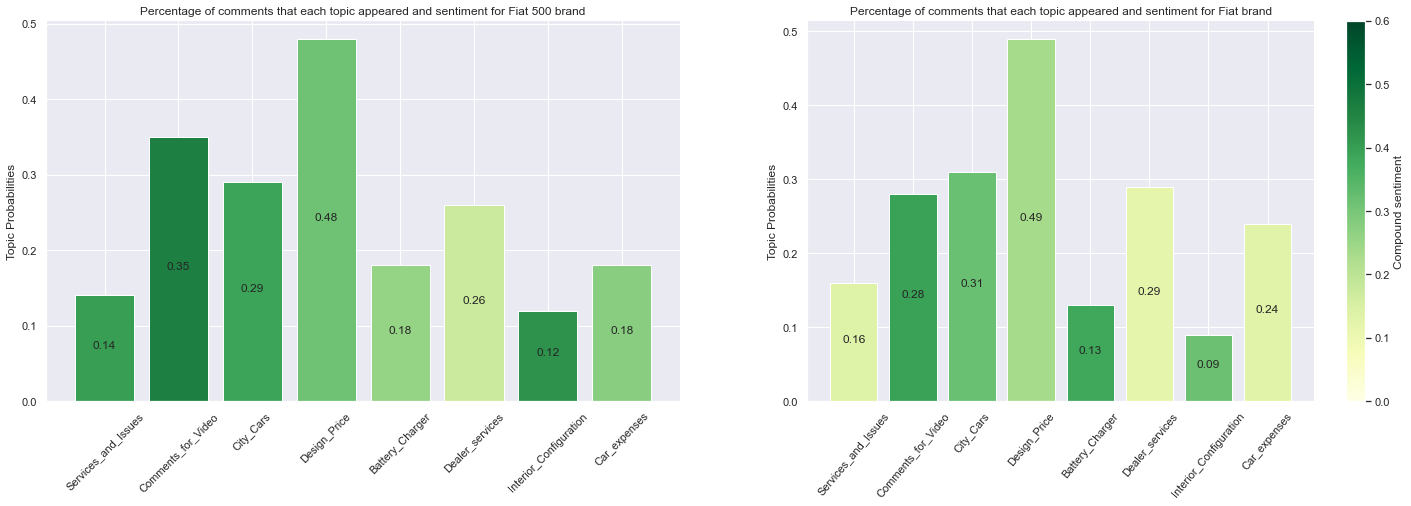

In [154]:
fig = plt.figure(figsize = (25,7))
ax = fig.add_subplot(1,2,1)

height = fiat_500_results_brand['Topic_Percentage']
bars = fiat_500_results_brand.index
y_pos = np.arange(len(bars))

cmap = plt.cm.YlGn
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=0.6)

# Create bars
ax.bar(y_pos, height, color=cmap(norm(fiat_500_results_brand['Average_Sentiment'])))

def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i,y_list[i]/2,round(y_list[i],2), ha="center")
add_value_label(y_pos,height)

#add_value_label(y_pos,height)
ax.set_title("Percentage of comments that each topic appeared and sentiment for Fiat 500 brand")

# Create names on the x-axis
ax.set_xticks(y_pos, brand_topic_labels,rotation = 45)
ax.set_ylabel("Topic Probabilities")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1 = fig.add_subplot(1,2,2)
height1 = fiat_results_brand['Topic_Percentage']

# Create bars
ax1.bar(y_pos, height1, color=cmap(norm(fiat_results_brand['Average_Sentiment'])))
add_value_label(y_pos,height1)

#add_value_label(y_pos,height)
ax1.set_title("Percentage of comments that each topic appeared and sentiment for Fiat brand")

# Create names on the x-axis
ax1.set_xticks(y_pos, brand_topic_labels,rotation = 50)
ax1.set_ylabel("Topic Probabilities")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Compound sentiment')

# Show graphic
plt.show()

In [155]:
# Dataset with the while fiat
topic_sentiment_fiat = topic_sentiment_brand.loc[(topic_sentiment_brand['fiat500_brand']==1) | (topic_sentiment_brand['fiat_brand']==1)]

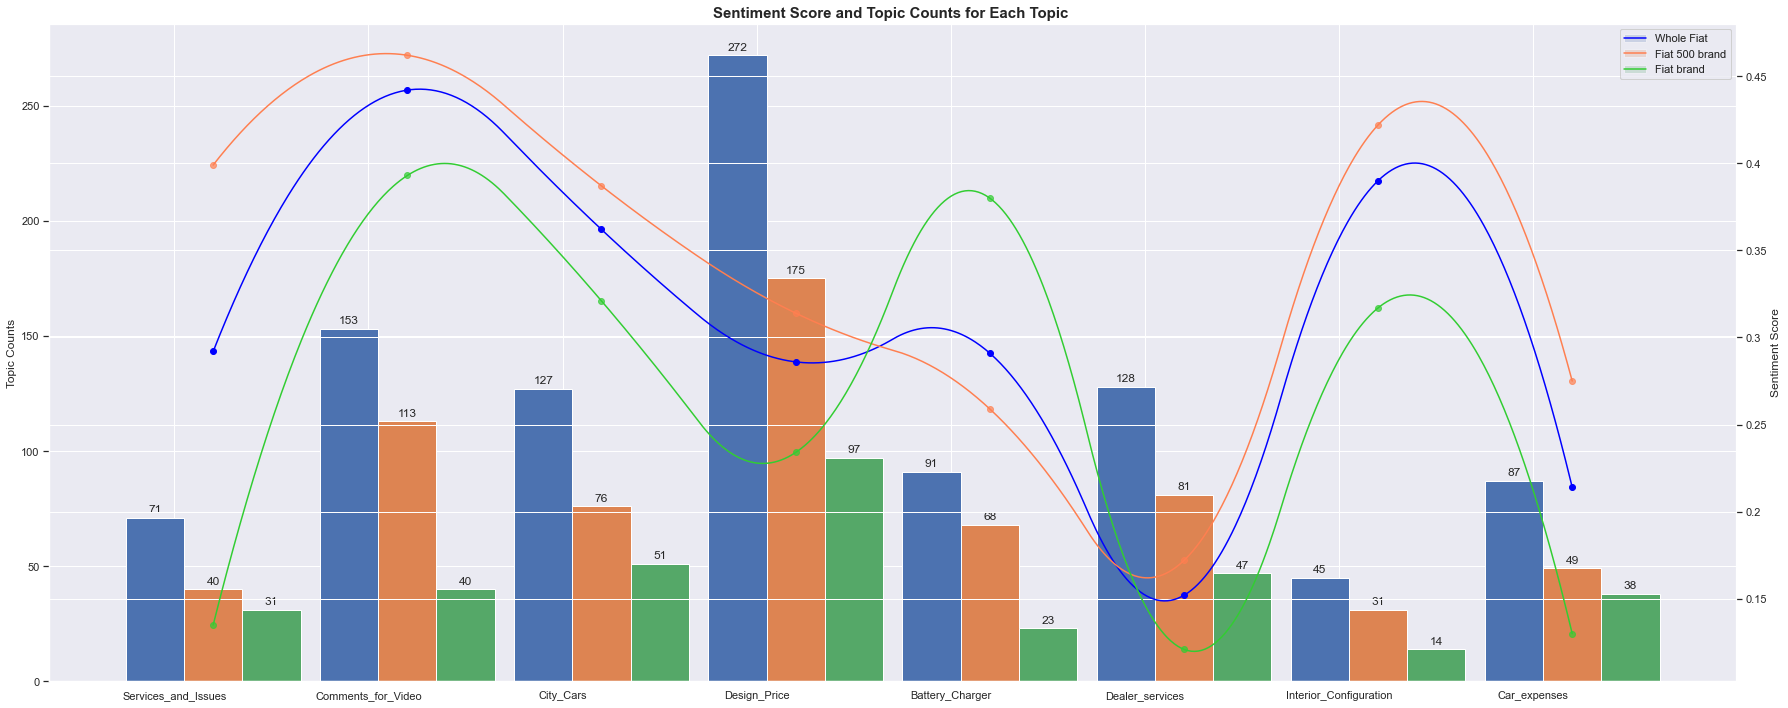

In [156]:
# Visualising the results per sentiment

topics_y = topic_sentiment_fiat.groupby('Main_topic1')['Topic 1'].count().values


x = np.arange(fiat_500_results_brand.shape[0])  # the label locations
x_pos = np.arange(0,fiat_500_results_brand.shape[0])
width = 0.30  # the width of the bar

fig = plt.figure(figsize=(25,10))

ax1 = fig.add_subplot(1,1,1)

# fiat
topics_fiate = topic_senti_fiat500_yt.groupby('Main_topic1')['time_updated'].count().values
# renault
topics_fiath = topic_senti_fiat_yt.groupby('Main_topic1')['time_updated'].count().values

## Add the plot for hybrid
rects1 = ax1.bar(x - width/3, topics_y, width, label='Whole Fiat')
rects2 = ax1.bar(x + width/3+0.1, topics_fiate, width, label='Fiat 500 brand')
rects3 = ax1.bar(x + width/3+0.4, topics_fiath, width, label='Fiat brand')

ax2 = ax1.twinx()
ax2.scatter(x + width/3+0.1 ,fiat_500_results_brand['Average_Sentiment_Whole'],  color = 'blue', alpha =1)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500_results_brand['Average_Sentiment_Whole']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'blue', label='Whole Fiat')

ax2.scatter(x + width/3+0.1,fiat_500_results_brand['Average_Sentiment'],  color = 'coral', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1, fiat_500_results_brand['Average_Sentiment']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'coral', label='Fiat 500 brand')

ax2.scatter(x + width/3+0.1,fiat_results_brand['Average_Sentiment'],  color = 'limegreen', alpha =0.7)
param = np.linspace(0, 1, len(x_pos))
from scipy.interpolate import make_interp_spline
spl = make_interp_spline(param, np.c_[x + width/3+0.1,fiat_results_brand['Average_Sentiment'] ], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x_pos) * 100)).T
plt.plot(xnew, y_smooth,c= 'limegreen', label='Fiat brand')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Topic Counts')
ax2.set_ylabel('Sentiment Score')

vals = ax2.get_yticks()
ax2.set_yticklabels([round(x,2) for x in vals])

ax1.set_title('Sentiment Score and Topic Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})
ax1.set_xticks(x, brand_topic_labels)
ax1.legend()
ax2.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)
ax1.bar_label(rects3, padding=3)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
         
fig.tight_layout()

plt.show()

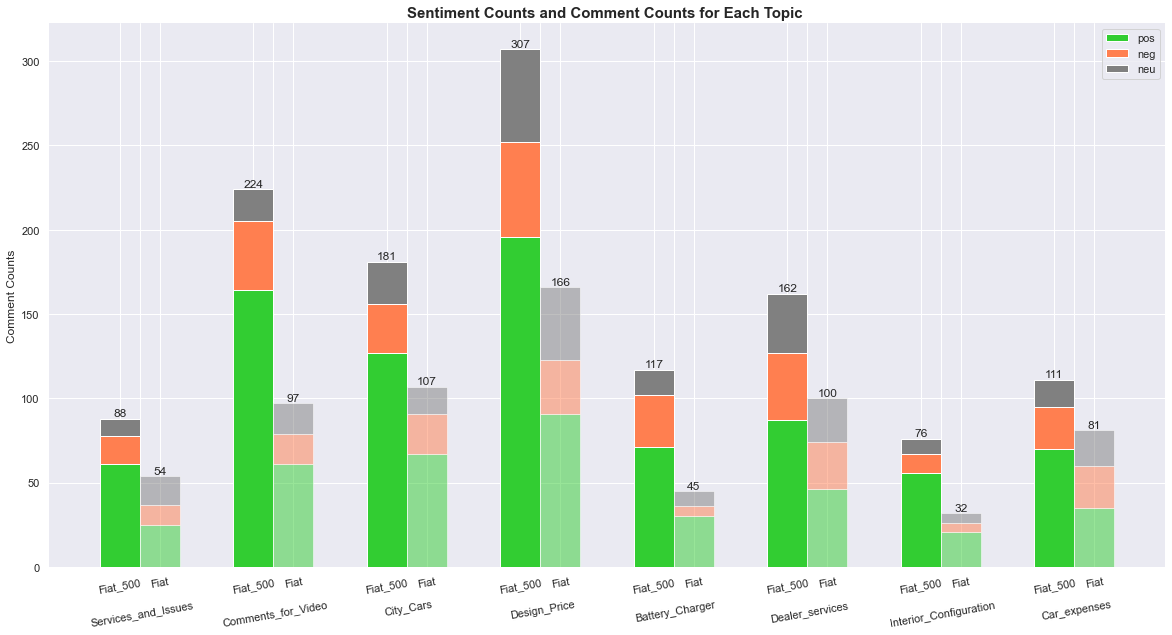

In [157]:
# Visualising the count of pos, neg and neu per topic 

sentiment_labels = ['pos','neg','neu']
colors = ["limegreen","coral","grey"]
width =0.30

x = list()
ind = np.arange(len(fiat_500_results_brand))   # Number of topics
# x labels position: i = 1st bar, i+w/2 = category, i+w = 2nd bar
for i in ind:
    x.extend([i, i+width/2., i+width])  

# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

#temp_combined = topic_senti_combined.iloc[:,2:5]
temp_500= fiat_500_results_brand.iloc[:,6:9]
temp_fiat = fiat_results_brand.iloc[:,6:9]

#bev
ax.bar(ind, temp_500[sentiment_labels[0]], width,  label = sentiment_labels[0], color = colors[0],alpha = 1)
ax.bar(ind, temp_500[sentiment_labels[1]], width,   label = sentiment_labels[1], color = colors[1],bottom= temp_500[sentiment_labels[0]] ,alpha = 1)
ax.bar(ind, temp_500[sentiment_labels[2]], width,   label = sentiment_labels[2], color = colors[2],bottom= temp_500[sentiment_labels[0]] + temp_500[sentiment_labels[1]],alpha =1 )

count_500 = fiat_500_results_brand.iloc[:,6:9].sum(axis=1)
count_fiat =  fiat_results_brand.iloc[:,6:9].sum(axis=1)

for a, b in zip(ind, count_500):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)
for a, b in zip(ind+width, count_fiat):   
    plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=12)

#hybrid
ax.bar(ind+width, temp_fiat[sentiment_labels[0]], width,  color = colors[0],alpha = 0.5)
ax.bar(ind+width, temp_fiat[sentiment_labels[1]], width,  color = colors[1],bottom=  temp_fiat[sentiment_labels[0]] , alpha = 0.5)
ax.bar(ind+width, temp_fiat[sentiment_labels[2]], width,  color = colors[2],bottom=  temp_fiat[sentiment_labels[0]] + temp_fiat[sentiment_labels[1]], alpha = 0.5)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False) 


# Labelling 
# plt.xlabel("Discussion Date")
plt.ylabel("Comment Counts")
plt.xticks(x)

ax.set_xticklabels(('Fiat_500','\n\nServices_and_Issues', 'Fiat', 'Fiat_500','\n\nComments_for_Video', 'Fiat',
                    'Fiat_500','\n\nCity_Cars', 'Fiat','Fiat_500','\n\nDesign_Price', 'Fiat',
                    'Fiat_500','\n\nBattery_Charger', 'Fiat','Fiat_500','\n\nDealer_services', 'Fiat',
                    'Fiat_500','\n\nInterior_Configuration', 'Fiat','Fiat_500','\n\nCar_expenses', 'Fiat'),ha='center',rotation = 10)

ax.set_title('Sentiment Counts and Comment Counts for Each Topic ',fontdict={'size': 15, 'weight': 700})

plt.legend()

In [158]:
# Labeling the topics
brand_topic_labels = ['Design','City_Cars','Services_and_Issues','Driving_Behavior','Interior_Configuration','Comments_for_Video',
                       'Car_expenses','Battery/charger_and_price']

In [159]:
def topics_per_month_yt(df, column_name1, column_name2, topic_labels, n_topics):

   colors = ["lightblue","green","grey","darkorange","blue","firebrick","limegreen",'salmon']

   width = 20

   df['date'] = pd.to_datetime(df['time_updated'])
   df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
   df = df.loc[df['month_year'].between('2020-01','2022-08', inclusive=True)]
   df = df.loc[(df[column_name1] ==1) & (df[column_name2] !=1)]

   topics_df = pd.DataFrame()
   topics_df['month_year'] = df['month_year']
   topics_df['Main_topic1'] = df['Main_topic1']
   topics_df['count'] = 1

   df_topics= df.groupby(['month_year', 'Main_topic1']).size().unstack(fill_value=0)
   df_topics.columns = topic_labels
   # sns.set_style("whitegrid")
   fig = plt.figure(figsize=(20, 10))
   ax = fig.add_subplot(1, 1, 1)
   quarter1 = df_topics.index.to_timestamp()

   bottom=[0]
   plt.bar(quarter1,df_topics[topic_labels[0]], width, label = topic_labels[0], color = colors[0])

   for i in range(1, n_topics):
       bottom.append(bottom[i-1] + df_topics[topic_labels[i-1]])
       plt.bar(quarter1,df_topics[topic_labels[i]], width, label = topic_labels[i], color = colors[i], bottom = bottom[i])

   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['top'].set_visible(False)
   ax.spines['bottom'].set_visible(False)
   ax.set_title('Count of topics per month for ' + str(column_name1) ) 

   # Labelling 
   plt.xlabel("Discussion Date")
   plt.ylabel("Topic Counts")
   plt.legend()
   
   return df_topics

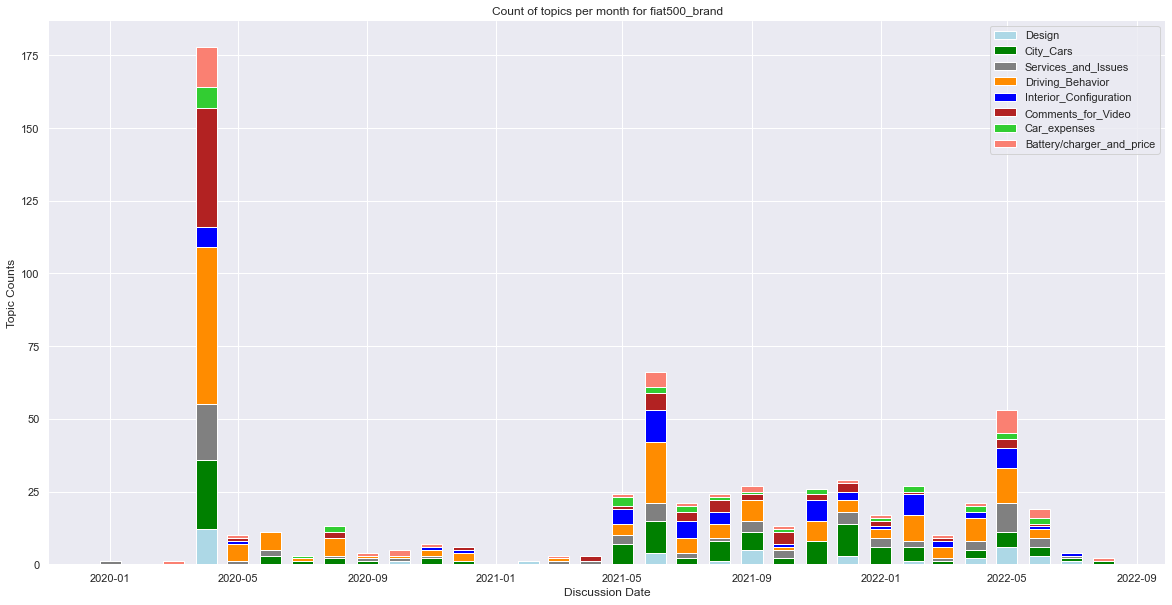

In [160]:
df_topic_500 = topics_per_month_yt(topic_sentiment_brand, 'fiat500_brand','fiat_brand', brand_topic_labels, 8)

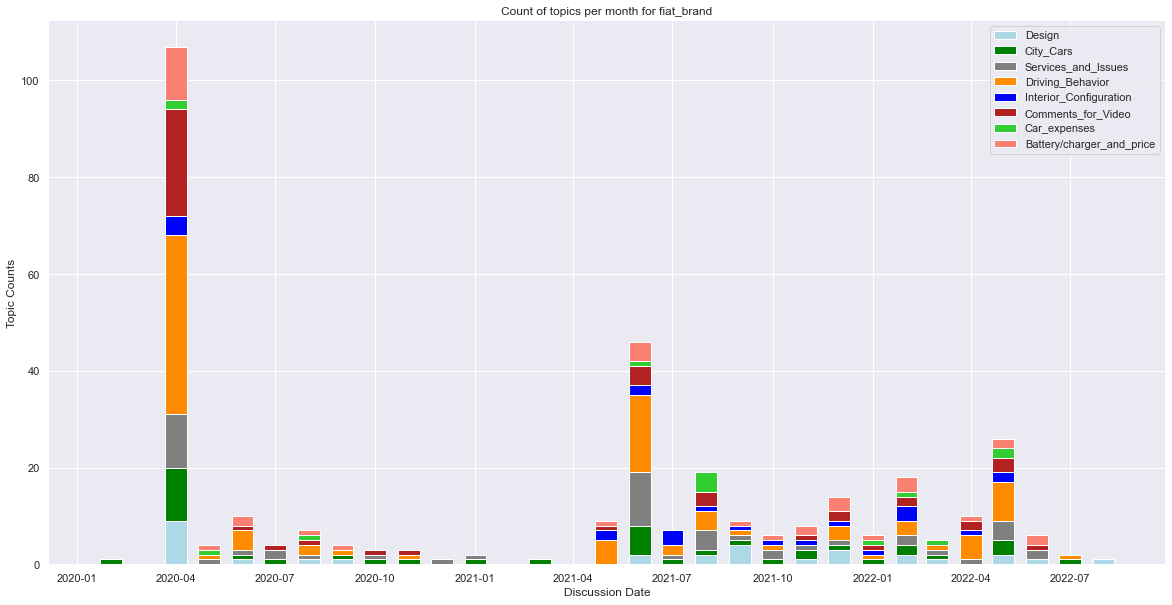

In [161]:
df_topic_fiat = topics_per_month_yt(topic_sentiment_brand, 'fiat_brand','fiat500_brand', brand_topic_labels, 8)

In [162]:
yt_brand_df= pd.concat([topic_senti_fiat500_yt, topic_senti_fiat_yt], axis=0)

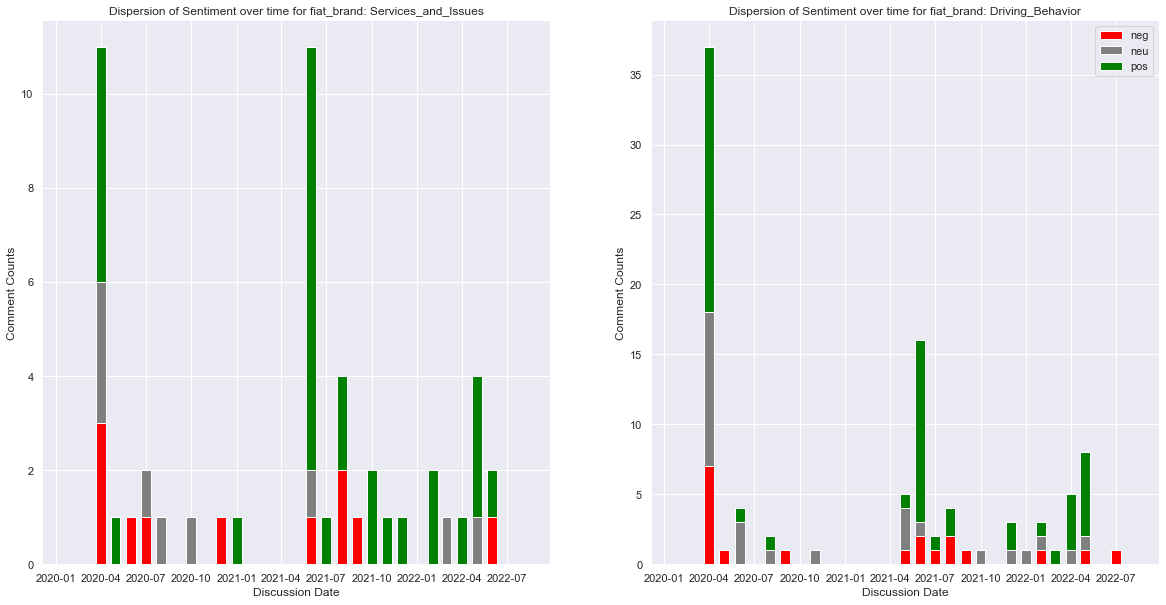

In [163]:
topic_sentiment_dispersion_plot(yt_brand_df, 3, 4, 'fiat_brand','fiat500_brand', brand_topic_labels)

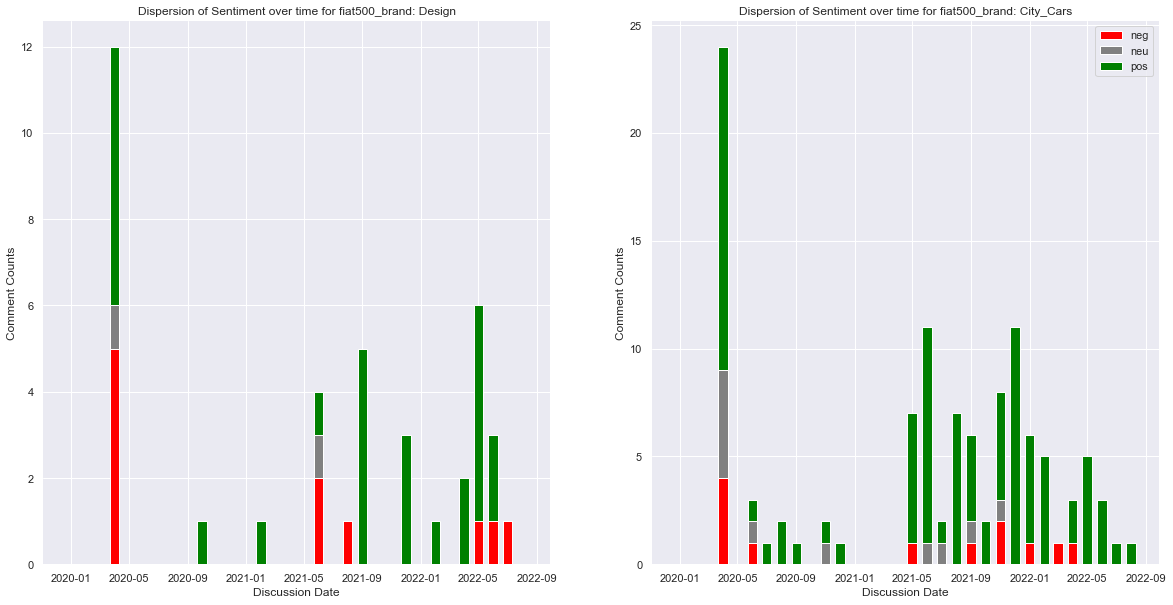

In [164]:
topic_sentiment_dispersion_plot(yt_brand_df, 1, 2, 'fiat500_brand','fiat_brand', brand_topic_labels)